In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_t1_mask_t1t2_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4629816, 920)
(4629816, 8)
validation
(621056, 920)
(621056, 8)
test
(624904, 920)
(624904, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 920)]             0         


 dense (Dense)               (None, 1024)              943104    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1633160 (6.23 MB)


Trainable params: 1633160 (6.23 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/463 [..............................] - ETA: 10:08 - loss: 2.3710 - STD: 0.0853 - MAE: 0.2197

  4/463 [..............................] - ETA: 8s - loss: 2.1768 - STD: 0.0562 - MAE: 0.2177   

  7/463 [..............................] - ETA: 8s - loss: 2.1334 - STD: 0.0573 - MAE: 0.2166

 11/463 [..............................] - ETA: 7s - loss: 2.1161 - STD: 0.0533 - MAE: 0.2166

 14/463 [..............................] - ETA: 7s - loss: 2.1048 - STD: 0.0499 - MAE: 0.2166

 17/463 [>.............................] - ETA: 7s - loss: 2.0951 - STD: 0.0472 - MAE: 0.2166

 20/463 [>.............................] - ETA: 7s - loss: 2.0892 - STD: 0.0454 - MAE: 0.2166

 23/463 [>.............................] - ETA: 7s - loss: 2.0851 - STD: 0.0436 - MAE: 0.2166

 26/463 [>.............................] - ETA: 7s - loss: 2.0813 - STD: 0.0419 - MAE: 0.2167

 29/463 [>.............................] - ETA: 7s - loss: 2.0780 - STD: 0.0406 - MAE: 0.2167

 32/463 [=>............................] - ETA: 7s - loss: 2.0746 - STD: 0.0400 - MAE: 0.2166

 35/463 [=>............................] - ETA: 7s - loss: 2.0718 - STD: 0.0396 - MAE: 0.2166

 38/463 [=>............................] - ETA: 7s - loss: 2.0687 - STD: 0.0392 - MAE: 0.2165

 41/463 [=>............................] - ETA: 14s - loss: 2.0650 - STD: 0.0387 - MAE: 0.2165

 44/463 [=>............................] - ETA: 14s - loss: 2.0608 - STD: 0.0384 - MAE: 0.2164

 48/463 [==>...........................] - ETA: 13s - loss: 2.0540 - STD: 0.0385 - MAE: 0.2161

 52/463 [==>...........................] - ETA: 12s - loss: 2.0457 - STD: 0.0393 - MAE: 0.2158

 55/463 [==>...........................] - ETA: 12s - loss: 2.0386 - STD: 0.0404 - MAE: 0.2155

 58/463 [==>...........................] - ETA: 12s - loss: 2.0311 - STD: 0.0416 - MAE: 0.2152

 61/463 [==>...........................] - ETA: 11s - loss: 2.0230 - STD: 0.0429 - MAE: 0.2148

 64/463 [===>..........................] - ETA: 11s - loss: 2.0146 - STD: 0.0443 - MAE: 0.2144

 67/463 [===>..........................] - ETA: 11s - loss: 2.0059 - STD: 0.0458 - MAE: 0.2140

 70/463 [===>..........................] - ETA: 11s - loss: 1.9968 - STD: 0.0471 - MAE: 0.2135

 73/463 [===>..........................] - ETA: 10s - loss: 1.9874 - STD: 0.0485 - MAE: 0.2131

 76/463 [===>..........................] - ETA: 10s - loss: 1.9779 - STD: 0.0499 - MAE: 0.2127

 79/463 [====>.........................] - ETA: 10s - loss: 1.9682 - STD: 0.0513 - MAE: 0.2122

 82/463 [====>.........................] - ETA: 10s - loss: 1.9584 - STD: 0.0527 - MAE: 0.2117

 85/463 [====>.........................] - ETA: 10s - loss: 1.9484 - STD: 0.0541 - MAE: 0.2112

 88/463 [====>.........................] - ETA: 9s - loss: 1.9381 - STD: 0.0554 - MAE: 0.2107 

 91/463 [====>.........................] - ETA: 9s - loss: 1.9274 - STD: 0.0568 - MAE: 0.2102

 94/463 [=====>........................] - ETA: 9s - loss: 1.9166 - STD: 0.0583 - MAE: 0.2096

 97/463 [=====>........................] - ETA: 9s - loss: 1.9056 - STD: 0.0599 - MAE: 0.2090

100/463 [=====>........................] - ETA: 9s - loss: 1.8944 - STD: 0.0615 - MAE: 0.2083

103/463 [=====>........................] - ETA: 9s - loss: 1.8830 - STD: 0.0632 - MAE: 0.2076

106/463 [=====>........................] - ETA: 8s - loss: 1.8717 - STD: 0.0650 - MAE: 0.2069

109/463 [======>.......................] - ETA: 8s - loss: 1.8607 - STD: 0.0668 - MAE: 0.2061

112/463 [======>.......................] - ETA: 8s - loss: 1.8499 - STD: 0.0686 - MAE: 0.2054

115/463 [======>.......................] - ETA: 8s - loss: 1.8391 - STD: 0.0703 - MAE: 0.2047

118/463 [======>.......................] - ETA: 8s - loss: 1.8286 - STD: 0.0720 - MAE: 0.2040

121/463 [======>.......................] - ETA: 8s - loss: 1.8182 - STD: 0.0737 - MAE: 0.2033

124/463 [=======>......................] - ETA: 8s - loss: 1.8080 - STD: 0.0753 - MAE: 0.2026

127/463 [=======>......................] - ETA: 8s - loss: 1.7983 - STD: 0.0769 - MAE: 0.2019

130/463 [=======>......................] - ETA: 7s - loss: 1.7890 - STD: 0.0785 - MAE: 0.2013

133/463 [=======>......................] - ETA: 7s - loss: 1.7797 - STD: 0.0800 - MAE: 0.2006

136/463 [=======>......................] - ETA: 7s - loss: 1.7707 - STD: 0.0815 - MAE: 0.2000

139/463 [========>.....................] - ETA: 7s - loss: 1.7616 - STD: 0.0830 - MAE: 0.1993

142/463 [========>.....................] - ETA: 7s - loss: 1.7529 - STD: 0.0844 - MAE: 0.1987

145/463 [========>.....................] - ETA: 7s - loss: 1.7442 - STD: 0.0858 - MAE: 0.1981

148/463 [========>.....................] - ETA: 7s - loss: 1.7358 - STD: 0.0872 - MAE: 0.1974

151/463 [========>.....................] - ETA: 7s - loss: 1.7278 - STD: 0.0885 - MAE: 0.1968

154/463 [========>.....................] - ETA: 7s - loss: 1.7197 - STD: 0.0898 - MAE: 0.1962

157/463 [=========>....................] - ETA: 7s - loss: 1.7118 - STD: 0.0911 - MAE: 0.1956

160/463 [=========>....................] - ETA: 6s - loss: 1.7041 - STD: 0.0924 - MAE: 0.1951

163/463 [=========>....................] - ETA: 6s - loss: 1.6966 - STD: 0.0936 - MAE: 0.1945

166/463 [=========>....................] - ETA: 6s - loss: 1.6894 - STD: 0.0948 - MAE: 0.1939

169/463 [=========>....................] - ETA: 6s - loss: 1.6823 - STD: 0.0960 - MAE: 0.1934

172/463 [==========>...................] - ETA: 6s - loss: 1.6755 - STD: 0.0972 - MAE: 0.1929

175/463 [==========>...................] - ETA: 6s - loss: 1.6688 - STD: 0.0983 - MAE: 0.1923

178/463 [==========>...................] - ETA: 6s - loss: 1.6623 - STD: 0.0995 - MAE: 0.1918

181/463 [==========>...................] - ETA: 6s - loss: 1.6561 - STD: 0.1005 - MAE: 0.1913

184/463 [==========>...................] - ETA: 6s - loss: 1.6499 - STD: 0.1016 - MAE: 0.1908

187/463 [===========>..................] - ETA: 6s - loss: 1.6438 - STD: 0.1026 - MAE: 0.1904

190/463 [===========>..................] - ETA: 6s - loss: 1.6377 - STD: 0.1036 - MAE: 0.1899

193/463 [===========>..................] - ETA: 5s - loss: 1.6318 - STD: 0.1046 - MAE: 0.1894

196/463 [===========>..................] - ETA: 5s - loss: 1.6263 - STD: 0.1056 - MAE: 0.1890

199/463 [===========>..................] - ETA: 5s - loss: 1.6209 - STD: 0.1065 - MAE: 0.1885

202/463 [============>.................] - ETA: 5s - loss: 1.6155 - STD: 0.1075 - MAE: 0.1881

205/463 [============>.................] - ETA: 5s - loss: 1.6103 - STD: 0.1084 - MAE: 0.1877

208/463 [============>.................] - ETA: 5s - loss: 1.6053 - STD: 0.1093 - MAE: 0.1873

211/463 [============>.................] - ETA: 5s - loss: 1.6002 - STD: 0.1101 - MAE: 0.1868

214/463 [============>.................] - ETA: 5s - loss: 1.5953 - STD: 0.1110 - MAE: 0.1864

217/463 [=============>................] - ETA: 5s - loss: 1.5903 - STD: 0.1118 - MAE: 0.1860

220/463 [=============>................] - ETA: 5s - loss: 1.5854 - STD: 0.1126 - MAE: 0.1856

223/463 [=============>................] - ETA: 5s - loss: 1.5806 - STD: 0.1134 - MAE: 0.1852

226/463 [=============>................] - ETA: 5s - loss: 1.5760 - STD: 0.1142 - MAE: 0.1849

229/463 [=============>................] - ETA: 5s - loss: 1.5714 - STD: 0.1150 - MAE: 0.1845

232/463 [==============>...............] - ETA: 4s - loss: 1.5668 - STD: 0.1157 - MAE: 0.1841

235/463 [==============>...............] - ETA: 4s - loss: 1.5624 - STD: 0.1165 - MAE: 0.1838

238/463 [==============>...............] - ETA: 4s - loss: 1.5581 - STD: 0.1172 - MAE: 0.1834

241/463 [==============>...............] - ETA: 4s - loss: 1.5539 - STD: 0.1179 - MAE: 0.1830

244/463 [==============>...............] - ETA: 4s - loss: 1.5498 - STD: 0.1186 - MAE: 0.1827

247/463 [===============>..............] - ETA: 4s - loss: 1.5459 - STD: 0.1194 - MAE: 0.1824

250/463 [===============>..............] - ETA: 4s - loss: 1.5420 - STD: 0.1200 - MAE: 0.1820

253/463 [===============>..............] - ETA: 4s - loss: 1.5380 - STD: 0.1207 - MAE: 0.1817

256/463 [===============>..............] - ETA: 4s - loss: 1.5343 - STD: 0.1214 - MAE: 0.1814

259/463 [===============>..............] - ETA: 4s - loss: 1.5306 - STD: 0.1220 - MAE: 0.1811

262/463 [===============>..............] - ETA: 4s - loss: 1.5270 - STD: 0.1226 - MAE: 0.1808

265/463 [================>.............] - ETA: 4s - loss: 1.5235 - STD: 0.1233 - MAE: 0.1805

268/463 [================>.............] - ETA: 4s - loss: 1.5200 - STD: 0.1239 - MAE: 0.1802

271/463 [================>.............] - ETA: 4s - loss: 1.5165 - STD: 0.1245 - MAE: 0.1799

274/463 [================>.............] - ETA: 4s - loss: 1.5131 - STD: 0.1251 - MAE: 0.1796

277/463 [================>.............] - ETA: 3s - loss: 1.5097 - STD: 0.1256 - MAE: 0.1793

280/463 [=================>............] - ETA: 3s - loss: 1.5063 - STD: 0.1262 - MAE: 0.1790

283/463 [=================>............] - ETA: 3s - loss: 1.5029 - STD: 0.1268 - MAE: 0.1787

286/463 [=================>............] - ETA: 3s - loss: 1.4997 - STD: 0.1273 - MAE: 0.1785

289/463 [=================>............] - ETA: 3s - loss: 1.4965 - STD: 0.1279 - MAE: 0.1782

292/463 [=================>............] - ETA: 3s - loss: 1.4934 - STD: 0.1284 - MAE: 0.1779

295/463 [==================>...........] - ETA: 3s - loss: 1.4904 - STD: 0.1289 - MAE: 0.1777

298/463 [==================>...........] - ETA: 3s - loss: 1.4873 - STD: 0.1294 - MAE: 0.1774

301/463 [==================>...........] - ETA: 3s - loss: 1.4843 - STD: 0.1299 - MAE: 0.1772

304/463 [==================>...........] - ETA: 3s - loss: 1.4813 - STD: 0.1304 - MAE: 0.1769

307/463 [==================>...........] - ETA: 3s - loss: 1.4785 - STD: 0.1309 - MAE: 0.1767

310/463 [===================>..........] - ETA: 3s - loss: 1.4757 - STD: 0.1314 - MAE: 0.1764

313/463 [===================>..........] - ETA: 3s - loss: 1.4729 - STD: 0.1319 - MAE: 0.1762

316/463 [===================>..........] - ETA: 3s - loss: 1.4701 - STD: 0.1324 - MAE: 0.1759

319/463 [===================>..........] - ETA: 2s - loss: 1.4675 - STD: 0.1329 - MAE: 0.1757

322/463 [===================>..........] - ETA: 2s - loss: 1.4649 - STD: 0.1333 - MAE: 0.1755

325/463 [====================>.........] - ETA: 2s - loss: 1.4622 - STD: 0.1338 - MAE: 0.1752

328/463 [====================>.........] - ETA: 2s - loss: 1.4596 - STD: 0.1342 - MAE: 0.1750

331/463 [====================>.........] - ETA: 2s - loss: 1.4571 - STD: 0.1346 - MAE: 0.1748

334/463 [====================>.........] - ETA: 2s - loss: 1.4546 - STD: 0.1351 - MAE: 0.1746

337/463 [====================>.........] - ETA: 2s - loss: 1.4520 - STD: 0.1355 - MAE: 0.1744

340/463 [=====================>........] - ETA: 2s - loss: 1.4494 - STD: 0.1359 - MAE: 0.1741

343/463 [=====================>........] - ETA: 2s - loss: 1.4470 - STD: 0.1363 - MAE: 0.1739

346/463 [=====================>........] - ETA: 2s - loss: 1.4445 - STD: 0.1368 - MAE: 0.1737

349/463 [=====================>........] - ETA: 2s - loss: 1.4421 - STD: 0.1372 - MAE: 0.1735

352/463 [=====================>........] - ETA: 2s - loss: 1.4397 - STD: 0.1376 - MAE: 0.1733

355/463 [======================>.......] - ETA: 2s - loss: 1.4375 - STD: 0.1380 - MAE: 0.1731

358/463 [======================>.......] - ETA: 2s - loss: 1.4352 - STD: 0.1383 - MAE: 0.1729

361/463 [======================>.......] - ETA: 2s - loss: 1.4328 - STD: 0.1387 - MAE: 0.1727

364/463 [======================>.......] - ETA: 2s - loss: 1.4305 - STD: 0.1391 - MAE: 0.1725

367/463 [======================>.......] - ETA: 1s - loss: 1.4281 - STD: 0.1395 - MAE: 0.1723

370/463 [======================>.......] - ETA: 1s - loss: 1.4259 - STD: 0.1399 - MAE: 0.1721

373/463 [=======================>......] - ETA: 1s - loss: 1.4236 - STD: 0.1402 - MAE: 0.1719

376/463 [=======================>......] - ETA: 1s - loss: 1.4215 - STD: 0.1406 - MAE: 0.1717

379/463 [=======================>......] - ETA: 1s - loss: 1.4193 - STD: 0.1410 - MAE: 0.1715

382/463 [=======================>......] - ETA: 1s - loss: 1.4172 - STD: 0.1413 - MAE: 0.1713

385/463 [=======================>......] - ETA: 1s - loss: 1.4151 - STD: 0.1417 - MAE: 0.1712

388/463 [========================>.....] - ETA: 1s - loss: 1.4131 - STD: 0.1420 - MAE: 0.1710

391/463 [========================>.....] - ETA: 1s - loss: 1.4110 - STD: 0.1424 - MAE: 0.1708

394/463 [========================>.....] - ETA: 1s - loss: 1.4089 - STD: 0.1427 - MAE: 0.1706

397/463 [========================>.....] - ETA: 1s - loss: 1.4069 - STD: 0.1431 - MAE: 0.1704

400/463 [========================>.....] - ETA: 1s - loss: 1.4049 - STD: 0.1434 - MAE: 0.1703

403/463 [=========================>....] - ETA: 1s - loss: 1.4031 - STD: 0.1437 - MAE: 0.1701

406/463 [=========================>....] - ETA: 1s - loss: 1.4016 - STD: 0.1440 - MAE: 0.1699

409/463 [=========================>....] - ETA: 1s - loss: 1.3999 - STD: 0.1444 - MAE: 0.1698

412/463 [=========================>....] - ETA: 1s - loss: 1.3981 - STD: 0.1447 - MAE: 0.1696

415/463 [=========================>....] - ETA: 0s - loss: 1.3963 - STD: 0.1450 - MAE: 0.1695

418/463 [==========================>...] - ETA: 0s - loss: 1.3945 - STD: 0.1453 - MAE: 0.1693

421/463 [==========================>...] - ETA: 0s - loss: 1.3927 - STD: 0.1456 - MAE: 0.1691

424/463 [==========================>...] - ETA: 0s - loss: 1.3908 - STD: 0.1459 - MAE: 0.1690

427/463 [==========================>...] - ETA: 0s - loss: 1.3890 - STD: 0.1462 - MAE: 0.1688

430/463 [==========================>...] - ETA: 0s - loss: 1.3872 - STD: 0.1465 - MAE: 0.1687

433/463 [===========================>..] - ETA: 0s - loss: 1.3854 - STD: 0.1468 - MAE: 0.1685

436/463 [===========================>..] - ETA: 0s - loss: 1.3836 - STD: 0.1470 - MAE: 0.1684

439/463 [===========================>..] - ETA: 0s - loss: 1.3819 - STD: 0.1473 - MAE: 0.1682

442/463 [===========================>..] - ETA: 0s - loss: 1.3802 - STD: 0.1476 - MAE: 0.1681

445/463 [===========================>..] - ETA: 0s - loss: 1.3784 - STD: 0.1479 - MAE: 0.1679

448/463 [============================>.] - ETA: 0s - loss: 1.3767 - STD: 0.1482 - MAE: 0.1678

451/463 [============================>.] - ETA: 0s - loss: 1.3750 - STD: 0.1484 - MAE: 0.1676

454/463 [============================>.] - ETA: 0s - loss: 1.3733 - STD: 0.1487 - MAE: 0.1675

457/463 [============================>.] - ETA: 0s - loss: 1.3716 - STD: 0.1490 - MAE: 0.1673

460/463 [============================>.] - ETA: 0s - loss: 1.3701 - STD: 0.1492 - MAE: 0.1672

463/463 [==============================] - ETA: 0s - loss: 1.3686 - STD: 0.1495 - MAE: 0.1670

463/463 [==============================] - 12s 24ms/step - loss: 1.3686 - STD: 0.1495 - MAE: 0.1670 - val_loss: 1.2302 - val_STD: 0.1835 - val_MAE: 0.1509


Epoch 2/10000


  1/463 [..............................] - ETA: 21s - loss: 1.1528 - STD: 0.1919 - MAE: 0.1459

  4/463 [..............................] - ETA: 10s - loss: 1.1290 - STD: 0.1901 - MAE: 0.1454

  7/463 [..............................] - ETA: 9s - loss: 1.1333 - STD: 0.1905 - MAE: 0.1455 

 10/463 [..............................] - ETA: 9s - loss: 1.1308 - STD: 0.1905 - MAE: 0.1453

 13/463 [..............................] - ETA: 8s - loss: 1.1290 - STD: 0.1903 - MAE: 0.1454

 16/463 [>.............................] - ETA: 8s - loss: 1.1249 - STD: 0.1903 - MAE: 0.1452

 19/463 [>.............................] - ETA: 8s - loss: 1.1230 - STD: 0.1904 - MAE: 0.1450

 22/463 [>.............................] - ETA: 8s - loss: 1.1211 - STD: 0.1905 - MAE: 0.1449

 25/463 [>.............................] - ETA: 8s - loss: 1.1184 - STD: 0.1906 - MAE: 0.1448

 28/463 [>.............................] - ETA: 8s - loss: 1.1169 - STD: 0.1906 - MAE: 0.1447

 31/463 [=>............................] - ETA: 8s - loss: 1.1171 - STD: 0.1906 - MAE: 0.1447

 34/463 [=>............................] - ETA: 8s - loss: 1.1163 - STD: 0.1907 - MAE: 0.1446

 37/463 [=>............................] - ETA: 8s - loss: 1.1148 - STD: 0.1907 - MAE: 0.1445

 40/463 [=>............................] - ETA: 8s - loss: 1.1137 - STD: 0.1906 - MAE: 0.1445

 43/463 [=>............................] - ETA: 8s - loss: 1.1124 - STD: 0.1907 - MAE: 0.1444

 46/463 [=>............................] - ETA: 8s - loss: 1.1114 - STD: 0.1908 - MAE: 0.1443

 49/463 [==>...........................] - ETA: 8s - loss: 1.1113 - STD: 0.1910 - MAE: 0.1442

 52/463 [==>...........................] - ETA: 7s - loss: 1.1107 - STD: 0.1910 - MAE: 0.1442

 55/463 [==>...........................] - ETA: 7s - loss: 1.1106 - STD: 0.1912 - MAE: 0.1441

 58/463 [==>...........................] - ETA: 7s - loss: 1.1111 - STD: 0.1912 - MAE: 0.1441

 61/463 [==>...........................] - ETA: 7s - loss: 1.1134 - STD: 0.1913 - MAE: 0.1442

 64/463 [===>..........................] - ETA: 7s - loss: 1.1147 - STD: 0.1915 - MAE: 0.1442

 67/463 [===>..........................] - ETA: 7s - loss: 1.1150 - STD: 0.1915 - MAE: 0.1442

 70/463 [===>..........................] - ETA: 7s - loss: 1.1144 - STD: 0.1915 - MAE: 0.1442

 73/463 [===>..........................] - ETA: 7s - loss: 1.1141 - STD: 0.1916 - MAE: 0.1442

 76/463 [===>..........................] - ETA: 7s - loss: 1.1138 - STD: 0.1916 - MAE: 0.1441

 79/463 [====>.........................] - ETA: 7s - loss: 1.1135 - STD: 0.1916 - MAE: 0.1441

 82/463 [====>.........................] - ETA: 7s - loss: 1.1127 - STD: 0.1916 - MAE: 0.1441

 85/463 [====>.........................] - ETA: 7s - loss: 1.1119 - STD: 0.1916 - MAE: 0.1440

 88/463 [====>.........................] - ETA: 7s - loss: 1.1113 - STD: 0.1917 - MAE: 0.1440

 91/463 [====>.........................] - ETA: 7s - loss: 1.1105 - STD: 0.1917 - MAE: 0.1439

 94/463 [=====>........................] - ETA: 7s - loss: 1.1096 - STD: 0.1918 - MAE: 0.1438

 97/463 [=====>........................] - ETA: 6s - loss: 1.1089 - STD: 0.1918 - MAE: 0.1438

100/463 [=====>........................] - ETA: 6s - loss: 1.1080 - STD: 0.1919 - MAE: 0.1437

103/463 [=====>........................] - ETA: 6s - loss: 1.1071 - STD: 0.1919 - MAE: 0.1436

106/463 [=====>........................] - ETA: 6s - loss: 1.1067 - STD: 0.1920 - MAE: 0.1436

109/463 [======>.......................] - ETA: 6s - loss: 1.1059 - STD: 0.1920 - MAE: 0.1435

112/463 [======>.......................] - ETA: 6s - loss: 1.1056 - STD: 0.1921 - MAE: 0.1435

115/463 [======>.......................] - ETA: 6s - loss: 1.1048 - STD: 0.1922 - MAE: 0.1434

118/463 [======>.......................] - ETA: 6s - loss: 1.1043 - STD: 0.1923 - MAE: 0.1433

121/463 [======>.......................] - ETA: 6s - loss: 1.1037 - STD: 0.1924 - MAE: 0.1433

124/463 [=======>......................] - ETA: 6s - loss: 1.1036 - STD: 0.1925 - MAE: 0.1432

127/463 [=======>......................] - ETA: 6s - loss: 1.1033 - STD: 0.1925 - MAE: 0.1432

130/463 [=======>......................] - ETA: 6s - loss: 1.1030 - STD: 0.1926 - MAE: 0.1432

133/463 [=======>......................] - ETA: 6s - loss: 1.1026 - STD: 0.1926 - MAE: 0.1431

136/463 [=======>......................] - ETA: 6s - loss: 1.1019 - STD: 0.1927 - MAE: 0.1431

139/463 [========>.....................] - ETA: 6s - loss: 1.1013 - STD: 0.1927 - MAE: 0.1430

142/463 [========>.....................] - ETA: 6s - loss: 1.1009 - STD: 0.1928 - MAE: 0.1430

145/463 [========>.....................] - ETA: 5s - loss: 1.1002 - STD: 0.1929 - MAE: 0.1429

148/463 [========>.....................] - ETA: 5s - loss: 1.0994 - STD: 0.1929 - MAE: 0.1428

151/463 [========>.....................] - ETA: 5s - loss: 1.0988 - STD: 0.1930 - MAE: 0.1428

154/463 [========>.....................] - ETA: 5s - loss: 1.0984 - STD: 0.1930 - MAE: 0.1427

157/463 [=========>....................] - ETA: 5s - loss: 1.0977 - STD: 0.1931 - MAE: 0.1427

160/463 [=========>....................] - ETA: 5s - loss: 1.0973 - STD: 0.1931 - MAE: 0.1426

163/463 [=========>....................] - ETA: 5s - loss: 1.0967 - STD: 0.1932 - MAE: 0.1426

166/463 [=========>....................] - ETA: 5s - loss: 1.0962 - STD: 0.1932 - MAE: 0.1425

169/463 [=========>....................] - ETA: 5s - loss: 1.0956 - STD: 0.1933 - MAE: 0.1425

172/463 [==========>...................] - ETA: 5s - loss: 1.0949 - STD: 0.1934 - MAE: 0.1424

175/463 [==========>...................] - ETA: 5s - loss: 1.0943 - STD: 0.1935 - MAE: 0.1424

178/463 [==========>...................] - ETA: 5s - loss: 1.0937 - STD: 0.1935 - MAE: 0.1423

181/463 [==========>...................] - ETA: 5s - loss: 1.0931 - STD: 0.1936 - MAE: 0.1422

184/463 [==========>...................] - ETA: 5s - loss: 1.0924 - STD: 0.1937 - MAE: 0.1422

187/463 [===========>..................] - ETA: 5s - loss: 1.0919 - STD: 0.1937 - MAE: 0.1421

190/463 [===========>..................] - ETA: 5s - loss: 1.0914 - STD: 0.1938 - MAE: 0.1421

193/463 [===========>..................] - ETA: 5s - loss: 1.0907 - STD: 0.1939 - MAE: 0.1420

196/463 [===========>..................] - ETA: 5s - loss: 1.0903 - STD: 0.1939 - MAE: 0.1419

199/463 [===========>..................] - ETA: 4s - loss: 1.0897 - STD: 0.1940 - MAE: 0.1419

202/463 [============>.................] - ETA: 4s - loss: 1.0895 - STD: 0.1941 - MAE: 0.1418

205/463 [============>.................] - ETA: 4s - loss: 1.0892 - STD: 0.1941 - MAE: 0.1418

208/463 [============>.................] - ETA: 4s - loss: 1.0888 - STD: 0.1942 - MAE: 0.1418

211/463 [============>.................] - ETA: 4s - loss: 1.0882 - STD: 0.1943 - MAE: 0.1417

214/463 [============>.................] - ETA: 4s - loss: 1.0879 - STD: 0.1943 - MAE: 0.1417

217/463 [=============>................] - ETA: 4s - loss: 1.0874 - STD: 0.1944 - MAE: 0.1416

220/463 [=============>................] - ETA: 4s - loss: 1.0868 - STD: 0.1944 - MAE: 0.1416

223/463 [=============>................] - ETA: 4s - loss: 1.0863 - STD: 0.1945 - MAE: 0.1415

226/463 [=============>................] - ETA: 4s - loss: 1.0857 - STD: 0.1945 - MAE: 0.1414

229/463 [=============>................] - ETA: 4s - loss: 1.0851 - STD: 0.1946 - MAE: 0.1414

232/463 [==============>...............] - ETA: 4s - loss: 1.0845 - STD: 0.1947 - MAE: 0.1413

235/463 [==============>...............] - ETA: 4s - loss: 1.0842 - STD: 0.1947 - MAE: 0.1413

238/463 [==============>...............] - ETA: 4s - loss: 1.0838 - STD: 0.1948 - MAE: 0.1412

241/463 [==============>...............] - ETA: 4s - loss: 1.0837 - STD: 0.1949 - MAE: 0.1412

244/463 [==============>...............] - ETA: 4s - loss: 1.0833 - STD: 0.1950 - MAE: 0.1411

247/463 [===============>..............] - ETA: 4s - loss: 1.0830 - STD: 0.1950 - MAE: 0.1411

250/463 [===============>..............] - ETA: 4s - loss: 1.0825 - STD: 0.1951 - MAE: 0.1411

253/463 [===============>..............] - ETA: 3s - loss: 1.0821 - STD: 0.1951 - MAE: 0.1410

256/463 [===============>..............] - ETA: 3s - loss: 1.0815 - STD: 0.1952 - MAE: 0.1409

259/463 [===============>..............] - ETA: 3s - loss: 1.0810 - STD: 0.1953 - MAE: 0.1409

262/463 [===============>..............] - ETA: 3s - loss: 1.0805 - STD: 0.1953 - MAE: 0.1409

265/463 [================>.............] - ETA: 3s - loss: 1.0802 - STD: 0.1954 - MAE: 0.1408

268/463 [================>.............] - ETA: 3s - loss: 1.0800 - STD: 0.1954 - MAE: 0.1408

271/463 [================>.............] - ETA: 3s - loss: 1.0795 - STD: 0.1955 - MAE: 0.1407

274/463 [================>.............] - ETA: 3s - loss: 1.0792 - STD: 0.1955 - MAE: 0.1407

277/463 [================>.............] - ETA: 3s - loss: 1.0788 - STD: 0.1956 - MAE: 0.1406

280/463 [=================>............] - ETA: 3s - loss: 1.0783 - STD: 0.1956 - MAE: 0.1406

283/463 [=================>............] - ETA: 3s - loss: 1.0778 - STD: 0.1957 - MAE: 0.1405

286/463 [=================>............] - ETA: 3s - loss: 1.0775 - STD: 0.1958 - MAE: 0.1405

289/463 [=================>............] - ETA: 3s - loss: 1.0771 - STD: 0.1958 - MAE: 0.1404

292/463 [=================>............] - ETA: 3s - loss: 1.0766 - STD: 0.1959 - MAE: 0.1404

295/463 [==================>...........] - ETA: 3s - loss: 1.0761 - STD: 0.1960 - MAE: 0.1403

298/463 [==================>...........] - ETA: 3s - loss: 1.0756 - STD: 0.1960 - MAE: 0.1403

301/463 [==================>...........] - ETA: 3s - loss: 1.0750 - STD: 0.1961 - MAE: 0.1402

304/463 [==================>...........] - ETA: 3s - loss: 1.0745 - STD: 0.1962 - MAE: 0.1402

307/463 [==================>...........] - ETA: 2s - loss: 1.0740 - STD: 0.1962 - MAE: 0.1401

310/463 [===================>..........] - ETA: 2s - loss: 1.0735 - STD: 0.1963 - MAE: 0.1401

313/463 [===================>..........] - ETA: 2s - loss: 1.0731 - STD: 0.1963 - MAE: 0.1400

316/463 [===================>..........] - ETA: 2s - loss: 1.0726 - STD: 0.1964 - MAE: 0.1400

319/463 [===================>..........] - ETA: 2s - loss: 1.0722 - STD: 0.1965 - MAE: 0.1399

322/463 [===================>..........] - ETA: 2s - loss: 1.0716 - STD: 0.1965 - MAE: 0.1399

325/463 [====================>.........] - ETA: 2s - loss: 1.0712 - STD: 0.1966 - MAE: 0.1398

328/463 [====================>.........] - ETA: 2s - loss: 1.0707 - STD: 0.1967 - MAE: 0.1398

331/463 [====================>.........] - ETA: 2s - loss: 1.0703 - STD: 0.1967 - MAE: 0.1397

334/463 [====================>.........] - ETA: 2s - loss: 1.0700 - STD: 0.1968 - MAE: 0.1397

337/463 [====================>.........] - ETA: 2s - loss: 1.0701 - STD: 0.1968 - MAE: 0.1397

340/463 [=====================>........] - ETA: 2s - loss: 1.0700 - STD: 0.1969 - MAE: 0.1396

343/463 [=====================>........] - ETA: 2s - loss: 1.0698 - STD: 0.1970 - MAE: 0.1396

346/463 [=====================>........] - ETA: 2s - loss: 1.0695 - STD: 0.1970 - MAE: 0.1395

349/463 [=====================>........] - ETA: 2s - loss: 1.0691 - STD: 0.1971 - MAE: 0.1395

352/463 [=====================>........] - ETA: 2s - loss: 1.0687 - STD: 0.1971 - MAE: 0.1395

355/463 [======================>.......] - ETA: 2s - loss: 1.0683 - STD: 0.1972 - MAE: 0.1394

358/463 [======================>.......] - ETA: 1s - loss: 1.0677 - STD: 0.1972 - MAE: 0.1394

361/463 [======================>.......] - ETA: 1s - loss: 1.0673 - STD: 0.1973 - MAE: 0.1393

364/463 [======================>.......] - ETA: 1s - loss: 1.0668 - STD: 0.1973 - MAE: 0.1393

367/463 [======================>.......] - ETA: 1s - loss: 1.0664 - STD: 0.1974 - MAE: 0.1392

370/463 [======================>.......] - ETA: 1s - loss: 1.0658 - STD: 0.1974 - MAE: 0.1392

373/463 [=======================>......] - ETA: 1s - loss: 1.0654 - STD: 0.1975 - MAE: 0.1391

376/463 [=======================>......] - ETA: 1s - loss: 1.0650 - STD: 0.1975 - MAE: 0.1391

379/463 [=======================>......] - ETA: 1s - loss: 1.0646 - STD: 0.1976 - MAE: 0.1390

382/463 [=======================>......] - ETA: 1s - loss: 1.0642 - STD: 0.1977 - MAE: 0.1390

385/463 [=======================>......] - ETA: 1s - loss: 1.0638 - STD: 0.1977 - MAE: 0.1389

388/463 [========================>.....] - ETA: 1s - loss: 1.0634 - STD: 0.1978 - MAE: 0.1389

391/463 [========================>.....] - ETA: 1s - loss: 1.0630 - STD: 0.1978 - MAE: 0.1389

394/463 [========================>.....] - ETA: 1s - loss: 1.0625 - STD: 0.1979 - MAE: 0.1388

397/463 [========================>.....] - ETA: 1s - loss: 1.0622 - STD: 0.1980 - MAE: 0.1388

400/463 [========================>.....] - ETA: 1s - loss: 1.0619 - STD: 0.1980 - MAE: 0.1387

403/463 [=========================>....] - ETA: 1s - loss: 1.0616 - STD: 0.1981 - MAE: 0.1387

406/463 [=========================>....] - ETA: 1s - loss: 1.0612 - STD: 0.1981 - MAE: 0.1386

409/463 [=========================>....] - ETA: 1s - loss: 1.0609 - STD: 0.1982 - MAE: 0.1386

412/463 [=========================>....] - ETA: 0s - loss: 1.0606 - STD: 0.1982 - MAE: 0.1386

415/463 [=========================>....] - ETA: 0s - loss: 1.0603 - STD: 0.1983 - MAE: 0.1385

418/463 [==========================>...] - ETA: 0s - loss: 1.0599 - STD: 0.1983 - MAE: 0.1385

421/463 [==========================>...] - ETA: 0s - loss: 1.0596 - STD: 0.1984 - MAE: 0.1384

424/463 [==========================>...] - ETA: 0s - loss: 1.0594 - STD: 0.1985 - MAE: 0.1384

427/463 [==========================>...] - ETA: 0s - loss: 1.0590 - STD: 0.1985 - MAE: 0.1384

430/463 [==========================>...] - ETA: 0s - loss: 1.0586 - STD: 0.1986 - MAE: 0.1383

433/463 [===========================>..] - ETA: 0s - loss: 1.0583 - STD: 0.1986 - MAE: 0.1383

436/463 [===========================>..] - ETA: 0s - loss: 1.0579 - STD: 0.1987 - MAE: 0.1382

439/463 [===========================>..] - ETA: 0s - loss: 1.0576 - STD: 0.1987 - MAE: 0.1382

442/463 [===========================>..] - ETA: 0s - loss: 1.0574 - STD: 0.1988 - MAE: 0.1382

445/463 [===========================>..] - ETA: 0s - loss: 1.0572 - STD: 0.1988 - MAE: 0.1381

448/463 [============================>.] - ETA: 0s - loss: 1.0570 - STD: 0.1989 - MAE: 0.1381

451/463 [============================>.] - ETA: 0s - loss: 1.0567 - STD: 0.1989 - MAE: 0.1381

454/463 [============================>.] - ETA: 0s - loss: 1.0565 - STD: 0.1990 - MAE: 0.1380

457/463 [============================>.] - ETA: 0s - loss: 1.0562 - STD: 0.1990 - MAE: 0.1380

460/463 [============================>.] - ETA: 0s - loss: 1.0560 - STD: 0.1991 - MAE: 0.1380

463/463 [==============================] - ETA: 0s - loss: 1.0558 - STD: 0.1991 - MAE: 0.1379

463/463 [==============================] - 10s 21ms/step - loss: 1.0558 - STD: 0.1991 - MAE: 0.1379 - val_loss: 1.1175 - val_STD: 0.1971 - val_MAE: 0.1427


Epoch 3/10000


  1/463 [..............................] - ETA: 24s - loss: 0.9999 - STD: 0.2044 - MAE: 0.1322

  4/463 [..............................] - ETA: 9s - loss: 1.0043 - STD: 0.2053 - MAE: 0.1322 

  7/463 [..............................] - ETA: 8s - loss: 0.9979 - STD: 0.2055 - MAE: 0.1320

 10/463 [..............................] - ETA: 8s - loss: 0.9951 - STD: 0.2058 - MAE: 0.1316

 13/463 [..............................] - ETA: 8s - loss: 0.9930 - STD: 0.2062 - MAE: 0.1314

 16/463 [>.............................] - ETA: 8s - loss: 0.9922 - STD: 0.2063 - MAE: 0.1313

 19/463 [>.............................] - ETA: 8s - loss: 0.9902 - STD: 0.2066 - MAE: 0.1311

 22/463 [>.............................] - ETA: 8s - loss: 0.9897 - STD: 0.2067 - MAE: 0.1310

 25/463 [>.............................] - ETA: 8s - loss: 0.9891 - STD: 0.2068 - MAE: 0.1310

 28/463 [>.............................] - ETA: 8s - loss: 0.9887 - STD: 0.2069 - MAE: 0.1309

 31/463 [=>............................] - ETA: 8s - loss: 0.9903 - STD: 0.2072 - MAE: 0.1309

 34/463 [=>............................] - ETA: 8s - loss: 0.9901 - STD: 0.2072 - MAE: 0.1309

 37/463 [=>............................] - ETA: 8s - loss: 0.9902 - STD: 0.2073 - MAE: 0.1308

 40/463 [=>............................] - ETA: 8s - loss: 0.9902 - STD: 0.2074 - MAE: 0.1308

 43/463 [=>............................] - ETA: 8s - loss: 0.9902 - STD: 0.2074 - MAE: 0.1308

 46/463 [=>............................] - ETA: 7s - loss: 0.9899 - STD: 0.2074 - MAE: 0.1308

 49/463 [==>...........................] - ETA: 7s - loss: 0.9890 - STD: 0.2075 - MAE: 0.1307

 52/463 [==>...........................] - ETA: 7s - loss: 0.9893 - STD: 0.2075 - MAE: 0.1307

 55/463 [==>...........................] - ETA: 7s - loss: 0.9890 - STD: 0.2076 - MAE: 0.1307

 58/463 [==>...........................] - ETA: 7s - loss: 0.9889 - STD: 0.2076 - MAE: 0.1307

 61/463 [==>...........................] - ETA: 7s - loss: 0.9883 - STD: 0.2077 - MAE: 0.1306

 64/463 [===>..........................] - ETA: 7s - loss: 0.9884 - STD: 0.2078 - MAE: 0.1306

 67/463 [===>..........................] - ETA: 7s - loss: 0.9888 - STD: 0.2078 - MAE: 0.1306

 70/463 [===>..........................] - ETA: 7s - loss: 0.9890 - STD: 0.2078 - MAE: 0.1306

 73/463 [===>..........................] - ETA: 7s - loss: 0.9885 - STD: 0.2079 - MAE: 0.1305

 76/463 [===>..........................] - ETA: 7s - loss: 0.9885 - STD: 0.2080 - MAE: 0.1305

 79/463 [====>.........................] - ETA: 7s - loss: 0.9886 - STD: 0.2080 - MAE: 0.1305

 82/463 [====>.........................] - ETA: 7s - loss: 0.9879 - STD: 0.2080 - MAE: 0.1304

 85/463 [====>.........................] - ETA: 7s - loss: 0.9873 - STD: 0.2081 - MAE: 0.1303

 88/463 [====>.........................] - ETA: 7s - loss: 0.9872 - STD: 0.2082 - MAE: 0.1303

 91/463 [====>.........................] - ETA: 7s - loss: 0.9877 - STD: 0.2082 - MAE: 0.1303

 94/463 [=====>........................] - ETA: 7s - loss: 0.9875 - STD: 0.2082 - MAE: 0.1303

 97/463 [=====>........................] - ETA: 7s - loss: 0.9874 - STD: 0.2083 - MAE: 0.1303

100/463 [=====>........................] - ETA: 6s - loss: 0.9879 - STD: 0.2083 - MAE: 0.1303

103/463 [=====>........................] - ETA: 6s - loss: 0.9880 - STD: 0.2084 - MAE: 0.1303

106/463 [=====>........................] - ETA: 6s - loss: 0.9877 - STD: 0.2084 - MAE: 0.1302

109/463 [======>.......................] - ETA: 6s - loss: 0.9875 - STD: 0.2084 - MAE: 0.1302

112/463 [======>.......................] - ETA: 6s - loss: 0.9874 - STD: 0.2084 - MAE: 0.1302

115/463 [======>.......................] - ETA: 6s - loss: 0.9882 - STD: 0.2085 - MAE: 0.1302

118/463 [======>.......................] - ETA: 6s - loss: 0.9882 - STD: 0.2085 - MAE: 0.1302

121/463 [======>.......................] - ETA: 6s - loss: 0.9877 - STD: 0.2085 - MAE: 0.1302

124/463 [=======>......................] - ETA: 6s - loss: 0.9872 - STD: 0.2086 - MAE: 0.1302

127/463 [=======>......................] - ETA: 6s - loss: 0.9868 - STD: 0.2086 - MAE: 0.1301

130/463 [=======>......................] - ETA: 6s - loss: 0.9865 - STD: 0.2086 - MAE: 0.1301

133/463 [=======>......................] - ETA: 6s - loss: 0.9860 - STD: 0.2086 - MAE: 0.1301

136/463 [=======>......................] - ETA: 6s - loss: 0.9856 - STD: 0.2086 - MAE: 0.1300

139/463 [========>.....................] - ETA: 6s - loss: 0.9852 - STD: 0.2087 - MAE: 0.1300

142/463 [========>.....................] - ETA: 6s - loss: 0.9850 - STD: 0.2087 - MAE: 0.1300

145/463 [========>.....................] - ETA: 6s - loss: 0.9852 - STD: 0.2088 - MAE: 0.1299

148/463 [========>.....................] - ETA: 6s - loss: 0.9850 - STD: 0.2088 - MAE: 0.1299

151/463 [========>.....................] - ETA: 5s - loss: 0.9847 - STD: 0.2089 - MAE: 0.1299

154/463 [========>.....................] - ETA: 5s - loss: 0.9841 - STD: 0.2089 - MAE: 0.1298

157/463 [=========>....................] - ETA: 5s - loss: 0.9838 - STD: 0.2089 - MAE: 0.1298

160/463 [=========>....................] - ETA: 5s - loss: 0.9833 - STD: 0.2090 - MAE: 0.1298

163/463 [=========>....................] - ETA: 5s - loss: 0.9830 - STD: 0.2090 - MAE: 0.1297

166/463 [=========>....................] - ETA: 5s - loss: 0.9827 - STD: 0.2091 - MAE: 0.1297

169/463 [=========>....................] - ETA: 5s - loss: 0.9826 - STD: 0.2091 - MAE: 0.1297

172/463 [==========>...................] - ETA: 5s - loss: 0.9825 - STD: 0.2091 - MAE: 0.1296

175/463 [==========>...................] - ETA: 5s - loss: 0.9821 - STD: 0.2092 - MAE: 0.1296

178/463 [==========>...................] - ETA: 5s - loss: 0.9820 - STD: 0.2092 - MAE: 0.1296

181/463 [==========>...................] - ETA: 5s - loss: 0.9818 - STD: 0.2093 - MAE: 0.1296

184/463 [==========>...................] - ETA: 5s - loss: 0.9815 - STD: 0.2093 - MAE: 0.1295

187/463 [===========>..................] - ETA: 5s - loss: 0.9812 - STD: 0.2093 - MAE: 0.1295

190/463 [===========>..................] - ETA: 5s - loss: 0.9812 - STD: 0.2094 - MAE: 0.1295

193/463 [===========>..................] - ETA: 5s - loss: 0.9810 - STD: 0.2094 - MAE: 0.1295

196/463 [===========>..................] - ETA: 5s - loss: 0.9808 - STD: 0.2094 - MAE: 0.1294

199/463 [===========>..................] - ETA: 5s - loss: 0.9804 - STD: 0.2095 - MAE: 0.1294

202/463 [============>.................] - ETA: 4s - loss: 0.9803 - STD: 0.2095 - MAE: 0.1294

205/463 [============>.................] - ETA: 4s - loss: 0.9798 - STD: 0.2096 - MAE: 0.1293

208/463 [============>.................] - ETA: 4s - loss: 0.9796 - STD: 0.2096 - MAE: 0.1293

211/463 [============>.................] - ETA: 4s - loss: 0.9792 - STD: 0.2096 - MAE: 0.1293

214/463 [============>.................] - ETA: 4s - loss: 0.9788 - STD: 0.2096 - MAE: 0.1292

217/463 [=============>................] - ETA: 4s - loss: 0.9787 - STD: 0.2097 - MAE: 0.1292

220/463 [=============>................] - ETA: 4s - loss: 0.9784 - STD: 0.2097 - MAE: 0.1292

223/463 [=============>................] - ETA: 4s - loss: 0.9784 - STD: 0.2097 - MAE: 0.1292

226/463 [=============>................] - ETA: 4s - loss: 0.9781 - STD: 0.2098 - MAE: 0.1291

229/463 [=============>................] - ETA: 4s - loss: 0.9779 - STD: 0.2098 - MAE: 0.1291

232/463 [==============>...............] - ETA: 4s - loss: 0.9776 - STD: 0.2099 - MAE: 0.1291

235/463 [==============>...............] - ETA: 4s - loss: 0.9774 - STD: 0.2099 - MAE: 0.1290

238/463 [==============>...............] - ETA: 4s - loss: 0.9776 - STD: 0.2099 - MAE: 0.1290

241/463 [==============>...............] - ETA: 4s - loss: 0.9776 - STD: 0.2100 - MAE: 0.1290

244/463 [==============>...............] - ETA: 4s - loss: 0.9774 - STD: 0.2100 - MAE: 0.1290

247/463 [===============>..............] - ETA: 4s - loss: 0.9774 - STD: 0.2100 - MAE: 0.1290

250/463 [===============>..............] - ETA: 4s - loss: 0.9772 - STD: 0.2101 - MAE: 0.1290

253/463 [===============>..............] - ETA: 4s - loss: 0.9772 - STD: 0.2101 - MAE: 0.1289

256/463 [===============>..............] - ETA: 3s - loss: 0.9772 - STD: 0.2101 - MAE: 0.1289

259/463 [===============>..............] - ETA: 3s - loss: 0.9773 - STD: 0.2101 - MAE: 0.1289

262/463 [===============>..............] - ETA: 3s - loss: 0.9772 - STD: 0.2102 - MAE: 0.1289

265/463 [================>.............] - ETA: 3s - loss: 0.9771 - STD: 0.2102 - MAE: 0.1289

268/463 [================>.............] - ETA: 3s - loss: 0.9770 - STD: 0.2102 - MAE: 0.1289

271/463 [================>.............] - ETA: 3s - loss: 0.9769 - STD: 0.2102 - MAE: 0.1289

274/463 [================>.............] - ETA: 3s - loss: 0.9766 - STD: 0.2102 - MAE: 0.1288

277/463 [================>.............] - ETA: 3s - loss: 0.9762 - STD: 0.2103 - MAE: 0.1288

280/463 [=================>............] - ETA: 3s - loss: 0.9760 - STD: 0.2103 - MAE: 0.1288

283/463 [=================>............] - ETA: 3s - loss: 0.9757 - STD: 0.2103 - MAE: 0.1288

286/463 [=================>............] - ETA: 3s - loss: 0.9754 - STD: 0.2104 - MAE: 0.1287

289/463 [=================>............] - ETA: 3s - loss: 0.9752 - STD: 0.2104 - MAE: 0.1287

292/463 [=================>............] - ETA: 3s - loss: 0.9749 - STD: 0.2104 - MAE: 0.1287

295/463 [==================>...........] - ETA: 3s - loss: 0.9746 - STD: 0.2104 - MAE: 0.1286

298/463 [==================>...........] - ETA: 3s - loss: 0.9745 - STD: 0.2105 - MAE: 0.1286

301/463 [==================>...........] - ETA: 3s - loss: 0.9741 - STD: 0.2105 - MAE: 0.1286

304/463 [==================>...........] - ETA: 3s - loss: 0.9739 - STD: 0.2105 - MAE: 0.1286

307/463 [==================>...........] - ETA: 2s - loss: 0.9736 - STD: 0.2106 - MAE: 0.1285

310/463 [===================>..........] - ETA: 2s - loss: 0.9734 - STD: 0.2106 - MAE: 0.1285

313/463 [===================>..........] - ETA: 2s - loss: 0.9731 - STD: 0.2106 - MAE: 0.1285

316/463 [===================>..........] - ETA: 2s - loss: 0.9728 - STD: 0.2107 - MAE: 0.1284

319/463 [===================>..........] - ETA: 2s - loss: 0.9724 - STD: 0.2107 - MAE: 0.1284

322/463 [===================>..........] - ETA: 2s - loss: 0.9721 - STD: 0.2107 - MAE: 0.1284

325/463 [====================>.........] - ETA: 2s - loss: 0.9718 - STD: 0.2108 - MAE: 0.1283

328/463 [====================>.........] - ETA: 2s - loss: 0.9715 - STD: 0.2108 - MAE: 0.1283

331/463 [====================>.........] - ETA: 2s - loss: 0.9712 - STD: 0.2108 - MAE: 0.1283

334/463 [====================>.........] - ETA: 2s - loss: 0.9710 - STD: 0.2109 - MAE: 0.1283

337/463 [====================>.........] - ETA: 2s - loss: 0.9710 - STD: 0.2109 - MAE: 0.1282

340/463 [=====================>........] - ETA: 2s - loss: 0.9709 - STD: 0.2109 - MAE: 0.1282

343/463 [=====================>........] - ETA: 2s - loss: 0.9707 - STD: 0.2110 - MAE: 0.1282

346/463 [=====================>........] - ETA: 2s - loss: 0.9704 - STD: 0.2110 - MAE: 0.1281

349/463 [=====================>........] - ETA: 2s - loss: 0.9702 - STD: 0.2111 - MAE: 0.1281

352/463 [=====================>........] - ETA: 2s - loss: 0.9699 - STD: 0.2111 - MAE: 0.1281

355/463 [======================>.......] - ETA: 2s - loss: 0.9697 - STD: 0.2111 - MAE: 0.1281

358/463 [======================>.......] - ETA: 2s - loss: 0.9696 - STD: 0.2112 - MAE: 0.1280

361/463 [======================>.......] - ETA: 1s - loss: 0.9696 - STD: 0.2112 - MAE: 0.1280

364/463 [======================>.......] - ETA: 1s - loss: 0.9694 - STD: 0.2112 - MAE: 0.1280

367/463 [======================>.......] - ETA: 1s - loss: 0.9694 - STD: 0.2113 - MAE: 0.1280

370/463 [======================>.......] - ETA: 1s - loss: 0.9694 - STD: 0.2113 - MAE: 0.1280

373/463 [=======================>......] - ETA: 1s - loss: 0.9693 - STD: 0.2113 - MAE: 0.1280

376/463 [=======================>......] - ETA: 1s - loss: 0.9692 - STD: 0.2113 - MAE: 0.1280

379/463 [=======================>......] - ETA: 1s - loss: 0.9691 - STD: 0.2113 - MAE: 0.1279

382/463 [=======================>......] - ETA: 1s - loss: 0.9690 - STD: 0.2114 - MAE: 0.1279

385/463 [=======================>......] - ETA: 1s - loss: 0.9687 - STD: 0.2114 - MAE: 0.1279

388/463 [========================>.....] - ETA: 1s - loss: 0.9684 - STD: 0.2114 - MAE: 0.1279

391/463 [========================>.....] - ETA: 1s - loss: 0.9682 - STD: 0.2114 - MAE: 0.1278

393/463 [========================>.....] - ETA: 1s - loss: 0.9680 - STD: 0.2115 - MAE: 0.1278

396/463 [========================>.....] - ETA: 1s - loss: 0.9678 - STD: 0.2115 - MAE: 0.1278

399/463 [========================>.....] - ETA: 1s - loss: 0.9676 - STD: 0.2115 - MAE: 0.1278

402/463 [=========================>....] - ETA: 1s - loss: 0.9674 - STD: 0.2115 - MAE: 0.1277

405/463 [=========================>....] - ETA: 1s - loss: 0.9671 - STD: 0.2116 - MAE: 0.1277

408/463 [=========================>....] - ETA: 1s - loss: 0.9669 - STD: 0.2116 - MAE: 0.1277

411/463 [=========================>....] - ETA: 1s - loss: 0.9666 - STD: 0.2116 - MAE: 0.1277

414/463 [=========================>....] - ETA: 0s - loss: 0.9663 - STD: 0.2116 - MAE: 0.1276

417/463 [==========================>...] - ETA: 0s - loss: 0.9660 - STD: 0.2117 - MAE: 0.1276

420/463 [==========================>...] - ETA: 0s - loss: 0.9657 - STD: 0.2117 - MAE: 0.1276

423/463 [==========================>...] - ETA: 0s - loss: 0.9655 - STD: 0.2117 - MAE: 0.1275

426/463 [==========================>...] - ETA: 0s - loss: 0.9652 - STD: 0.2118 - MAE: 0.1275

429/463 [==========================>...] - ETA: 0s - loss: 0.9649 - STD: 0.2118 - MAE: 0.1275

432/463 [==========================>...] - ETA: 0s - loss: 0.9648 - STD: 0.2118 - MAE: 0.1275

435/463 [===========================>..] - ETA: 0s - loss: 0.9646 - STD: 0.2119 - MAE: 0.1274

438/463 [===========================>..] - ETA: 0s - loss: 0.9643 - STD: 0.2119 - MAE: 0.1274

441/463 [===========================>..] - ETA: 0s - loss: 0.9641 - STD: 0.2119 - MAE: 0.1274

444/463 [===========================>..] - ETA: 0s - loss: 0.9639 - STD: 0.2120 - MAE: 0.1273

447/463 [===========================>..] - ETA: 0s - loss: 0.9636 - STD: 0.2120 - MAE: 0.1273

450/463 [============================>.] - ETA: 0s - loss: 0.9636 - STD: 0.2120 - MAE: 0.1273

453/463 [============================>.] - ETA: 0s - loss: 0.9634 - STD: 0.2121 - MAE: 0.1273

456/463 [============================>.] - ETA: 0s - loss: 0.9632 - STD: 0.2121 - MAE: 0.1273

459/463 [============================>.] - ETA: 0s - loss: 0.9630 - STD: 0.2121 - MAE: 0.1272

462/463 [============================>.] - ETA: 0s - loss: 0.9627 - STD: 0.2122 - MAE: 0.1272

463/463 [==============================] - 10s 22ms/step - loss: 0.9627 - STD: 0.2122 - MAE: 0.1272 - val_loss: 1.0847 - val_STD: 0.2089 - val_MAE: 0.1357


Epoch 4/10000


  1/463 [..............................] - ETA: 22s - loss: 0.9294 - STD: 0.2154 - MAE: 0.1241

  4/463 [..............................] - ETA: 9s - loss: 0.9304 - STD: 0.2162 - MAE: 0.1235 

  7/463 [..............................] - ETA: 8s - loss: 0.9292 - STD: 0.2162 - MAE: 0.1235

 10/463 [..............................] - ETA: 8s - loss: 0.9308 - STD: 0.2167 - MAE: 0.1234

 13/463 [..............................] - ETA: 8s - loss: 0.9350 - STD: 0.2165 - MAE: 0.1237

 16/463 [>.............................] - ETA: 8s - loss: 0.9349 - STD: 0.2166 - MAE: 0.1237

 19/463 [>.............................] - ETA: 8s - loss: 0.9376 - STD: 0.2168 - MAE: 0.1237

 22/463 [>.............................] - ETA: 8s - loss: 0.9411 - STD: 0.2167 - MAE: 0.1240

 25/463 [>.............................] - ETA: 8s - loss: 0.9404 - STD: 0.2166 - MAE: 0.1239

 28/463 [>.............................] - ETA: 8s - loss: 0.9411 - STD: 0.2166 - MAE: 0.1240

 31/463 [=>............................] - ETA: 8s - loss: 0.9403 - STD: 0.2165 - MAE: 0.1240

 34/463 [=>............................] - ETA: 8s - loss: 0.9401 - STD: 0.2165 - MAE: 0.1240

 37/463 [=>............................] - ETA: 8s - loss: 0.9387 - STD: 0.2165 - MAE: 0.1239

 40/463 [=>............................] - ETA: 8s - loss: 0.9381 - STD: 0.2165 - MAE: 0.1239

 43/463 [=>............................] - ETA: 7s - loss: 0.9372 - STD: 0.2164 - MAE: 0.1238

 46/463 [=>............................] - ETA: 7s - loss: 0.9365 - STD: 0.2164 - MAE: 0.1238

 49/463 [==>...........................] - ETA: 7s - loss: 0.9355 - STD: 0.2165 - MAE: 0.1237

 52/463 [==>...........................] - ETA: 7s - loss: 0.9344 - STD: 0.2166 - MAE: 0.1236

 55/463 [==>...........................] - ETA: 7s - loss: 0.9339 - STD: 0.2167 - MAE: 0.1235

 58/463 [==>...........................] - ETA: 7s - loss: 0.9337 - STD: 0.2167 - MAE: 0.1235

 61/463 [==>...........................] - ETA: 7s - loss: 0.9335 - STD: 0.2167 - MAE: 0.1235

 64/463 [===>..........................] - ETA: 7s - loss: 0.9336 - STD: 0.2168 - MAE: 0.1235

 67/463 [===>..........................] - ETA: 7s - loss: 0.9331 - STD: 0.2168 - MAE: 0.1234

 70/463 [===>..........................] - ETA: 7s - loss: 0.9323 - STD: 0.2168 - MAE: 0.1234

 73/463 [===>..........................] - ETA: 7s - loss: 0.9316 - STD: 0.2169 - MAE: 0.1233

 76/463 [===>..........................] - ETA: 7s - loss: 0.9307 - STD: 0.2169 - MAE: 0.1233

 79/463 [====>.........................] - ETA: 7s - loss: 0.9299 - STD: 0.2169 - MAE: 0.1232

 82/463 [====>.........................] - ETA: 7s - loss: 0.9297 - STD: 0.2169 - MAE: 0.1232

 85/463 [====>.........................] - ETA: 7s - loss: 0.9292 - STD: 0.2170 - MAE: 0.1231

 88/463 [====>.........................] - ETA: 7s - loss: 0.9286 - STD: 0.2170 - MAE: 0.1230

 91/463 [====>.........................] - ETA: 7s - loss: 0.9280 - STD: 0.2171 - MAE: 0.1230

 94/463 [=====>........................] - ETA: 7s - loss: 0.9274 - STD: 0.2171 - MAE: 0.1229

 97/463 [=====>........................] - ETA: 6s - loss: 0.9276 - STD: 0.2171 - MAE: 0.1229

100/463 [=====>........................] - ETA: 6s - loss: 0.9275 - STD: 0.2172 - MAE: 0.1229

103/463 [=====>........................] - ETA: 6s - loss: 0.9270 - STD: 0.2172 - MAE: 0.1228

106/463 [=====>........................] - ETA: 6s - loss: 0.9269 - STD: 0.2173 - MAE: 0.1228

109/463 [======>.......................] - ETA: 6s - loss: 0.9261 - STD: 0.2173 - MAE: 0.1228

112/463 [======>.......................] - ETA: 6s - loss: 0.9257 - STD: 0.2174 - MAE: 0.1227

115/463 [======>.......................] - ETA: 6s - loss: 0.9252 - STD: 0.2174 - MAE: 0.1227

118/463 [======>.......................] - ETA: 6s - loss: 0.9248 - STD: 0.2174 - MAE: 0.1226

121/463 [======>.......................] - ETA: 6s - loss: 0.9243 - STD: 0.2175 - MAE: 0.1226

124/463 [=======>......................] - ETA: 6s - loss: 0.9240 - STD: 0.2175 - MAE: 0.1226

127/463 [=======>......................] - ETA: 6s - loss: 0.9236 - STD: 0.2175 - MAE: 0.1225

130/463 [=======>......................] - ETA: 6s - loss: 0.9234 - STD: 0.2176 - MAE: 0.1225

133/463 [=======>......................] - ETA: 6s - loss: 0.9233 - STD: 0.2176 - MAE: 0.1225

136/463 [=======>......................] - ETA: 6s - loss: 0.9230 - STD: 0.2176 - MAE: 0.1225

139/463 [========>.....................] - ETA: 6s - loss: 0.9228 - STD: 0.2177 - MAE: 0.1224

142/463 [========>.....................] - ETA: 6s - loss: 0.9222 - STD: 0.2177 - MAE: 0.1224

145/463 [========>.....................] - ETA: 6s - loss: 0.9219 - STD: 0.2178 - MAE: 0.1223

148/463 [========>.....................] - ETA: 5s - loss: 0.9215 - STD: 0.2178 - MAE: 0.1223

151/463 [========>.....................] - ETA: 5s - loss: 0.9214 - STD: 0.2178 - MAE: 0.1223

154/463 [========>.....................] - ETA: 5s - loss: 0.9212 - STD: 0.2179 - MAE: 0.1223

157/463 [=========>....................] - ETA: 5s - loss: 0.9208 - STD: 0.2179 - MAE: 0.1222

160/463 [=========>....................] - ETA: 5s - loss: 0.9204 - STD: 0.2179 - MAE: 0.1222

163/463 [=========>....................] - ETA: 5s - loss: 0.9200 - STD: 0.2179 - MAE: 0.1221

166/463 [=========>....................] - ETA: 5s - loss: 0.9198 - STD: 0.2180 - MAE: 0.1221

169/463 [=========>....................] - ETA: 5s - loss: 0.9195 - STD: 0.2180 - MAE: 0.1221

172/463 [==========>...................] - ETA: 5s - loss: 0.9192 - STD: 0.2180 - MAE: 0.1221

175/463 [==========>...................] - ETA: 5s - loss: 0.9189 - STD: 0.2180 - MAE: 0.1220

178/463 [==========>...................] - ETA: 5s - loss: 0.9188 - STD: 0.2181 - MAE: 0.1220

181/463 [==========>...................] - ETA: 5s - loss: 0.9187 - STD: 0.2181 - MAE: 0.1220

184/463 [==========>...................] - ETA: 5s - loss: 0.9184 - STD: 0.2182 - MAE: 0.1219

187/463 [===========>..................] - ETA: 5s - loss: 0.9179 - STD: 0.2182 - MAE: 0.1219

190/463 [===========>..................] - ETA: 5s - loss: 0.9176 - STD: 0.2182 - MAE: 0.1219

193/463 [===========>..................] - ETA: 5s - loss: 0.9179 - STD: 0.2183 - MAE: 0.1219

196/463 [===========>..................] - ETA: 5s - loss: 0.9179 - STD: 0.2183 - MAE: 0.1219

199/463 [===========>..................] - ETA: 4s - loss: 0.9179 - STD: 0.2183 - MAE: 0.1219

202/463 [============>.................] - ETA: 4s - loss: 0.9178 - STD: 0.2183 - MAE: 0.1218

205/463 [============>.................] - ETA: 4s - loss: 0.9176 - STD: 0.2184 - MAE: 0.1218

208/463 [============>.................] - ETA: 4s - loss: 0.9172 - STD: 0.2184 - MAE: 0.1218

211/463 [============>.................] - ETA: 4s - loss: 0.9169 - STD: 0.2184 - MAE: 0.1217

214/463 [============>.................] - ETA: 4s - loss: 0.9166 - STD: 0.2185 - MAE: 0.1217

217/463 [=============>................] - ETA: 4s - loss: 0.9164 - STD: 0.2185 - MAE: 0.1217

220/463 [=============>................] - ETA: 4s - loss: 0.9162 - STD: 0.2185 - MAE: 0.1217

223/463 [=============>................] - ETA: 4s - loss: 0.9159 - STD: 0.2185 - MAE: 0.1216

226/463 [=============>................] - ETA: 4s - loss: 0.9158 - STD: 0.2186 - MAE: 0.1216

229/463 [=============>................] - ETA: 4s - loss: 0.9157 - STD: 0.2186 - MAE: 0.1216

232/463 [==============>...............] - ETA: 4s - loss: 0.9156 - STD: 0.2186 - MAE: 0.1216

235/463 [==============>...............] - ETA: 4s - loss: 0.9153 - STD: 0.2186 - MAE: 0.1216

238/463 [==============>...............] - ETA: 4s - loss: 0.9150 - STD: 0.2187 - MAE: 0.1215

241/463 [==============>...............] - ETA: 4s - loss: 0.9150 - STD: 0.2187 - MAE: 0.1215

244/463 [==============>...............] - ETA: 4s - loss: 0.9149 - STD: 0.2188 - MAE: 0.1215

247/463 [===============>..............] - ETA: 4s - loss: 0.9148 - STD: 0.2188 - MAE: 0.1215

250/463 [===============>..............] - ETA: 4s - loss: 0.9147 - STD: 0.2188 - MAE: 0.1215

253/463 [===============>..............] - ETA: 3s - loss: 0.9147 - STD: 0.2188 - MAE: 0.1214

256/463 [===============>..............] - ETA: 3s - loss: 0.9146 - STD: 0.2188 - MAE: 0.1214

259/463 [===============>..............] - ETA: 3s - loss: 0.9147 - STD: 0.2189 - MAE: 0.1214

262/463 [===============>..............] - ETA: 3s - loss: 0.9150 - STD: 0.2189 - MAE: 0.1214

265/463 [================>.............] - ETA: 3s - loss: 0.9151 - STD: 0.2189 - MAE: 0.1214

268/463 [================>.............] - ETA: 3s - loss: 0.9152 - STD: 0.2189 - MAE: 0.1214

271/463 [================>.............] - ETA: 3s - loss: 0.9151 - STD: 0.2189 - MAE: 0.1214

274/463 [================>.............] - ETA: 3s - loss: 0.9150 - STD: 0.2189 - MAE: 0.1214

277/463 [================>.............] - ETA: 3s - loss: 0.9149 - STD: 0.2190 - MAE: 0.1214

280/463 [=================>............] - ETA: 3s - loss: 0.9147 - STD: 0.2190 - MAE: 0.1214

283/463 [=================>............] - ETA: 3s - loss: 0.9144 - STD: 0.2190 - MAE: 0.1214

286/463 [=================>............] - ETA: 3s - loss: 0.9142 - STD: 0.2190 - MAE: 0.1213

289/463 [=================>............] - ETA: 3s - loss: 0.9139 - STD: 0.2190 - MAE: 0.1213

292/463 [=================>............] - ETA: 3s - loss: 0.9136 - STD: 0.2190 - MAE: 0.1213

295/463 [==================>...........] - ETA: 3s - loss: 0.9133 - STD: 0.2191 - MAE: 0.1213

298/463 [==================>...........] - ETA: 3s - loss: 0.9130 - STD: 0.2191 - MAE: 0.1212

301/463 [==================>...........] - ETA: 3s - loss: 0.9128 - STD: 0.2191 - MAE: 0.1212

304/463 [==================>...........] - ETA: 3s - loss: 0.9128 - STD: 0.2191 - MAE: 0.1212

307/463 [==================>...........] - ETA: 2s - loss: 0.9126 - STD: 0.2191 - MAE: 0.1212

310/463 [===================>..........] - ETA: 2s - loss: 0.9124 - STD: 0.2192 - MAE: 0.1212

313/463 [===================>..........] - ETA: 2s - loss: 0.9122 - STD: 0.2192 - MAE: 0.1211

316/463 [===================>..........] - ETA: 2s - loss: 0.9119 - STD: 0.2192 - MAE: 0.1211

319/463 [===================>..........] - ETA: 2s - loss: 0.9117 - STD: 0.2192 - MAE: 0.1211

322/463 [===================>..........] - ETA: 2s - loss: 0.9116 - STD: 0.2193 - MAE: 0.1211

325/463 [====================>.........] - ETA: 2s - loss: 0.9116 - STD: 0.2193 - MAE: 0.1211

328/463 [====================>.........] - ETA: 2s - loss: 0.9116 - STD: 0.2193 - MAE: 0.1210

331/463 [====================>.........] - ETA: 2s - loss: 0.9116 - STD: 0.2193 - MAE: 0.1210

334/463 [====================>.........] - ETA: 2s - loss: 0.9117 - STD: 0.2193 - MAE: 0.1210

337/463 [====================>.........] - ETA: 2s - loss: 0.9117 - STD: 0.2194 - MAE: 0.1210

340/463 [=====================>........] - ETA: 2s - loss: 0.9117 - STD: 0.2194 - MAE: 0.1210

343/463 [=====================>........] - ETA: 2s - loss: 0.9116 - STD: 0.2194 - MAE: 0.1210

346/463 [=====================>........] - ETA: 2s - loss: 0.9115 - STD: 0.2194 - MAE: 0.1210

349/463 [=====================>........] - ETA: 2s - loss: 0.9114 - STD: 0.2194 - MAE: 0.1210

352/463 [=====================>........] - ETA: 2s - loss: 0.9113 - STD: 0.2195 - MAE: 0.1210

355/463 [======================>.......] - ETA: 2s - loss: 0.9112 - STD: 0.2195 - MAE: 0.1209

358/463 [======================>.......] - ETA: 1s - loss: 0.9109 - STD: 0.2195 - MAE: 0.1209

361/463 [======================>.......] - ETA: 1s - loss: 0.9106 - STD: 0.2195 - MAE: 0.1209

364/463 [======================>.......] - ETA: 1s - loss: 0.9103 - STD: 0.2195 - MAE: 0.1209

367/463 [======================>.......] - ETA: 1s - loss: 0.9099 - STD: 0.2195 - MAE: 0.1208

370/463 [======================>.......] - ETA: 1s - loss: 0.9096 - STD: 0.2196 - MAE: 0.1208

373/463 [=======================>......] - ETA: 1s - loss: 0.9094 - STD: 0.2196 - MAE: 0.1208

376/463 [=======================>......] - ETA: 1s - loss: 0.9091 - STD: 0.2196 - MAE: 0.1208

379/463 [=======================>......] - ETA: 1s - loss: 0.9088 - STD: 0.2196 - MAE: 0.1207

382/463 [=======================>......] - ETA: 1s - loss: 0.9085 - STD: 0.2197 - MAE: 0.1207

385/463 [=======================>......] - ETA: 1s - loss: 0.9082 - STD: 0.2197 - MAE: 0.1207

388/463 [========================>.....] - ETA: 1s - loss: 0.9080 - STD: 0.2197 - MAE: 0.1206

391/463 [========================>.....] - ETA: 1s - loss: 0.9078 - STD: 0.2197 - MAE: 0.1206

394/463 [========================>.....] - ETA: 1s - loss: 0.9076 - STD: 0.2198 - MAE: 0.1206

397/463 [========================>.....] - ETA: 1s - loss: 0.9074 - STD: 0.2198 - MAE: 0.1206

400/463 [========================>.....] - ETA: 1s - loss: 0.9072 - STD: 0.2198 - MAE: 0.1205

403/463 [=========================>....] - ETA: 1s - loss: 0.9071 - STD: 0.2199 - MAE: 0.1205

406/463 [=========================>....] - ETA: 1s - loss: 0.9070 - STD: 0.2199 - MAE: 0.1205

409/463 [=========================>....] - ETA: 1s - loss: 0.9069 - STD: 0.2199 - MAE: 0.1205

412/463 [=========================>....] - ETA: 0s - loss: 0.9068 - STD: 0.2199 - MAE: 0.1205

415/463 [=========================>....] - ETA: 0s - loss: 0.9066 - STD: 0.2199 - MAE: 0.1205

418/463 [==========================>...] - ETA: 0s - loss: 0.9064 - STD: 0.2200 - MAE: 0.1204

421/463 [==========================>...] - ETA: 0s - loss: 0.9062 - STD: 0.2200 - MAE: 0.1204

424/463 [==========================>...] - ETA: 0s - loss: 0.9059 - STD: 0.2200 - MAE: 0.1204

427/463 [==========================>...] - ETA: 0s - loss: 0.9057 - STD: 0.2200 - MAE: 0.1204

430/463 [==========================>...] - ETA: 0s - loss: 0.9055 - STD: 0.2201 - MAE: 0.1203

433/463 [===========================>..] - ETA: 0s - loss: 0.9053 - STD: 0.2201 - MAE: 0.1203

436/463 [===========================>..] - ETA: 0s - loss: 0.9052 - STD: 0.2201 - MAE: 0.1203

439/463 [===========================>..] - ETA: 0s - loss: 0.9051 - STD: 0.2201 - MAE: 0.1203

442/463 [===========================>..] - ETA: 0s - loss: 0.9049 - STD: 0.2202 - MAE: 0.1203

445/463 [===========================>..] - ETA: 0s - loss: 0.9047 - STD: 0.2202 - MAE: 0.1202

448/463 [============================>.] - ETA: 0s - loss: 0.9046 - STD: 0.2202 - MAE: 0.1202

451/463 [============================>.] - ETA: 0s - loss: 0.9045 - STD: 0.2202 - MAE: 0.1202

454/463 [============================>.] - ETA: 0s - loss: 0.9043 - STD: 0.2203 - MAE: 0.1202

457/463 [============================>.] - ETA: 0s - loss: 0.9040 - STD: 0.2203 - MAE: 0.1201

460/463 [============================>.] - ETA: 0s - loss: 0.9039 - STD: 0.2203 - MAE: 0.1201

463/463 [==============================] - ETA: 0s - loss: 0.9037 - STD: 0.2203 - MAE: 0.1201

463/463 [==============================] - 10s 22ms/step - loss: 0.9037 - STD: 0.2203 - MAE: 0.1201 - val_loss: 1.1075 - val_STD: 0.2179 - val_MAE: 0.1333


Epoch 5/10000


  1/463 [..............................] - ETA: 26s - loss: 0.8690 - STD: 0.2238 - MAE: 0.1167

  4/463 [..............................] - ETA: 8s - loss: 0.8637 - STD: 0.2241 - MAE: 0.1161 

  7/463 [..............................] - ETA: 8s - loss: 0.8684 - STD: 0.2244 - MAE: 0.1163

 10/463 [..............................] - ETA: 8s - loss: 0.8679 - STD: 0.2243 - MAE: 0.1162

 13/463 [..............................] - ETA: 8s - loss: 0.8681 - STD: 0.2242 - MAE: 0.1163

 16/463 [>.............................] - ETA: 8s - loss: 0.8695 - STD: 0.2240 - MAE: 0.1164

 19/463 [>.............................] - ETA: 8s - loss: 0.8713 - STD: 0.2240 - MAE: 0.1165

 22/463 [>.............................] - ETA: 8s - loss: 0.8711 - STD: 0.2241 - MAE: 0.1164

 25/463 [>.............................] - ETA: 8s - loss: 0.8708 - STD: 0.2242 - MAE: 0.1164

 28/463 [>.............................] - ETA: 8s - loss: 0.8716 - STD: 0.2242 - MAE: 0.1164

 31/463 [=>............................] - ETA: 8s - loss: 0.8706 - STD: 0.2243 - MAE: 0.1163

 34/463 [=>............................] - ETA: 8s - loss: 0.8708 - STD: 0.2243 - MAE: 0.1164

 37/463 [=>............................] - ETA: 8s - loss: 0.8708 - STD: 0.2244 - MAE: 0.1163

 40/463 [=>............................] - ETA: 8s - loss: 0.8696 - STD: 0.2244 - MAE: 0.1162

 43/463 [=>............................] - ETA: 8s - loss: 0.8700 - STD: 0.2245 - MAE: 0.1162

 46/463 [=>............................] - ETA: 7s - loss: 0.8712 - STD: 0.2245 - MAE: 0.1163

 49/463 [==>...........................] - ETA: 7s - loss: 0.8708 - STD: 0.2245 - MAE: 0.1162

 52/463 [==>...........................] - ETA: 7s - loss: 0.8703 - STD: 0.2246 - MAE: 0.1162

 55/463 [==>...........................] - ETA: 7s - loss: 0.8709 - STD: 0.2246 - MAE: 0.1162

 58/463 [==>...........................] - ETA: 7s - loss: 0.8708 - STD: 0.2246 - MAE: 0.1162

 61/463 [==>...........................] - ETA: 7s - loss: 0.8704 - STD: 0.2245 - MAE: 0.1162

 64/463 [===>..........................] - ETA: 7s - loss: 0.8702 - STD: 0.2245 - MAE: 0.1162

 67/463 [===>..........................] - ETA: 7s - loss: 0.8698 - STD: 0.2245 - MAE: 0.1162

 70/463 [===>..........................] - ETA: 7s - loss: 0.8695 - STD: 0.2246 - MAE: 0.1161

 73/463 [===>..........................] - ETA: 7s - loss: 0.8694 - STD: 0.2246 - MAE: 0.1161

 76/463 [===>..........................] - ETA: 7s - loss: 0.8695 - STD: 0.2246 - MAE: 0.1162

 79/463 [====>.........................] - ETA: 7s - loss: 0.8697 - STD: 0.2246 - MAE: 0.1161

 82/463 [====>.........................] - ETA: 7s - loss: 0.8704 - STD: 0.2247 - MAE: 0.1162

 85/463 [====>.........................] - ETA: 7s - loss: 0.8715 - STD: 0.2247 - MAE: 0.1162

 88/463 [====>.........................] - ETA: 7s - loss: 0.8724 - STD: 0.2247 - MAE: 0.1163

 91/463 [====>.........................] - ETA: 7s - loss: 0.8725 - STD: 0.2247 - MAE: 0.1163

 94/463 [=====>........................] - ETA: 7s - loss: 0.8730 - STD: 0.2247 - MAE: 0.1163

 97/463 [=====>........................] - ETA: 6s - loss: 0.8729 - STD: 0.2247 - MAE: 0.1163

100/463 [=====>........................] - ETA: 6s - loss: 0.8729 - STD: 0.2247 - MAE: 0.1163

103/463 [=====>........................] - ETA: 6s - loss: 0.8730 - STD: 0.2247 - MAE: 0.1163

106/463 [=====>........................] - ETA: 6s - loss: 0.8728 - STD: 0.2247 - MAE: 0.1163

109/463 [======>.......................] - ETA: 6s - loss: 0.8732 - STD: 0.2246 - MAE: 0.1163

112/463 [======>.......................] - ETA: 6s - loss: 0.8729 - STD: 0.2246 - MAE: 0.1163

115/463 [======>.......................] - ETA: 6s - loss: 0.8728 - STD: 0.2247 - MAE: 0.1163

118/463 [======>.......................] - ETA: 6s - loss: 0.8728 - STD: 0.2247 - MAE: 0.1163

121/463 [======>.......................] - ETA: 6s - loss: 0.8727 - STD: 0.2247 - MAE: 0.1163

124/463 [=======>......................] - ETA: 6s - loss: 0.8728 - STD: 0.2246 - MAE: 0.1163

127/463 [=======>......................] - ETA: 6s - loss: 0.8725 - STD: 0.2246 - MAE: 0.1163

130/463 [=======>......................] - ETA: 6s - loss: 0.8726 - STD: 0.2246 - MAE: 0.1163

133/463 [=======>......................] - ETA: 6s - loss: 0.8722 - STD: 0.2247 - MAE: 0.1163

136/463 [=======>......................] - ETA: 6s - loss: 0.8718 - STD: 0.2247 - MAE: 0.1162

139/463 [========>.....................] - ETA: 6s - loss: 0.8714 - STD: 0.2247 - MAE: 0.1162

142/463 [========>.....................] - ETA: 6s - loss: 0.8711 - STD: 0.2247 - MAE: 0.1162

145/463 [========>.....................] - ETA: 6s - loss: 0.8708 - STD: 0.2248 - MAE: 0.1161

148/463 [========>.....................] - ETA: 6s - loss: 0.8705 - STD: 0.2248 - MAE: 0.1161

151/463 [========>.....................] - ETA: 5s - loss: 0.8705 - STD: 0.2248 - MAE: 0.1161

154/463 [========>.....................] - ETA: 5s - loss: 0.8706 - STD: 0.2248 - MAE: 0.1161

157/463 [=========>....................] - ETA: 5s - loss: 0.8703 - STD: 0.2249 - MAE: 0.1161

160/463 [=========>....................] - ETA: 5s - loss: 0.8699 - STD: 0.2249 - MAE: 0.1160

163/463 [=========>....................] - ETA: 5s - loss: 0.8697 - STD: 0.2249 - MAE: 0.1160

166/463 [=========>....................] - ETA: 5s - loss: 0.8697 - STD: 0.2249 - MAE: 0.1160

169/463 [=========>....................] - ETA: 5s - loss: 0.8697 - STD: 0.2249 - MAE: 0.1160

172/463 [==========>...................] - ETA: 5s - loss: 0.8697 - STD: 0.2250 - MAE: 0.1160

175/463 [==========>...................] - ETA: 5s - loss: 0.8694 - STD: 0.2250 - MAE: 0.1160

178/463 [==========>...................] - ETA: 5s - loss: 0.8695 - STD: 0.2250 - MAE: 0.1160

181/463 [==========>...................] - ETA: 5s - loss: 0.8693 - STD: 0.2250 - MAE: 0.1160

184/463 [==========>...................] - ETA: 5s - loss: 0.8694 - STD: 0.2250 - MAE: 0.1160

187/463 [===========>..................] - ETA: 5s - loss: 0.8693 - STD: 0.2250 - MAE: 0.1159

190/463 [===========>..................] - ETA: 5s - loss: 0.8698 - STD: 0.2250 - MAE: 0.1160

193/463 [===========>..................] - ETA: 5s - loss: 0.8697 - STD: 0.2250 - MAE: 0.1160

196/463 [===========>..................] - ETA: 5s - loss: 0.8695 - STD: 0.2251 - MAE: 0.1159

199/463 [===========>..................] - ETA: 5s - loss: 0.8696 - STD: 0.2251 - MAE: 0.1159

202/463 [============>.................] - ETA: 5s - loss: 0.8695 - STD: 0.2251 - MAE: 0.1159

205/463 [============>.................] - ETA: 4s - loss: 0.8695 - STD: 0.2251 - MAE: 0.1159

208/463 [============>.................] - ETA: 4s - loss: 0.8695 - STD: 0.2251 - MAE: 0.1159

211/463 [============>.................] - ETA: 4s - loss: 0.8695 - STD: 0.2251 - MAE: 0.1159

214/463 [============>.................] - ETA: 4s - loss: 0.8695 - STD: 0.2251 - MAE: 0.1159

217/463 [=============>................] - ETA: 4s - loss: 0.8695 - STD: 0.2251 - MAE: 0.1159

220/463 [=============>................] - ETA: 4s - loss: 0.8695 - STD: 0.2251 - MAE: 0.1159

223/463 [=============>................] - ETA: 4s - loss: 0.8694 - STD: 0.2251 - MAE: 0.1159

226/463 [=============>................] - ETA: 4s - loss: 0.8693 - STD: 0.2251 - MAE: 0.1159

229/463 [=============>................] - ETA: 4s - loss: 0.8692 - STD: 0.2251 - MAE: 0.1159

232/463 [==============>...............] - ETA: 4s - loss: 0.8689 - STD: 0.2252 - MAE: 0.1159

235/463 [==============>...............] - ETA: 4s - loss: 0.8688 - STD: 0.2252 - MAE: 0.1158

238/463 [==============>...............] - ETA: 4s - loss: 0.8687 - STD: 0.2252 - MAE: 0.1158

241/463 [==============>...............] - ETA: 4s - loss: 0.8684 - STD: 0.2252 - MAE: 0.1158

244/463 [==============>...............] - ETA: 4s - loss: 0.8682 - STD: 0.2252 - MAE: 0.1158

247/463 [===============>..............] - ETA: 4s - loss: 0.8680 - STD: 0.2252 - MAE: 0.1158

250/463 [===============>..............] - ETA: 4s - loss: 0.8679 - STD: 0.2252 - MAE: 0.1158

253/463 [===============>..............] - ETA: 4s - loss: 0.8677 - STD: 0.2253 - MAE: 0.1157

256/463 [===============>..............] - ETA: 3s - loss: 0.8675 - STD: 0.2253 - MAE: 0.1157

259/463 [===============>..............] - ETA: 3s - loss: 0.8675 - STD: 0.2253 - MAE: 0.1157

262/463 [===============>..............] - ETA: 3s - loss: 0.8673 - STD: 0.2253 - MAE: 0.1157

265/463 [================>.............] - ETA: 3s - loss: 0.8672 - STD: 0.2253 - MAE: 0.1157

268/463 [================>.............] - ETA: 3s - loss: 0.8671 - STD: 0.2253 - MAE: 0.1157

271/463 [================>.............] - ETA: 3s - loss: 0.8669 - STD: 0.2253 - MAE: 0.1156

274/463 [================>.............] - ETA: 3s - loss: 0.8668 - STD: 0.2253 - MAE: 0.1156

277/463 [================>.............] - ETA: 3s - loss: 0.8666 - STD: 0.2254 - MAE: 0.1156

280/463 [=================>............] - ETA: 3s - loss: 0.8663 - STD: 0.2254 - MAE: 0.1156

283/463 [=================>............] - ETA: 3s - loss: 0.8660 - STD: 0.2254 - MAE: 0.1156

286/463 [=================>............] - ETA: 3s - loss: 0.8657 - STD: 0.2254 - MAE: 0.1155

289/463 [=================>............] - ETA: 3s - loss: 0.8655 - STD: 0.2254 - MAE: 0.1155

292/463 [=================>............] - ETA: 3s - loss: 0.8655 - STD: 0.2255 - MAE: 0.1155

295/463 [==================>...........] - ETA: 3s - loss: 0.8653 - STD: 0.2255 - MAE: 0.1155

298/463 [==================>...........] - ETA: 3s - loss: 0.8654 - STD: 0.2255 - MAE: 0.1155

301/463 [==================>...........] - ETA: 3s - loss: 0.8655 - STD: 0.2255 - MAE: 0.1155

304/463 [==================>...........] - ETA: 3s - loss: 0.8654 - STD: 0.2255 - MAE: 0.1155

307/463 [==================>...........] - ETA: 2s - loss: 0.8653 - STD: 0.2255 - MAE: 0.1154

310/463 [===================>..........] - ETA: 2s - loss: 0.8651 - STD: 0.2256 - MAE: 0.1154

313/463 [===================>..........] - ETA: 2s - loss: 0.8649 - STD: 0.2256 - MAE: 0.1154

316/463 [===================>..........] - ETA: 2s - loss: 0.8647 - STD: 0.2256 - MAE: 0.1154

319/463 [===================>..........] - ETA: 2s - loss: 0.8646 - STD: 0.2256 - MAE: 0.1154

322/463 [===================>..........] - ETA: 2s - loss: 0.8644 - STD: 0.2256 - MAE: 0.1153

325/463 [====================>.........] - ETA: 2s - loss: 0.8642 - STD: 0.2257 - MAE: 0.1153

328/463 [====================>.........] - ETA: 2s - loss: 0.8640 - STD: 0.2257 - MAE: 0.1153

331/463 [====================>.........] - ETA: 2s - loss: 0.8638 - STD: 0.2257 - MAE: 0.1153

334/463 [====================>.........] - ETA: 2s - loss: 0.8637 - STD: 0.2257 - MAE: 0.1153

337/463 [====================>.........] - ETA: 2s - loss: 0.8635 - STD: 0.2257 - MAE: 0.1152

340/463 [=====================>........] - ETA: 2s - loss: 0.8633 - STD: 0.2258 - MAE: 0.1152

343/463 [=====================>........] - ETA: 2s - loss: 0.8632 - STD: 0.2258 - MAE: 0.1152

346/463 [=====================>........] - ETA: 2s - loss: 0.8630 - STD: 0.2258 - MAE: 0.1152

349/463 [=====================>........] - ETA: 2s - loss: 0.8630 - STD: 0.2258 - MAE: 0.1152

352/463 [=====================>........] - ETA: 2s - loss: 0.8628 - STD: 0.2258 - MAE: 0.1152

355/463 [======================>.......] - ETA: 2s - loss: 0.8626 - STD: 0.2258 - MAE: 0.1151

358/463 [======================>.......] - ETA: 2s - loss: 0.8623 - STD: 0.2259 - MAE: 0.1151

361/463 [======================>.......] - ETA: 1s - loss: 0.8621 - STD: 0.2259 - MAE: 0.1151

364/463 [======================>.......] - ETA: 1s - loss: 0.8620 - STD: 0.2259 - MAE: 0.1151

367/463 [======================>.......] - ETA: 1s - loss: 0.8618 - STD: 0.2259 - MAE: 0.1151

370/463 [======================>.......] - ETA: 1s - loss: 0.8618 - STD: 0.2259 - MAE: 0.1150

373/463 [=======================>......] - ETA: 1s - loss: 0.8620 - STD: 0.2260 - MAE: 0.1151

376/463 [=======================>......] - ETA: 1s - loss: 0.8619 - STD: 0.2260 - MAE: 0.1150

379/463 [=======================>......] - ETA: 1s - loss: 0.8620 - STD: 0.2260 - MAE: 0.1150

382/463 [=======================>......] - ETA: 1s - loss: 0.8621 - STD: 0.2260 - MAE: 0.1150

385/463 [=======================>......] - ETA: 1s - loss: 0.8621 - STD: 0.2260 - MAE: 0.1150

388/463 [========================>.....] - ETA: 1s - loss: 0.8620 - STD: 0.2260 - MAE: 0.1150

391/463 [========================>.....] - ETA: 1s - loss: 0.8621 - STD: 0.2261 - MAE: 0.1150

394/463 [========================>.....] - ETA: 1s - loss: 0.8620 - STD: 0.2261 - MAE: 0.1150

397/463 [========================>.....] - ETA: 1s - loss: 0.8619 - STD: 0.2261 - MAE: 0.1150

400/463 [========================>.....] - ETA: 1s - loss: 0.8618 - STD: 0.2261 - MAE: 0.1150

403/463 [=========================>....] - ETA: 1s - loss: 0.8616 - STD: 0.2261 - MAE: 0.1150

406/463 [=========================>....] - ETA: 1s - loss: 0.8615 - STD: 0.2261 - MAE: 0.1150

409/463 [=========================>....] - ETA: 1s - loss: 0.8615 - STD: 0.2261 - MAE: 0.1150

412/463 [=========================>....] - ETA: 0s - loss: 0.8614 - STD: 0.2261 - MAE: 0.1150

415/463 [=========================>....] - ETA: 0s - loss: 0.8612 - STD: 0.2261 - MAE: 0.1149

418/463 [==========================>...] - ETA: 0s - loss: 0.8609 - STD: 0.2261 - MAE: 0.1149

421/463 [==========================>...] - ETA: 0s - loss: 0.8608 - STD: 0.2262 - MAE: 0.1149

424/463 [==========================>...] - ETA: 0s - loss: 0.8608 - STD: 0.2262 - MAE: 0.1149

427/463 [==========================>...] - ETA: 0s - loss: 0.8606 - STD: 0.2262 - MAE: 0.1149

430/463 [==========================>...] - ETA: 0s - loss: 0.8604 - STD: 0.2262 - MAE: 0.1148

433/463 [===========================>..] - ETA: 0s - loss: 0.8603 - STD: 0.2262 - MAE: 0.1148

436/463 [===========================>..] - ETA: 0s - loss: 0.8602 - STD: 0.2263 - MAE: 0.1148

439/463 [===========================>..] - ETA: 0s - loss: 0.8600 - STD: 0.2263 - MAE: 0.1148

442/463 [===========================>..] - ETA: 0s - loss: 0.8599 - STD: 0.2263 - MAE: 0.1148

445/463 [===========================>..] - ETA: 0s - loss: 0.8598 - STD: 0.2263 - MAE: 0.1148

448/463 [============================>.] - ETA: 0s - loss: 0.8597 - STD: 0.2263 - MAE: 0.1148

451/463 [============================>.] - ETA: 0s - loss: 0.8596 - STD: 0.2263 - MAE: 0.1147

454/463 [============================>.] - ETA: 0s - loss: 0.8594 - STD: 0.2263 - MAE: 0.1147

457/463 [============================>.] - ETA: 0s - loss: 0.8593 - STD: 0.2263 - MAE: 0.1147

460/463 [============================>.] - ETA: 0s - loss: 0.8594 - STD: 0.2264 - MAE: 0.1147

463/463 [==============================] - ETA: 0s - loss: 0.8593 - STD: 0.2264 - MAE: 0.1147

463/463 [==============================] - 10s 22ms/step - loss: 0.8593 - STD: 0.2264 - MAE: 0.1147 - val_loss: 1.1537 - val_STD: 0.2217 - val_MAE: 0.1350


Epoch 6/10000


  1/463 [..............................] - ETA: 23s - loss: 0.8675 - STD: 0.2281 - MAE: 0.1142

  4/463 [..............................] - ETA: 8s - loss: 0.8502 - STD: 0.2290 - MAE: 0.1127 

  7/463 [..............................] - ETA: 8s - loss: 0.8421 - STD: 0.2286 - MAE: 0.1126

 10/463 [..............................] - ETA: 8s - loss: 0.8365 - STD: 0.2287 - MAE: 0.1122

 13/463 [..............................] - ETA: 8s - loss: 0.8364 - STD: 0.2286 - MAE: 0.1122

 16/463 [>.............................] - ETA: 8s - loss: 0.8339 - STD: 0.2287 - MAE: 0.1120

 19/463 [>.............................] - ETA: 8s - loss: 0.8347 - STD: 0.2287 - MAE: 0.1121

 22/463 [>.............................] - ETA: 8s - loss: 0.8340 - STD: 0.2287 - MAE: 0.1121

 25/463 [>.............................] - ETA: 8s - loss: 0.8335 - STD: 0.2286 - MAE: 0.1121

 28/463 [>.............................] - ETA: 8s - loss: 0.8331 - STD: 0.2287 - MAE: 0.1120

 31/463 [=>............................] - ETA: 8s - loss: 0.8327 - STD: 0.2287 - MAE: 0.1120

 34/463 [=>............................] - ETA: 8s - loss: 0.8320 - STD: 0.2287 - MAE: 0.1119

 37/463 [=>............................] - ETA: 8s - loss: 0.8310 - STD: 0.2287 - MAE: 0.1119

 40/463 [=>............................] - ETA: 8s - loss: 0.8299 - STD: 0.2287 - MAE: 0.1118

 43/463 [=>............................] - ETA: 8s - loss: 0.8290 - STD: 0.2288 - MAE: 0.1117

 46/463 [=>............................] - ETA: 8s - loss: 0.8287 - STD: 0.2290 - MAE: 0.1116

 49/463 [==>...........................] - ETA: 7s - loss: 0.8291 - STD: 0.2290 - MAE: 0.1116

 52/463 [==>...........................] - ETA: 7s - loss: 0.8292 - STD: 0.2290 - MAE: 0.1116

 55/463 [==>...........................] - ETA: 7s - loss: 0.8289 - STD: 0.2290 - MAE: 0.1116

 58/463 [==>...........................] - ETA: 7s - loss: 0.8294 - STD: 0.2291 - MAE: 0.1116

 61/463 [==>...........................] - ETA: 7s - loss: 0.8287 - STD: 0.2292 - MAE: 0.1115

 64/463 [===>..........................] - ETA: 7s - loss: 0.8288 - STD: 0.2292 - MAE: 0.1115

 67/463 [===>..........................] - ETA: 7s - loss: 0.8280 - STD: 0.2293 - MAE: 0.1114

 70/463 [===>..........................] - ETA: 7s - loss: 0.8282 - STD: 0.2293 - MAE: 0.1114

 73/463 [===>..........................] - ETA: 7s - loss: 0.8283 - STD: 0.2293 - MAE: 0.1114

 76/463 [===>..........................] - ETA: 7s - loss: 0.8281 - STD: 0.2294 - MAE: 0.1114

 79/463 [====>.........................] - ETA: 7s - loss: 0.8279 - STD: 0.2294 - MAE: 0.1113

 82/463 [====>.........................] - ETA: 7s - loss: 0.8275 - STD: 0.2294 - MAE: 0.1113

 85/463 [====>.........................] - ETA: 7s - loss: 0.8271 - STD: 0.2295 - MAE: 0.1113

 88/463 [====>.........................] - ETA: 7s - loss: 0.8270 - STD: 0.2295 - MAE: 0.1113

 91/463 [====>.........................] - ETA: 7s - loss: 0.8276 - STD: 0.2295 - MAE: 0.1113

 94/463 [=====>........................] - ETA: 7s - loss: 0.8284 - STD: 0.2295 - MAE: 0.1113

 97/463 [=====>........................] - ETA: 7s - loss: 0.8287 - STD: 0.2295 - MAE: 0.1113

100/463 [=====>........................] - ETA: 6s - loss: 0.8287 - STD: 0.2296 - MAE: 0.1113

103/463 [=====>........................] - ETA: 6s - loss: 0.8285 - STD: 0.2296 - MAE: 0.1113

106/463 [=====>........................] - ETA: 6s - loss: 0.8284 - STD: 0.2296 - MAE: 0.1113

109/463 [======>.......................] - ETA: 6s - loss: 0.8282 - STD: 0.2296 - MAE: 0.1113

112/463 [======>.......................] - ETA: 6s - loss: 0.8279 - STD: 0.2296 - MAE: 0.1113

115/463 [======>.......................] - ETA: 6s - loss: 0.8281 - STD: 0.2296 - MAE: 0.1113

118/463 [======>.......................] - ETA: 6s - loss: 0.8282 - STD: 0.2297 - MAE: 0.1113

121/463 [======>.......................] - ETA: 6s - loss: 0.8283 - STD: 0.2297 - MAE: 0.1113

124/463 [=======>......................] - ETA: 6s - loss: 0.8284 - STD: 0.2297 - MAE: 0.1113

127/463 [=======>......................] - ETA: 6s - loss: 0.8284 - STD: 0.2297 - MAE: 0.1113

130/463 [=======>......................] - ETA: 6s - loss: 0.8285 - STD: 0.2297 - MAE: 0.1113

133/463 [=======>......................] - ETA: 6s - loss: 0.8288 - STD: 0.2298 - MAE: 0.1113

136/463 [=======>......................] - ETA: 6s - loss: 0.8286 - STD: 0.2298 - MAE: 0.1112

139/463 [========>.....................] - ETA: 6s - loss: 0.8287 - STD: 0.2298 - MAE: 0.1113

142/463 [========>.....................] - ETA: 6s - loss: 0.8288 - STD: 0.2298 - MAE: 0.1113

145/463 [========>.....................] - ETA: 6s - loss: 0.8288 - STD: 0.2298 - MAE: 0.1113

148/463 [========>.....................] - ETA: 6s - loss: 0.8287 - STD: 0.2298 - MAE: 0.1113

151/463 [========>.....................] - ETA: 5s - loss: 0.8286 - STD: 0.2298 - MAE: 0.1112

154/463 [========>.....................] - ETA: 5s - loss: 0.8284 - STD: 0.2298 - MAE: 0.1112

157/463 [=========>....................] - ETA: 5s - loss: 0.8282 - STD: 0.2298 - MAE: 0.1112

160/463 [=========>....................] - ETA: 5s - loss: 0.8279 - STD: 0.2298 - MAE: 0.1112

163/463 [=========>....................] - ETA: 5s - loss: 0.8280 - STD: 0.2298 - MAE: 0.1112

166/463 [=========>....................] - ETA: 5s - loss: 0.8281 - STD: 0.2299 - MAE: 0.1112

169/463 [=========>....................] - ETA: 5s - loss: 0.8281 - STD: 0.2299 - MAE: 0.1112

172/463 [==========>...................] - ETA: 5s - loss: 0.8280 - STD: 0.2299 - MAE: 0.1112

175/463 [==========>...................] - ETA: 5s - loss: 0.8276 - STD: 0.2299 - MAE: 0.1111

178/463 [==========>...................] - ETA: 5s - loss: 0.8274 - STD: 0.2299 - MAE: 0.1111

181/463 [==========>...................] - ETA: 5s - loss: 0.8274 - STD: 0.2299 - MAE: 0.1111

184/463 [==========>...................] - ETA: 5s - loss: 0.8274 - STD: 0.2299 - MAE: 0.1111

187/463 [===========>..................] - ETA: 5s - loss: 0.8272 - STD: 0.2299 - MAE: 0.1111

190/463 [===========>..................] - ETA: 5s - loss: 0.8270 - STD: 0.2300 - MAE: 0.1111

193/463 [===========>..................] - ETA: 5s - loss: 0.8268 - STD: 0.2300 - MAE: 0.1111

196/463 [===========>..................] - ETA: 5s - loss: 0.8268 - STD: 0.2300 - MAE: 0.1110

199/463 [===========>..................] - ETA: 5s - loss: 0.8266 - STD: 0.2300 - MAE: 0.1110

202/463 [============>.................] - ETA: 4s - loss: 0.8263 - STD: 0.2300 - MAE: 0.1110

205/463 [============>.................] - ETA: 4s - loss: 0.8260 - STD: 0.2300 - MAE: 0.1110

208/463 [============>.................] - ETA: 4s - loss: 0.8258 - STD: 0.2301 - MAE: 0.1109

211/463 [============>.................] - ETA: 4s - loss: 0.8263 - STD: 0.2301 - MAE: 0.1110

214/463 [============>.................] - ETA: 4s - loss: 0.8272 - STD: 0.2301 - MAE: 0.1110

217/463 [=============>................] - ETA: 4s - loss: 0.8274 - STD: 0.2301 - MAE: 0.1110

220/463 [=============>................] - ETA: 4s - loss: 0.8276 - STD: 0.2301 - MAE: 0.1110

223/463 [=============>................] - ETA: 4s - loss: 0.8277 - STD: 0.2301 - MAE: 0.1110

226/463 [=============>................] - ETA: 4s - loss: 0.8278 - STD: 0.2301 - MAE: 0.1110

229/463 [=============>................] - ETA: 4s - loss: 0.8279 - STD: 0.2302 - MAE: 0.1110

232/463 [==============>...............] - ETA: 4s - loss: 0.8281 - STD: 0.2302 - MAE: 0.1110

235/463 [==============>...............] - ETA: 4s - loss: 0.8284 - STD: 0.2302 - MAE: 0.1111

238/463 [==============>...............] - ETA: 4s - loss: 0.8284 - STD: 0.2301 - MAE: 0.1111

241/463 [==============>...............] - ETA: 4s - loss: 0.8284 - STD: 0.2301 - MAE: 0.1111

244/463 [==============>...............] - ETA: 4s - loss: 0.8282 - STD: 0.2302 - MAE: 0.1110

247/463 [===============>..............] - ETA: 4s - loss: 0.8280 - STD: 0.2302 - MAE: 0.1110

250/463 [===============>..............] - ETA: 4s - loss: 0.8279 - STD: 0.2302 - MAE: 0.1110

253/463 [===============>..............] - ETA: 4s - loss: 0.8279 - STD: 0.2302 - MAE: 0.1110

256/463 [===============>..............] - ETA: 3s - loss: 0.8279 - STD: 0.2302 - MAE: 0.1110

259/463 [===============>..............] - ETA: 3s - loss: 0.8276 - STD: 0.2302 - MAE: 0.1110

262/463 [===============>..............] - ETA: 3s - loss: 0.8274 - STD: 0.2302 - MAE: 0.1110

265/463 [================>.............] - ETA: 3s - loss: 0.8273 - STD: 0.2302 - MAE: 0.1110

268/463 [================>.............] - ETA: 3s - loss: 0.8271 - STD: 0.2302 - MAE: 0.1109

271/463 [================>.............] - ETA: 3s - loss: 0.8269 - STD: 0.2302 - MAE: 0.1109

274/463 [================>.............] - ETA: 3s - loss: 0.8266 - STD: 0.2302 - MAE: 0.1109

277/463 [================>.............] - ETA: 3s - loss: 0.8262 - STD: 0.2303 - MAE: 0.1109

280/463 [=================>............] - ETA: 3s - loss: 0.8260 - STD: 0.2303 - MAE: 0.1108

283/463 [=================>............] - ETA: 3s - loss: 0.8258 - STD: 0.2303 - MAE: 0.1108

286/463 [=================>............] - ETA: 3s - loss: 0.8255 - STD: 0.2303 - MAE: 0.1108

289/463 [=================>............] - ETA: 3s - loss: 0.8253 - STD: 0.2303 - MAE: 0.1108

292/463 [=================>............] - ETA: 3s - loss: 0.8252 - STD: 0.2304 - MAE: 0.1108

295/463 [==================>...........] - ETA: 3s - loss: 0.8250 - STD: 0.2304 - MAE: 0.1107

298/463 [==================>...........] - ETA: 3s - loss: 0.8250 - STD: 0.2304 - MAE: 0.1107

301/463 [==================>...........] - ETA: 3s - loss: 0.8249 - STD: 0.2304 - MAE: 0.1107

304/463 [==================>...........] - ETA: 3s - loss: 0.8247 - STD: 0.2304 - MAE: 0.1107

307/463 [==================>...........] - ETA: 2s - loss: 0.8248 - STD: 0.2304 - MAE: 0.1107

310/463 [===================>..........] - ETA: 2s - loss: 0.8246 - STD: 0.2305 - MAE: 0.1107

313/463 [===================>..........] - ETA: 2s - loss: 0.8243 - STD: 0.2305 - MAE: 0.1107

316/463 [===================>..........] - ETA: 2s - loss: 0.8242 - STD: 0.2305 - MAE: 0.1106

319/463 [===================>..........] - ETA: 2s - loss: 0.8239 - STD: 0.2305 - MAE: 0.1106

322/463 [===================>..........] - ETA: 2s - loss: 0.8238 - STD: 0.2305 - MAE: 0.1106

325/463 [====================>.........] - ETA: 2s - loss: 0.8236 - STD: 0.2305 - MAE: 0.1106

328/463 [====================>.........] - ETA: 2s - loss: 0.8234 - STD: 0.2306 - MAE: 0.1106

331/463 [====================>.........] - ETA: 2s - loss: 0.8233 - STD: 0.2306 - MAE: 0.1105

334/463 [====================>.........] - ETA: 2s - loss: 0.8232 - STD: 0.2306 - MAE: 0.1105

337/463 [====================>.........] - ETA: 2s - loss: 0.8230 - STD: 0.2306 - MAE: 0.1105

340/463 [=====================>........] - ETA: 2s - loss: 0.8229 - STD: 0.2307 - MAE: 0.1105

343/463 [=====================>........] - ETA: 2s - loss: 0.8228 - STD: 0.2307 - MAE: 0.1105

346/463 [=====================>........] - ETA: 2s - loss: 0.8226 - STD: 0.2307 - MAE: 0.1104

349/463 [=====================>........] - ETA: 2s - loss: 0.8224 - STD: 0.2307 - MAE: 0.1104

352/463 [=====================>........] - ETA: 2s - loss: 0.8223 - STD: 0.2307 - MAE: 0.1104

355/463 [======================>.......] - ETA: 2s - loss: 0.8221 - STD: 0.2307 - MAE: 0.1104

358/463 [======================>.......] - ETA: 2s - loss: 0.8219 - STD: 0.2307 - MAE: 0.1104

361/463 [======================>.......] - ETA: 1s - loss: 0.8217 - STD: 0.2308 - MAE: 0.1103

364/463 [======================>.......] - ETA: 1s - loss: 0.8216 - STD: 0.2308 - MAE: 0.1103

367/463 [======================>.......] - ETA: 1s - loss: 0.8215 - STD: 0.2308 - MAE: 0.1103

370/463 [======================>.......] - ETA: 1s - loss: 0.8213 - STD: 0.2308 - MAE: 0.1103

373/463 [=======================>......] - ETA: 1s - loss: 0.8211 - STD: 0.2308 - MAE: 0.1103

376/463 [=======================>......] - ETA: 1s - loss: 0.8211 - STD: 0.2308 - MAE: 0.1103

379/463 [=======================>......] - ETA: 1s - loss: 0.8210 - STD: 0.2309 - MAE: 0.1103

382/463 [=======================>......] - ETA: 1s - loss: 0.8210 - STD: 0.2309 - MAE: 0.1103

385/463 [=======================>......] - ETA: 1s - loss: 0.8209 - STD: 0.2309 - MAE: 0.1102

388/463 [========================>.....] - ETA: 1s - loss: 0.8209 - STD: 0.2309 - MAE: 0.1102

391/463 [========================>.....] - ETA: 1s - loss: 0.8208 - STD: 0.2309 - MAE: 0.1102

394/463 [========================>.....] - ETA: 1s - loss: 0.8206 - STD: 0.2309 - MAE: 0.1102

397/463 [========================>.....] - ETA: 1s - loss: 0.8205 - STD: 0.2309 - MAE: 0.1102

400/463 [========================>.....] - ETA: 1s - loss: 0.8203 - STD: 0.2310 - MAE: 0.1102

403/463 [=========================>....] - ETA: 1s - loss: 0.8201 - STD: 0.2310 - MAE: 0.1102

406/463 [=========================>....] - ETA: 1s - loss: 0.8199 - STD: 0.2310 - MAE: 0.1101

409/463 [=========================>....] - ETA: 1s - loss: 0.8197 - STD: 0.2310 - MAE: 0.1101

412/463 [=========================>....] - ETA: 0s - loss: 0.8196 - STD: 0.2310 - MAE: 0.1101

415/463 [=========================>....] - ETA: 0s - loss: 0.8195 - STD: 0.2310 - MAE: 0.1101

418/463 [==========================>...] - ETA: 0s - loss: 0.8196 - STD: 0.2311 - MAE: 0.1101

421/463 [==========================>...] - ETA: 0s - loss: 0.8195 - STD: 0.2311 - MAE: 0.1101

424/463 [==========================>...] - ETA: 0s - loss: 0.8195 - STD: 0.2311 - MAE: 0.1101

427/463 [==========================>...] - ETA: 0s - loss: 0.8194 - STD: 0.2311 - MAE: 0.1101

430/463 [==========================>...] - ETA: 0s - loss: 0.8192 - STD: 0.2311 - MAE: 0.1100

433/463 [===========================>..] - ETA: 0s - loss: 0.8191 - STD: 0.2311 - MAE: 0.1100

436/463 [===========================>..] - ETA: 0s - loss: 0.8192 - STD: 0.2311 - MAE: 0.1100

439/463 [===========================>..] - ETA: 0s - loss: 0.8192 - STD: 0.2311 - MAE: 0.1100

442/463 [===========================>..] - ETA: 0s - loss: 0.8192 - STD: 0.2312 - MAE: 0.1100

445/463 [===========================>..] - ETA: 0s - loss: 0.8192 - STD: 0.2312 - MAE: 0.1100

448/463 [============================>.] - ETA: 0s - loss: 0.8193 - STD: 0.2312 - MAE: 0.1100

451/463 [============================>.] - ETA: 0s - loss: 0.8193 - STD: 0.2312 - MAE: 0.1100

454/463 [============================>.] - ETA: 0s - loss: 0.8193 - STD: 0.2312 - MAE: 0.1100

457/463 [============================>.] - ETA: 0s - loss: 0.8193 - STD: 0.2312 - MAE: 0.1100

460/463 [============================>.] - ETA: 0s - loss: 0.8191 - STD: 0.2312 - MAE: 0.1100

463/463 [==============================] - ETA: 0s - loss: 0.8190 - STD: 0.2312 - MAE: 0.1100

463/463 [==============================] - 10s 21ms/step - loss: 0.8190 - STD: 0.2312 - MAE: 0.1100 - val_loss: 1.1685 - val_STD: 0.2244 - val_MAE: 0.1328


Epoch 7/10000


  1/463 [..............................] - ETA: 25s - loss: 0.7991 - STD: 0.2328 - MAE: 0.1083

  4/463 [..............................] - ETA: 9s - loss: 0.7911 - STD: 0.2332 - MAE: 0.1073 

  7/463 [..............................] - ETA: 9s - loss: 0.7937 - STD: 0.2334 - MAE: 0.1074

 10/463 [..............................] - ETA: 9s - loss: 0.7938 - STD: 0.2330 - MAE: 0.1076

 13/463 [..............................] - ETA: 9s - loss: 0.7948 - STD: 0.2329 - MAE: 0.1078

 16/463 [>.............................] - ETA: 8s - loss: 0.7953 - STD: 0.2331 - MAE: 0.1077

 19/463 [>.............................] - ETA: 8s - loss: 0.7955 - STD: 0.2332 - MAE: 0.1076

 22/463 [>.............................] - ETA: 8s - loss: 0.7945 - STD: 0.2330 - MAE: 0.1077

 25/463 [>.............................] - ETA: 8s - loss: 0.7945 - STD: 0.2330 - MAE: 0.1077

 28/463 [>.............................] - ETA: 8s - loss: 0.7939 - STD: 0.2330 - MAE: 0.1076

 31/463 [=>............................] - ETA: 8s - loss: 0.7932 - STD: 0.2331 - MAE: 0.1075

 34/463 [=>............................] - ETA: 8s - loss: 0.7922 - STD: 0.2332 - MAE: 0.1074

 37/463 [=>............................] - ETA: 8s - loss: 0.7937 - STD: 0.2333 - MAE: 0.1075

 40/463 [=>............................] - ETA: 8s - loss: 0.7940 - STD: 0.2334 - MAE: 0.1074

 43/463 [=>............................] - ETA: 7s - loss: 0.7942 - STD: 0.2334 - MAE: 0.1074

 46/463 [=>............................] - ETA: 7s - loss: 0.7945 - STD: 0.2334 - MAE: 0.1074

 49/463 [==>...........................] - ETA: 7s - loss: 0.7949 - STD: 0.2335 - MAE: 0.1074

 52/463 [==>...........................] - ETA: 7s - loss: 0.7959 - STD: 0.2334 - MAE: 0.1075

 55/463 [==>...........................] - ETA: 7s - loss: 0.7962 - STD: 0.2335 - MAE: 0.1075

 58/463 [==>...........................] - ETA: 7s - loss: 0.7964 - STD: 0.2335 - MAE: 0.1075

 61/463 [==>...........................] - ETA: 7s - loss: 0.7967 - STD: 0.2336 - MAE: 0.1075

 64/463 [===>..........................] - ETA: 7s - loss: 0.7977 - STD: 0.2336 - MAE: 0.1076

 67/463 [===>..........................] - ETA: 7s - loss: 0.7980 - STD: 0.2335 - MAE: 0.1076

 70/463 [===>..........................] - ETA: 7s - loss: 0.7982 - STD: 0.2336 - MAE: 0.1076

 73/463 [===>..........................] - ETA: 7s - loss: 0.7983 - STD: 0.2336 - MAE: 0.1076

 76/463 [===>..........................] - ETA: 7s - loss: 0.7982 - STD: 0.2336 - MAE: 0.1076

 79/463 [====>.........................] - ETA: 7s - loss: 0.7982 - STD: 0.2335 - MAE: 0.1076

 82/463 [====>.........................] - ETA: 7s - loss: 0.7979 - STD: 0.2336 - MAE: 0.1076

 85/463 [====>.........................] - ETA: 7s - loss: 0.7983 - STD: 0.2336 - MAE: 0.1076

 88/463 [====>.........................] - ETA: 7s - loss: 0.7988 - STD: 0.2336 - MAE: 0.1077

 91/463 [====>.........................] - ETA: 7s - loss: 0.7982 - STD: 0.2336 - MAE: 0.1076

 94/463 [=====>........................] - ETA: 6s - loss: 0.7979 - STD: 0.2337 - MAE: 0.1076

 97/463 [=====>........................] - ETA: 6s - loss: 0.7977 - STD: 0.2337 - MAE: 0.1075

100/463 [=====>........................] - ETA: 6s - loss: 0.7977 - STD: 0.2337 - MAE: 0.1075

103/463 [=====>........................] - ETA: 6s - loss: 0.7971 - STD: 0.2337 - MAE: 0.1075

106/463 [=====>........................] - ETA: 6s - loss: 0.7975 - STD: 0.2337 - MAE: 0.1075

109/463 [======>.......................] - ETA: 6s - loss: 0.7970 - STD: 0.2338 - MAE: 0.1074

112/463 [======>.......................] - ETA: 6s - loss: 0.7969 - STD: 0.2338 - MAE: 0.1074

115/463 [======>.......................] - ETA: 6s - loss: 0.7963 - STD: 0.2338 - MAE: 0.1073

118/463 [======>.......................] - ETA: 6s - loss: 0.7960 - STD: 0.2339 - MAE: 0.1073

121/463 [======>.......................] - ETA: 6s - loss: 0.7961 - STD: 0.2339 - MAE: 0.1073

124/463 [=======>......................] - ETA: 6s - loss: 0.7959 - STD: 0.2339 - MAE: 0.1073

127/463 [=======>......................] - ETA: 6s - loss: 0.7958 - STD: 0.2339 - MAE: 0.1073

130/463 [=======>......................] - ETA: 6s - loss: 0.7957 - STD: 0.2339 - MAE: 0.1073

133/463 [=======>......................] - ETA: 6s - loss: 0.7953 - STD: 0.2340 - MAE: 0.1072

136/463 [=======>......................] - ETA: 6s - loss: 0.7952 - STD: 0.2340 - MAE: 0.1072

139/463 [========>.....................] - ETA: 6s - loss: 0.7951 - STD: 0.2340 - MAE: 0.1072

142/463 [========>.....................] - ETA: 6s - loss: 0.7953 - STD: 0.2340 - MAE: 0.1072

145/463 [========>.....................] - ETA: 5s - loss: 0.7951 - STD: 0.2340 - MAE: 0.1072

148/463 [========>.....................] - ETA: 5s - loss: 0.7947 - STD: 0.2340 - MAE: 0.1072

151/463 [========>.....................] - ETA: 5s - loss: 0.7944 - STD: 0.2341 - MAE: 0.1071

154/463 [========>.....................] - ETA: 5s - loss: 0.7944 - STD: 0.2341 - MAE: 0.1071

157/463 [=========>....................] - ETA: 5s - loss: 0.7942 - STD: 0.2341 - MAE: 0.1071

160/463 [=========>....................] - ETA: 5s - loss: 0.7941 - STD: 0.2341 - MAE: 0.1071

163/463 [=========>....................] - ETA: 5s - loss: 0.7942 - STD: 0.2341 - MAE: 0.1071

166/463 [=========>....................] - ETA: 5s - loss: 0.7939 - STD: 0.2341 - MAE: 0.1071

169/463 [=========>....................] - ETA: 5s - loss: 0.7938 - STD: 0.2341 - MAE: 0.1071

172/463 [==========>...................] - ETA: 5s - loss: 0.7934 - STD: 0.2342 - MAE: 0.1070

175/463 [==========>...................] - ETA: 5s - loss: 0.7932 - STD: 0.2342 - MAE: 0.1070

178/463 [==========>...................] - ETA: 5s - loss: 0.7930 - STD: 0.2342 - MAE: 0.1070

181/463 [==========>...................] - ETA: 5s - loss: 0.7927 - STD: 0.2342 - MAE: 0.1069

184/463 [==========>...................] - ETA: 5s - loss: 0.7924 - STD: 0.2343 - MAE: 0.1069

187/463 [===========>..................] - ETA: 5s - loss: 0.7923 - STD: 0.2343 - MAE: 0.1069

190/463 [===========>..................] - ETA: 5s - loss: 0.7921 - STD: 0.2343 - MAE: 0.1069

193/463 [===========>..................] - ETA: 5s - loss: 0.7921 - STD: 0.2343 - MAE: 0.1069

196/463 [===========>..................] - ETA: 5s - loss: 0.7919 - STD: 0.2344 - MAE: 0.1068

199/463 [===========>..................] - ETA: 4s - loss: 0.7918 - STD: 0.2344 - MAE: 0.1068

202/463 [============>.................] - ETA: 4s - loss: 0.7917 - STD: 0.2344 - MAE: 0.1068

205/463 [============>.................] - ETA: 4s - loss: 0.7915 - STD: 0.2344 - MAE: 0.1068

208/463 [============>.................] - ETA: 4s - loss: 0.7915 - STD: 0.2345 - MAE: 0.1068

211/463 [============>.................] - ETA: 4s - loss: 0.7917 - STD: 0.2345 - MAE: 0.1068

214/463 [============>.................] - ETA: 4s - loss: 0.7920 - STD: 0.2345 - MAE: 0.1068

217/463 [=============>................] - ETA: 4s - loss: 0.7925 - STD: 0.2345 - MAE: 0.1068

220/463 [=============>................] - ETA: 4s - loss: 0.7923 - STD: 0.2345 - MAE: 0.1068

223/463 [=============>................] - ETA: 4s - loss: 0.7921 - STD: 0.2345 - MAE: 0.1068

226/463 [=============>................] - ETA: 4s - loss: 0.7918 - STD: 0.2345 - MAE: 0.1067

229/463 [=============>................] - ETA: 4s - loss: 0.7917 - STD: 0.2345 - MAE: 0.1067

232/463 [==============>...............] - ETA: 4s - loss: 0.7916 - STD: 0.2345 - MAE: 0.1067

235/463 [==============>...............] - ETA: 4s - loss: 0.7914 - STD: 0.2346 - MAE: 0.1067

238/463 [==============>...............] - ETA: 4s - loss: 0.7913 - STD: 0.2346 - MAE: 0.1067

241/463 [==============>...............] - ETA: 4s - loss: 0.7913 - STD: 0.2346 - MAE: 0.1067

244/463 [==============>...............] - ETA: 4s - loss: 0.7915 - STD: 0.2346 - MAE: 0.1067

247/463 [===============>..............] - ETA: 4s - loss: 0.7916 - STD: 0.2346 - MAE: 0.1067

250/463 [===============>..............] - ETA: 4s - loss: 0.7916 - STD: 0.2346 - MAE: 0.1067

253/463 [===============>..............] - ETA: 3s - loss: 0.7920 - STD: 0.2346 - MAE: 0.1067

256/463 [===============>..............] - ETA: 3s - loss: 0.7921 - STD: 0.2346 - MAE: 0.1067

259/463 [===============>..............] - ETA: 3s - loss: 0.7922 - STD: 0.2346 - MAE: 0.1067

262/463 [===============>..............] - ETA: 3s - loss: 0.7922 - STD: 0.2346 - MAE: 0.1067

265/463 [================>.............] - ETA: 3s - loss: 0.7922 - STD: 0.2346 - MAE: 0.1067

268/463 [================>.............] - ETA: 3s - loss: 0.7921 - STD: 0.2346 - MAE: 0.1067

271/463 [================>.............] - ETA: 3s - loss: 0.7921 - STD: 0.2346 - MAE: 0.1067

274/463 [================>.............] - ETA: 3s - loss: 0.7919 - STD: 0.2346 - MAE: 0.1067

277/463 [================>.............] - ETA: 3s - loss: 0.7918 - STD: 0.2347 - MAE: 0.1067

280/463 [=================>............] - ETA: 3s - loss: 0.7919 - STD: 0.2347 - MAE: 0.1067

283/463 [=================>............] - ETA: 3s - loss: 0.7918 - STD: 0.2347 - MAE: 0.1067

286/463 [=================>............] - ETA: 3s - loss: 0.7918 - STD: 0.2347 - MAE: 0.1067

289/463 [=================>............] - ETA: 3s - loss: 0.7917 - STD: 0.2347 - MAE: 0.1067

292/463 [=================>............] - ETA: 3s - loss: 0.7918 - STD: 0.2347 - MAE: 0.1066

295/463 [==================>...........] - ETA: 3s - loss: 0.7920 - STD: 0.2347 - MAE: 0.1067

298/463 [==================>...........] - ETA: 3s - loss: 0.7919 - STD: 0.2347 - MAE: 0.1067

301/463 [==================>...........] - ETA: 3s - loss: 0.7920 - STD: 0.2347 - MAE: 0.1067

304/463 [==================>...........] - ETA: 2s - loss: 0.7919 - STD: 0.2347 - MAE: 0.1066

307/463 [==================>...........] - ETA: 2s - loss: 0.7918 - STD: 0.2347 - MAE: 0.1066

310/463 [===================>..........] - ETA: 2s - loss: 0.7916 - STD: 0.2347 - MAE: 0.1066

313/463 [===================>..........] - ETA: 2s - loss: 0.7914 - STD: 0.2348 - MAE: 0.1066

316/463 [===================>..........] - ETA: 2s - loss: 0.7911 - STD: 0.2348 - MAE: 0.1066

319/463 [===================>..........] - ETA: 2s - loss: 0.7909 - STD: 0.2348 - MAE: 0.1066

322/463 [===================>..........] - ETA: 2s - loss: 0.7907 - STD: 0.2348 - MAE: 0.1065

325/463 [====================>.........] - ETA: 2s - loss: 0.7906 - STD: 0.2348 - MAE: 0.1065

328/463 [====================>.........] - ETA: 2s - loss: 0.7904 - STD: 0.2348 - MAE: 0.1065

331/463 [====================>.........] - ETA: 2s - loss: 0.7902 - STD: 0.2348 - MAE: 0.1065

334/463 [====================>.........] - ETA: 2s - loss: 0.7901 - STD: 0.2348 - MAE: 0.1065

337/463 [====================>.........] - ETA: 2s - loss: 0.7898 - STD: 0.2349 - MAE: 0.1065

340/463 [=====================>........] - ETA: 2s - loss: 0.7897 - STD: 0.2349 - MAE: 0.1064

343/463 [=====================>........] - ETA: 2s - loss: 0.7895 - STD: 0.2349 - MAE: 0.1064

346/463 [=====================>........] - ETA: 2s - loss: 0.7893 - STD: 0.2349 - MAE: 0.1064

349/463 [=====================>........] - ETA: 2s - loss: 0.7891 - STD: 0.2349 - MAE: 0.1064

352/463 [=====================>........] - ETA: 2s - loss: 0.7889 - STD: 0.2349 - MAE: 0.1064

355/463 [======================>.......] - ETA: 2s - loss: 0.7887 - STD: 0.2349 - MAE: 0.1063

358/463 [======================>.......] - ETA: 1s - loss: 0.7887 - STD: 0.2350 - MAE: 0.1063

361/463 [======================>.......] - ETA: 1s - loss: 0.7885 - STD: 0.2350 - MAE: 0.1063

364/463 [======================>.......] - ETA: 1s - loss: 0.7884 - STD: 0.2350 - MAE: 0.1063

367/463 [======================>.......] - ETA: 1s - loss: 0.7882 - STD: 0.2350 - MAE: 0.1063

370/463 [======================>.......] - ETA: 1s - loss: 0.7881 - STD: 0.2350 - MAE: 0.1063

373/463 [=======================>......] - ETA: 1s - loss: 0.7880 - STD: 0.2350 - MAE: 0.1063

376/463 [=======================>......] - ETA: 1s - loss: 0.7879 - STD: 0.2351 - MAE: 0.1062

379/463 [=======================>......] - ETA: 1s - loss: 0.7880 - STD: 0.2351 - MAE: 0.1062

382/463 [=======================>......] - ETA: 1s - loss: 0.7880 - STD: 0.2351 - MAE: 0.1062

385/463 [=======================>......] - ETA: 1s - loss: 0.7880 - STD: 0.2351 - MAE: 0.1062

388/463 [========================>.....] - ETA: 1s - loss: 0.7881 - STD: 0.2351 - MAE: 0.1062

391/463 [========================>.....] - ETA: 1s - loss: 0.7880 - STD: 0.2351 - MAE: 0.1062

394/463 [========================>.....] - ETA: 1s - loss: 0.7878 - STD: 0.2351 - MAE: 0.1062

397/463 [========================>.....] - ETA: 1s - loss: 0.7877 - STD: 0.2352 - MAE: 0.1062

400/463 [========================>.....] - ETA: 1s - loss: 0.7876 - STD: 0.2352 - MAE: 0.1062

403/463 [=========================>....] - ETA: 1s - loss: 0.7876 - STD: 0.2352 - MAE: 0.1062

406/463 [=========================>....] - ETA: 1s - loss: 0.7875 - STD: 0.2352 - MAE: 0.1062

409/463 [=========================>....] - ETA: 1s - loss: 0.7873 - STD: 0.2352 - MAE: 0.1061

412/463 [=========================>....] - ETA: 0s - loss: 0.7871 - STD: 0.2352 - MAE: 0.1061

415/463 [=========================>....] - ETA: 0s - loss: 0.7869 - STD: 0.2352 - MAE: 0.1061

418/463 [==========================>...] - ETA: 0s - loss: 0.7867 - STD: 0.2352 - MAE: 0.1061

421/463 [==========================>...] - ETA: 0s - loss: 0.7866 - STD: 0.2352 - MAE: 0.1061

424/463 [==========================>...] - ETA: 0s - loss: 0.7865 - STD: 0.2352 - MAE: 0.1061

427/463 [==========================>...] - ETA: 0s - loss: 0.7864 - STD: 0.2353 - MAE: 0.1061

430/463 [==========================>...] - ETA: 0s - loss: 0.7865 - STD: 0.2353 - MAE: 0.1060

433/463 [===========================>..] - ETA: 0s - loss: 0.7865 - STD: 0.2353 - MAE: 0.1060

436/463 [===========================>..] - ETA: 0s - loss: 0.7865 - STD: 0.2353 - MAE: 0.1060

439/463 [===========================>..] - ETA: 0s - loss: 0.7864 - STD: 0.2353 - MAE: 0.1060

442/463 [===========================>..] - ETA: 0s - loss: 0.7861 - STD: 0.2353 - MAE: 0.1060

445/463 [===========================>..] - ETA: 0s - loss: 0.7859 - STD: 0.2354 - MAE: 0.1060

448/463 [============================>.] - ETA: 0s - loss: 0.7858 - STD: 0.2354 - MAE: 0.1060

451/463 [============================>.] - ETA: 0s - loss: 0.7856 - STD: 0.2354 - MAE: 0.1059

454/463 [============================>.] - ETA: 0s - loss: 0.7855 - STD: 0.2354 - MAE: 0.1059

457/463 [============================>.] - ETA: 0s - loss: 0.7853 - STD: 0.2354 - MAE: 0.1059

460/463 [============================>.] - ETA: 0s - loss: 0.7851 - STD: 0.2354 - MAE: 0.1059

463/463 [==============================] - ETA: 0s - loss: 0.7849 - STD: 0.2354 - MAE: 0.1059

463/463 [==============================] - 10s 21ms/step - loss: 0.7849 - STD: 0.2354 - MAE: 0.1059 - val_loss: 1.1990 - val_STD: 0.2318 - val_MAE: 0.1316


Epoch 8/10000


  1/463 [..............................] - ETA: 25s - loss: 0.7641 - STD: 0.2383 - MAE: 0.1033

  4/463 [..............................] - ETA: 9s - loss: 0.7667 - STD: 0.2389 - MAE: 0.1030 

  7/463 [..............................] - ETA: 9s - loss: 0.7718 - STD: 0.2384 - MAE: 0.1036

 10/463 [..............................] - ETA: 8s - loss: 0.7768 - STD: 0.2381 - MAE: 0.1041

 13/463 [..............................] - ETA: 8s - loss: 0.7710 - STD: 0.2380 - MAE: 0.1038

 16/463 [>.............................] - ETA: 8s - loss: 0.7713 - STD: 0.2379 - MAE: 0.1038

 19/463 [>.............................] - ETA: 8s - loss: 0.7714 - STD: 0.2381 - MAE: 0.1038

 22/463 [>.............................] - ETA: 8s - loss: 0.7700 - STD: 0.2381 - MAE: 0.1036

 25/463 [>.............................] - ETA: 8s - loss: 0.7692 - STD: 0.2381 - MAE: 0.1036

 28/463 [>.............................] - ETA: 8s - loss: 0.7689 - STD: 0.2381 - MAE: 0.1036

 31/463 [=>............................] - ETA: 8s - loss: 0.7676 - STD: 0.2381 - MAE: 0.1035

 34/463 [=>............................] - ETA: 8s - loss: 0.7667 - STD: 0.2381 - MAE: 0.1035

 37/463 [=>............................] - ETA: 8s - loss: 0.7673 - STD: 0.2382 - MAE: 0.1035

 40/463 [=>............................] - ETA: 8s - loss: 0.7688 - STD: 0.2381 - MAE: 0.1036

 43/463 [=>............................] - ETA: 8s - loss: 0.7720 - STD: 0.2381 - MAE: 0.1038

 46/463 [=>............................] - ETA: 8s - loss: 0.7740 - STD: 0.2381 - MAE: 0.1039

 49/463 [==>...........................] - ETA: 7s - loss: 0.7752 - STD: 0.2381 - MAE: 0.1040

 52/463 [==>...........................] - ETA: 7s - loss: 0.7758 - STD: 0.2380 - MAE: 0.1041

 55/463 [==>...........................] - ETA: 7s - loss: 0.7754 - STD: 0.2380 - MAE: 0.1041

 58/463 [==>...........................] - ETA: 7s - loss: 0.7752 - STD: 0.2380 - MAE: 0.1041

 61/463 [==>...........................] - ETA: 7s - loss: 0.7749 - STD: 0.2380 - MAE: 0.1041

 64/463 [===>..........................] - ETA: 7s - loss: 0.7750 - STD: 0.2379 - MAE: 0.1041

 67/463 [===>..........................] - ETA: 7s - loss: 0.7749 - STD: 0.2379 - MAE: 0.1041

 70/463 [===>..........................] - ETA: 7s - loss: 0.7749 - STD: 0.2379 - MAE: 0.1041

 73/463 [===>..........................] - ETA: 7s - loss: 0.7743 - STD: 0.2378 - MAE: 0.1041

 76/463 [===>..........................] - ETA: 7s - loss: 0.7739 - STD: 0.2378 - MAE: 0.1041

 79/463 [====>.........................] - ETA: 7s - loss: 0.7731 - STD: 0.2378 - MAE: 0.1041

 82/463 [====>.........................] - ETA: 7s - loss: 0.7726 - STD: 0.2378 - MAE: 0.1040

 85/463 [====>.........................] - ETA: 7s - loss: 0.7724 - STD: 0.2378 - MAE: 0.1040

 88/463 [====>.........................] - ETA: 7s - loss: 0.7720 - STD: 0.2378 - MAE: 0.1040

 91/463 [====>.........................] - ETA: 7s - loss: 0.7716 - STD: 0.2378 - MAE: 0.1039

 94/463 [=====>........................] - ETA: 7s - loss: 0.7712 - STD: 0.2378 - MAE: 0.1039

 97/463 [=====>........................] - ETA: 6s - loss: 0.7708 - STD: 0.2378 - MAE: 0.1039

100/463 [=====>........................] - ETA: 6s - loss: 0.7703 - STD: 0.2378 - MAE: 0.1038

103/463 [=====>........................] - ETA: 6s - loss: 0.7696 - STD: 0.2378 - MAE: 0.1038

106/463 [=====>........................] - ETA: 6s - loss: 0.7694 - STD: 0.2378 - MAE: 0.1038

109/463 [======>.......................] - ETA: 6s - loss: 0.7690 - STD: 0.2379 - MAE: 0.1037

112/463 [======>.......................] - ETA: 6s - loss: 0.7687 - STD: 0.2379 - MAE: 0.1037

115/463 [======>.......................] - ETA: 6s - loss: 0.7685 - STD: 0.2379 - MAE: 0.1037

118/463 [======>.......................] - ETA: 6s - loss: 0.7681 - STD: 0.2379 - MAE: 0.1037

121/463 [======>.......................] - ETA: 6s - loss: 0.7683 - STD: 0.2379 - MAE: 0.1037

124/463 [=======>......................] - ETA: 6s - loss: 0.7681 - STD: 0.2379 - MAE: 0.1036

127/463 [=======>......................] - ETA: 6s - loss: 0.7682 - STD: 0.2379 - MAE: 0.1037

130/463 [=======>......................] - ETA: 6s - loss: 0.7683 - STD: 0.2379 - MAE: 0.1036

133/463 [=======>......................] - ETA: 6s - loss: 0.7680 - STD: 0.2380 - MAE: 0.1036

136/463 [=======>......................] - ETA: 6s - loss: 0.7675 - STD: 0.2380 - MAE: 0.1036

139/463 [========>.....................] - ETA: 6s - loss: 0.7671 - STD: 0.2380 - MAE: 0.1035

142/463 [========>.....................] - ETA: 6s - loss: 0.7667 - STD: 0.2380 - MAE: 0.1035

145/463 [========>.....................] - ETA: 6s - loss: 0.7664 - STD: 0.2380 - MAE: 0.1035

148/463 [========>.....................] - ETA: 6s - loss: 0.7659 - STD: 0.2381 - MAE: 0.1034

151/463 [========>.....................] - ETA: 5s - loss: 0.7655 - STD: 0.2381 - MAE: 0.1034

154/463 [========>.....................] - ETA: 5s - loss: 0.7652 - STD: 0.2381 - MAE: 0.1034

157/463 [=========>....................] - ETA: 5s - loss: 0.7650 - STD: 0.2381 - MAE: 0.1033

160/463 [=========>....................] - ETA: 5s - loss: 0.7652 - STD: 0.2381 - MAE: 0.1034

163/463 [=========>....................] - ETA: 5s - loss: 0.7652 - STD: 0.2382 - MAE: 0.1033

166/463 [=========>....................] - ETA: 5s - loss: 0.7651 - STD: 0.2382 - MAE: 0.1033

169/463 [=========>....................] - ETA: 5s - loss: 0.7650 - STD: 0.2382 - MAE: 0.1033

172/463 [==========>...................] - ETA: 5s - loss: 0.7650 - STD: 0.2382 - MAE: 0.1033

175/463 [==========>...................] - ETA: 5s - loss: 0.7648 - STD: 0.2382 - MAE: 0.1033

178/463 [==========>...................] - ETA: 5s - loss: 0.7646 - STD: 0.2382 - MAE: 0.1033

181/463 [==========>...................] - ETA: 5s - loss: 0.7644 - STD: 0.2383 - MAE: 0.1032

184/463 [==========>...................] - ETA: 5s - loss: 0.7645 - STD: 0.2383 - MAE: 0.1032

187/463 [===========>..................] - ETA: 5s - loss: 0.7645 - STD: 0.2383 - MAE: 0.1032

190/463 [===========>..................] - ETA: 5s - loss: 0.7643 - STD: 0.2383 - MAE: 0.1032

193/463 [===========>..................] - ETA: 5s - loss: 0.7644 - STD: 0.2383 - MAE: 0.1032

196/463 [===========>..................] - ETA: 5s - loss: 0.7644 - STD: 0.2383 - MAE: 0.1032

199/463 [===========>..................] - ETA: 5s - loss: 0.7644 - STD: 0.2383 - MAE: 0.1032

202/463 [============>.................] - ETA: 4s - loss: 0.7646 - STD: 0.2383 - MAE: 0.1032

205/463 [============>.................] - ETA: 4s - loss: 0.7646 - STD: 0.2383 - MAE: 0.1032

208/463 [============>.................] - ETA: 4s - loss: 0.7646 - STD: 0.2384 - MAE: 0.1032

211/463 [============>.................] - ETA: 4s - loss: 0.7645 - STD: 0.2384 - MAE: 0.1032

214/463 [============>.................] - ETA: 4s - loss: 0.7645 - STD: 0.2384 - MAE: 0.1032

217/463 [=============>................] - ETA: 4s - loss: 0.7642 - STD: 0.2384 - MAE: 0.1032

220/463 [=============>................] - ETA: 4s - loss: 0.7639 - STD: 0.2383 - MAE: 0.1032

223/463 [=============>................] - ETA: 4s - loss: 0.7636 - STD: 0.2384 - MAE: 0.1031

226/463 [=============>................] - ETA: 4s - loss: 0.7632 - STD: 0.2384 - MAE: 0.1031

229/463 [=============>................] - ETA: 4s - loss: 0.7630 - STD: 0.2384 - MAE: 0.1031

232/463 [==============>...............] - ETA: 4s - loss: 0.7628 - STD: 0.2384 - MAE: 0.1031

235/463 [==============>...............] - ETA: 4s - loss: 0.7626 - STD: 0.2384 - MAE: 0.1031

238/463 [==============>...............] - ETA: 4s - loss: 0.7624 - STD: 0.2384 - MAE: 0.1030

241/463 [==============>...............] - ETA: 4s - loss: 0.7622 - STD: 0.2384 - MAE: 0.1030

244/463 [==============>...............] - ETA: 4s - loss: 0.7619 - STD: 0.2384 - MAE: 0.1030

247/463 [===============>..............] - ETA: 4s - loss: 0.7621 - STD: 0.2385 - MAE: 0.1030

250/463 [===============>..............] - ETA: 4s - loss: 0.7622 - STD: 0.2385 - MAE: 0.1030

253/463 [===============>..............] - ETA: 4s - loss: 0.7622 - STD: 0.2385 - MAE: 0.1030

256/463 [===============>..............] - ETA: 3s - loss: 0.7623 - STD: 0.2385 - MAE: 0.1030

259/463 [===============>..............] - ETA: 3s - loss: 0.7622 - STD: 0.2385 - MAE: 0.1030

262/463 [===============>..............] - ETA: 3s - loss: 0.7621 - STD: 0.2385 - MAE: 0.1030

265/463 [================>.............] - ETA: 3s - loss: 0.7619 - STD: 0.2385 - MAE: 0.1030

268/463 [================>.............] - ETA: 3s - loss: 0.7619 - STD: 0.2386 - MAE: 0.1029

271/463 [================>.............] - ETA: 3s - loss: 0.7620 - STD: 0.2385 - MAE: 0.1030

274/463 [================>.............] - ETA: 3s - loss: 0.7620 - STD: 0.2386 - MAE: 0.1029

277/463 [================>.............] - ETA: 3s - loss: 0.7619 - STD: 0.2386 - MAE: 0.1029

280/463 [=================>............] - ETA: 3s - loss: 0.7617 - STD: 0.2386 - MAE: 0.1029

283/463 [=================>............] - ETA: 3s - loss: 0.7615 - STD: 0.2386 - MAE: 0.1029

286/463 [=================>............] - ETA: 3s - loss: 0.7613 - STD: 0.2386 - MAE: 0.1029

289/463 [=================>............] - ETA: 3s - loss: 0.7611 - STD: 0.2386 - MAE: 0.1029

292/463 [=================>............] - ETA: 3s - loss: 0.7610 - STD: 0.2386 - MAE: 0.1029

295/463 [==================>...........] - ETA: 3s - loss: 0.7610 - STD: 0.2386 - MAE: 0.1029

298/463 [==================>...........] - ETA: 3s - loss: 0.7610 - STD: 0.2386 - MAE: 0.1028

301/463 [==================>...........] - ETA: 3s - loss: 0.7611 - STD: 0.2386 - MAE: 0.1028

304/463 [==================>...........] - ETA: 3s - loss: 0.7609 - STD: 0.2387 - MAE: 0.1028

307/463 [==================>...........] - ETA: 2s - loss: 0.7611 - STD: 0.2387 - MAE: 0.1028

310/463 [===================>..........] - ETA: 2s - loss: 0.7611 - STD: 0.2387 - MAE: 0.1028

313/463 [===================>..........] - ETA: 2s - loss: 0.7610 - STD: 0.2387 - MAE: 0.1028

316/463 [===================>..........] - ETA: 2s - loss: 0.7609 - STD: 0.2387 - MAE: 0.1028

319/463 [===================>..........] - ETA: 2s - loss: 0.7611 - STD: 0.2387 - MAE: 0.1028

322/463 [===================>..........] - ETA: 2s - loss: 0.7612 - STD: 0.2387 - MAE: 0.1028

325/463 [====================>.........] - ETA: 2s - loss: 0.7613 - STD: 0.2387 - MAE: 0.1028

328/463 [====================>.........] - ETA: 2s - loss: 0.7612 - STD: 0.2388 - MAE: 0.1028

331/463 [====================>.........] - ETA: 2s - loss: 0.7611 - STD: 0.2388 - MAE: 0.1028

334/463 [====================>.........] - ETA: 2s - loss: 0.7610 - STD: 0.2388 - MAE: 0.1028

337/463 [====================>.........] - ETA: 2s - loss: 0.7609 - STD: 0.2388 - MAE: 0.1028

340/463 [=====================>........] - ETA: 2s - loss: 0.7610 - STD: 0.2388 - MAE: 0.1028

343/463 [=====================>........] - ETA: 2s - loss: 0.7609 - STD: 0.2388 - MAE: 0.1028

346/463 [=====================>........] - ETA: 2s - loss: 0.7607 - STD: 0.2388 - MAE: 0.1028

349/463 [=====================>........] - ETA: 2s - loss: 0.7606 - STD: 0.2388 - MAE: 0.1027

352/463 [=====================>........] - ETA: 2s - loss: 0.7605 - STD: 0.2388 - MAE: 0.1027

355/463 [======================>.......] - ETA: 2s - loss: 0.7606 - STD: 0.2388 - MAE: 0.1027

358/463 [======================>.......] - ETA: 2s - loss: 0.7604 - STD: 0.2388 - MAE: 0.1027

361/463 [======================>.......] - ETA: 1s - loss: 0.7602 - STD: 0.2388 - MAE: 0.1027

364/463 [======================>.......] - ETA: 1s - loss: 0.7601 - STD: 0.2388 - MAE: 0.1027

367/463 [======================>.......] - ETA: 1s - loss: 0.7601 - STD: 0.2389 - MAE: 0.1027

370/463 [======================>.......] - ETA: 1s - loss: 0.7599 - STD: 0.2389 - MAE: 0.1027

373/463 [=======================>......] - ETA: 1s - loss: 0.7598 - STD: 0.2389 - MAE: 0.1027

376/463 [=======================>......] - ETA: 1s - loss: 0.7596 - STD: 0.2389 - MAE: 0.1026

379/463 [=======================>......] - ETA: 1s - loss: 0.7595 - STD: 0.2389 - MAE: 0.1026

382/463 [=======================>......] - ETA: 1s - loss: 0.7594 - STD: 0.2389 - MAE: 0.1026

385/463 [=======================>......] - ETA: 1s - loss: 0.7593 - STD: 0.2389 - MAE: 0.1026

388/463 [========================>.....] - ETA: 1s - loss: 0.7592 - STD: 0.2389 - MAE: 0.1026

391/463 [========================>.....] - ETA: 1s - loss: 0.7591 - STD: 0.2389 - MAE: 0.1026

394/463 [========================>.....] - ETA: 1s - loss: 0.7590 - STD: 0.2390 - MAE: 0.1026

397/463 [========================>.....] - ETA: 1s - loss: 0.7589 - STD: 0.2390 - MAE: 0.1026

400/463 [========================>.....] - ETA: 1s - loss: 0.7588 - STD: 0.2390 - MAE: 0.1025

403/463 [=========================>....] - ETA: 1s - loss: 0.7588 - STD: 0.2390 - MAE: 0.1025

406/463 [=========================>....] - ETA: 1s - loss: 0.7588 - STD: 0.2390 - MAE: 0.1025

409/463 [=========================>....] - ETA: 1s - loss: 0.7586 - STD: 0.2390 - MAE: 0.1025

412/463 [=========================>....] - ETA: 0s - loss: 0.7585 - STD: 0.2390 - MAE: 0.1025

415/463 [=========================>....] - ETA: 0s - loss: 0.7583 - STD: 0.2390 - MAE: 0.1025

418/463 [==========================>...] - ETA: 0s - loss: 0.7582 - STD: 0.2391 - MAE: 0.1025

421/463 [==========================>...] - ETA: 0s - loss: 0.7581 - STD: 0.2391 - MAE: 0.1025

424/463 [==========================>...] - ETA: 0s - loss: 0.7579 - STD: 0.2391 - MAE: 0.1024

427/463 [==========================>...] - ETA: 0s - loss: 0.7577 - STD: 0.2391 - MAE: 0.1024

430/463 [==========================>...] - ETA: 0s - loss: 0.7576 - STD: 0.2391 - MAE: 0.1024

433/463 [===========================>..] - ETA: 0s - loss: 0.7576 - STD: 0.2391 - MAE: 0.1024

436/463 [===========================>..] - ETA: 0s - loss: 0.7575 - STD: 0.2391 - MAE: 0.1024

439/463 [===========================>..] - ETA: 0s - loss: 0.7575 - STD: 0.2391 - MAE: 0.1024

442/463 [===========================>..] - ETA: 0s - loss: 0.7575 - STD: 0.2391 - MAE: 0.1024

445/463 [===========================>..] - ETA: 0s - loss: 0.7575 - STD: 0.2391 - MAE: 0.1024

448/463 [============================>.] - ETA: 0s - loss: 0.7574 - STD: 0.2392 - MAE: 0.1024

451/463 [============================>.] - ETA: 0s - loss: 0.7572 - STD: 0.2392 - MAE: 0.1023

454/463 [============================>.] - ETA: 0s - loss: 0.7571 - STD: 0.2392 - MAE: 0.1023

457/463 [============================>.] - ETA: 0s - loss: 0.7570 - STD: 0.2392 - MAE: 0.1023

460/463 [============================>.] - ETA: 0s - loss: 0.7569 - STD: 0.2392 - MAE: 0.1023

463/463 [==============================] - ETA: 0s - loss: 0.7569 - STD: 0.2392 - MAE: 0.1023

463/463 [==============================] - 10s 22ms/step - loss: 0.7569 - STD: 0.2392 - MAE: 0.1023 - val_loss: 1.2263 - val_STD: 0.2340 - val_MAE: 0.1313


Epoch 9/10000


  1/463 [..............................] - ETA: 21s - loss: 0.7486 - STD: 0.2416 - MAE: 0.1006

  3/463 [..............................] - ETA: 11s - loss: 0.7534 - STD: 0.2411 - MAE: 0.1011

  6/463 [..............................] - ETA: 9s - loss: 0.7414 - STD: 0.2412 - MAE: 0.1003 

  9/463 [..............................] - ETA: 9s - loss: 0.7414 - STD: 0.2409 - MAE: 0.1005

 12/463 [..............................] - ETA: 9s - loss: 0.7405 - STD: 0.2408 - MAE: 0.1005

 15/463 [..............................] - ETA: 9s - loss: 0.7384 - STD: 0.2409 - MAE: 0.1003

 18/463 [>.............................] - ETA: 8s - loss: 0.7418 - STD: 0.2410 - MAE: 0.1004

 21/463 [>.............................] - ETA: 8s - loss: 0.7418 - STD: 0.2410 - MAE: 0.1004

 24/463 [>.............................] - ETA: 8s - loss: 0.7421 - STD: 0.2410 - MAE: 0.1005

 27/463 [>.............................] - ETA: 8s - loss: 0.7416 - STD: 0.2410 - MAE: 0.1004

 30/463 [>.............................] - ETA: 8s - loss: 0.7406 - STD: 0.2410 - MAE: 0.1003

 33/463 [=>............................] - ETA: 8s - loss: 0.7401 - STD: 0.2410 - MAE: 0.1003

 36/463 [=>............................] - ETA: 8s - loss: 0.7389 - STD: 0.2409 - MAE: 0.1003

 39/463 [=>............................] - ETA: 8s - loss: 0.7373 - STD: 0.2409 - MAE: 0.1002

 42/463 [=>............................] - ETA: 8s - loss: 0.7365 - STD: 0.2411 - MAE: 0.1000

 45/463 [=>............................] - ETA: 8s - loss: 0.7365 - STD: 0.2411 - MAE: 0.1001

 48/463 [==>...........................] - ETA: 8s - loss: 0.7368 - STD: 0.2410 - MAE: 0.1001

 51/463 [==>...........................] - ETA: 7s - loss: 0.7366 - STD: 0.2411 - MAE: 0.1001

 54/463 [==>...........................] - ETA: 7s - loss: 0.7360 - STD: 0.2411 - MAE: 0.1000

 57/463 [==>...........................] - ETA: 7s - loss: 0.7357 - STD: 0.2411 - MAE: 0.1000

 60/463 [==>...........................] - ETA: 7s - loss: 0.7353 - STD: 0.2411 - MAE: 0.1000

 63/463 [===>..........................] - ETA: 7s - loss: 0.7360 - STD: 0.2412 - MAE: 0.1000

 66/463 [===>..........................] - ETA: 7s - loss: 0.7357 - STD: 0.2412 - MAE: 0.1000

 69/463 [===>..........................] - ETA: 7s - loss: 0.7360 - STD: 0.2412 - MAE: 0.1000

 72/463 [===>..........................] - ETA: 7s - loss: 0.7364 - STD: 0.2412 - MAE: 0.1000

 75/463 [===>..........................] - ETA: 7s - loss: 0.7363 - STD: 0.2413 - MAE: 0.1000

 78/463 [====>.........................] - ETA: 7s - loss: 0.7361 - STD: 0.2413 - MAE: 0.1000

 81/463 [====>.........................] - ETA: 7s - loss: 0.7360 - STD: 0.2413 - MAE: 0.1000

 84/463 [====>.........................] - ETA: 7s - loss: 0.7362 - STD: 0.2413 - MAE: 0.1000

 87/463 [====>.........................] - ETA: 7s - loss: 0.7364 - STD: 0.2413 - MAE: 0.1000

 90/463 [====>.........................] - ETA: 7s - loss: 0.7367 - STD: 0.2413 - MAE: 0.1000

 93/463 [=====>........................] - ETA: 7s - loss: 0.7366 - STD: 0.2413 - MAE: 0.1000

 96/463 [=====>........................] - ETA: 7s - loss: 0.7366 - STD: 0.2413 - MAE: 0.1000

 99/463 [=====>........................] - ETA: 7s - loss: 0.7361 - STD: 0.2413 - MAE: 0.1000

102/463 [=====>........................] - ETA: 6s - loss: 0.7361 - STD: 0.2413 - MAE: 0.1000

105/463 [=====>........................] - ETA: 6s - loss: 0.7361 - STD: 0.2414 - MAE: 0.1000

108/463 [=====>........................] - ETA: 6s - loss: 0.7360 - STD: 0.2414 - MAE: 0.0999

111/463 [======>.......................] - ETA: 6s - loss: 0.7365 - STD: 0.2414 - MAE: 0.0999

114/463 [======>.......................] - ETA: 6s - loss: 0.7363 - STD: 0.2415 - MAE: 0.0999

117/463 [======>.......................] - ETA: 6s - loss: 0.7368 - STD: 0.2415 - MAE: 0.0999

120/463 [======>.......................] - ETA: 6s - loss: 0.7372 - STD: 0.2415 - MAE: 0.0999

123/463 [======>.......................] - ETA: 6s - loss: 0.7368 - STD: 0.2415 - MAE: 0.0999

126/463 [=======>......................] - ETA: 6s - loss: 0.7368 - STD: 0.2416 - MAE: 0.0999

129/463 [=======>......................] - ETA: 6s - loss: 0.7365 - STD: 0.2416 - MAE: 0.0999

132/463 [=======>......................] - ETA: 6s - loss: 0.7363 - STD: 0.2416 - MAE: 0.0999

135/463 [=======>......................] - ETA: 6s - loss: 0.7360 - STD: 0.2416 - MAE: 0.0998

138/463 [=======>......................] - ETA: 6s - loss: 0.7357 - STD: 0.2416 - MAE: 0.0998

141/463 [========>.....................] - ETA: 6s - loss: 0.7353 - STD: 0.2416 - MAE: 0.0998

144/463 [========>.....................] - ETA: 6s - loss: 0.7354 - STD: 0.2416 - MAE: 0.0998

147/463 [========>.....................] - ETA: 6s - loss: 0.7352 - STD: 0.2416 - MAE: 0.0998

150/463 [========>.....................] - ETA: 6s - loss: 0.7354 - STD: 0.2416 - MAE: 0.0998

153/463 [========>.....................] - ETA: 5s - loss: 0.7356 - STD: 0.2416 - MAE: 0.0998

156/463 [=========>....................] - ETA: 5s - loss: 0.7357 - STD: 0.2416 - MAE: 0.0998

159/463 [=========>....................] - ETA: 5s - loss: 0.7359 - STD: 0.2416 - MAE: 0.0998

162/463 [=========>....................] - ETA: 5s - loss: 0.7358 - STD: 0.2416 - MAE: 0.0998

165/463 [=========>....................] - ETA: 5s - loss: 0.7354 - STD: 0.2416 - MAE: 0.0998

168/463 [=========>....................] - ETA: 5s - loss: 0.7352 - STD: 0.2416 - MAE: 0.0998

171/463 [==========>...................] - ETA: 5s - loss: 0.7349 - STD: 0.2416 - MAE: 0.0997

174/463 [==========>...................] - ETA: 5s - loss: 0.7347 - STD: 0.2416 - MAE: 0.0997

177/463 [==========>...................] - ETA: 5s - loss: 0.7346 - STD: 0.2416 - MAE: 0.0997

180/463 [==========>...................] - ETA: 5s - loss: 0.7342 - STD: 0.2417 - MAE: 0.0997

183/463 [==========>...................] - ETA: 5s - loss: 0.7339 - STD: 0.2417 - MAE: 0.0997

186/463 [===========>..................] - ETA: 5s - loss: 0.7338 - STD: 0.2417 - MAE: 0.0996

189/463 [===========>..................] - ETA: 5s - loss: 0.7336 - STD: 0.2417 - MAE: 0.0996

192/463 [===========>..................] - ETA: 5s - loss: 0.7336 - STD: 0.2417 - MAE: 0.0996

195/463 [===========>..................] - ETA: 5s - loss: 0.7334 - STD: 0.2417 - MAE: 0.0996

198/463 [===========>..................] - ETA: 5s - loss: 0.7333 - STD: 0.2417 - MAE: 0.0996

201/463 [============>.................] - ETA: 5s - loss: 0.7331 - STD: 0.2417 - MAE: 0.0996

204/463 [============>.................] - ETA: 4s - loss: 0.7330 - STD: 0.2418 - MAE: 0.0996

207/463 [============>.................] - ETA: 4s - loss: 0.7327 - STD: 0.2418 - MAE: 0.0995

210/463 [============>.................] - ETA: 4s - loss: 0.7327 - STD: 0.2418 - MAE: 0.0995

213/463 [============>.................] - ETA: 4s - loss: 0.7325 - STD: 0.2418 - MAE: 0.0995

216/463 [============>.................] - ETA: 4s - loss: 0.7326 - STD: 0.2418 - MAE: 0.0995

219/463 [=============>................] - ETA: 4s - loss: 0.7326 - STD: 0.2418 - MAE: 0.0995

222/463 [=============>................] - ETA: 4s - loss: 0.7326 - STD: 0.2418 - MAE: 0.0995

225/463 [=============>................] - ETA: 4s - loss: 0.7327 - STD: 0.2418 - MAE: 0.0995

228/463 [=============>................] - ETA: 4s - loss: 0.7326 - STD: 0.2419 - MAE: 0.0995

231/463 [=============>................] - ETA: 4s - loss: 0.7323 - STD: 0.2419 - MAE: 0.0995

234/463 [==============>...............] - ETA: 4s - loss: 0.7323 - STD: 0.2419 - MAE: 0.0995

237/463 [==============>...............] - ETA: 4s - loss: 0.7322 - STD: 0.2419 - MAE: 0.0994

240/463 [==============>...............] - ETA: 4s - loss: 0.7320 - STD: 0.2419 - MAE: 0.0994

243/463 [==============>...............] - ETA: 4s - loss: 0.7319 - STD: 0.2419 - MAE: 0.0994

246/463 [==============>...............] - ETA: 4s - loss: 0.7317 - STD: 0.2419 - MAE: 0.0994

249/463 [===============>..............] - ETA: 4s - loss: 0.7314 - STD: 0.2420 - MAE: 0.0994

252/463 [===============>..............] - ETA: 4s - loss: 0.7313 - STD: 0.2420 - MAE: 0.0994

255/463 [===============>..............] - ETA: 3s - loss: 0.7313 - STD: 0.2420 - MAE: 0.0993

258/463 [===============>..............] - ETA: 3s - loss: 0.7313 - STD: 0.2420 - MAE: 0.0993

261/463 [===============>..............] - ETA: 3s - loss: 0.7313 - STD: 0.2420 - MAE: 0.0993

264/463 [================>.............] - ETA: 3s - loss: 0.7313 - STD: 0.2420 - MAE: 0.0993

267/463 [================>.............] - ETA: 3s - loss: 0.7313 - STD: 0.2421 - MAE: 0.0993

270/463 [================>.............] - ETA: 3s - loss: 0.7312 - STD: 0.2421 - MAE: 0.0993

273/463 [================>.............] - ETA: 3s - loss: 0.7310 - STD: 0.2421 - MAE: 0.0993

276/463 [================>.............] - ETA: 3s - loss: 0.7309 - STD: 0.2421 - MAE: 0.0993

279/463 [=================>............] - ETA: 3s - loss: 0.7307 - STD: 0.2421 - MAE: 0.0992

282/463 [=================>............] - ETA: 3s - loss: 0.7306 - STD: 0.2421 - MAE: 0.0992

285/463 [=================>............] - ETA: 3s - loss: 0.7308 - STD: 0.2421 - MAE: 0.0993

288/463 [=================>............] - ETA: 3s - loss: 0.7306 - STD: 0.2421 - MAE: 0.0992

291/463 [=================>............] - ETA: 3s - loss: 0.7307 - STD: 0.2422 - MAE: 0.0992

294/463 [==================>...........] - ETA: 3s - loss: 0.7307 - STD: 0.2422 - MAE: 0.0992

297/463 [==================>...........] - ETA: 3s - loss: 0.7307 - STD: 0.2422 - MAE: 0.0992

300/463 [==================>...........] - ETA: 3s - loss: 0.7307 - STD: 0.2422 - MAE: 0.0992

303/463 [==================>...........] - ETA: 3s - loss: 0.7304 - STD: 0.2422 - MAE: 0.0992

306/463 [==================>...........] - ETA: 3s - loss: 0.7302 - STD: 0.2422 - MAE: 0.0992

309/463 [===================>..........] - ETA: 2s - loss: 0.7302 - STD: 0.2422 - MAE: 0.0992

312/463 [===================>..........] - ETA: 2s - loss: 0.7301 - STD: 0.2422 - MAE: 0.0992

315/463 [===================>..........] - ETA: 2s - loss: 0.7301 - STD: 0.2422 - MAE: 0.0992

318/463 [===================>..........] - ETA: 2s - loss: 0.7303 - STD: 0.2422 - MAE: 0.0992

321/463 [===================>..........] - ETA: 2s - loss: 0.7302 - STD: 0.2423 - MAE: 0.0992

324/463 [===================>..........] - ETA: 2s - loss: 0.7304 - STD: 0.2423 - MAE: 0.0992

327/463 [====================>.........] - ETA: 2s - loss: 0.7305 - STD: 0.2423 - MAE: 0.0992

330/463 [====================>.........] - ETA: 2s - loss: 0.7304 - STD: 0.2423 - MAE: 0.0992

333/463 [====================>.........] - ETA: 2s - loss: 0.7304 - STD: 0.2423 - MAE: 0.0991

336/463 [====================>.........] - ETA: 2s - loss: 0.7303 - STD: 0.2423 - MAE: 0.0991

339/463 [====================>.........] - ETA: 2s - loss: 0.7302 - STD: 0.2423 - MAE: 0.0991

342/463 [=====================>........] - ETA: 2s - loss: 0.7301 - STD: 0.2423 - MAE: 0.0991

345/463 [=====================>........] - ETA: 2s - loss: 0.7299 - STD: 0.2423 - MAE: 0.0991

348/463 [=====================>........] - ETA: 2s - loss: 0.7298 - STD: 0.2423 - MAE: 0.0991

351/463 [=====================>........] - ETA: 2s - loss: 0.7298 - STD: 0.2423 - MAE: 0.0991

354/463 [=====================>........] - ETA: 2s - loss: 0.7297 - STD: 0.2423 - MAE: 0.0991

357/463 [======================>.......] - ETA: 2s - loss: 0.7295 - STD: 0.2424 - MAE: 0.0991

360/463 [======================>.......] - ETA: 1s - loss: 0.7293 - STD: 0.2424 - MAE: 0.0990

363/463 [======================>.......] - ETA: 1s - loss: 0.7292 - STD: 0.2424 - MAE: 0.0990

366/463 [======================>.......] - ETA: 1s - loss: 0.7291 - STD: 0.2424 - MAE: 0.0990

369/463 [======================>.......] - ETA: 1s - loss: 0.7289 - STD: 0.2424 - MAE: 0.0990

372/463 [=======================>......] - ETA: 1s - loss: 0.7287 - STD: 0.2424 - MAE: 0.0990

375/463 [=======================>......] - ETA: 1s - loss: 0.7286 - STD: 0.2424 - MAE: 0.0990

378/463 [=======================>......] - ETA: 1s - loss: 0.7286 - STD: 0.2425 - MAE: 0.0990

381/463 [=======================>......] - ETA: 1s - loss: 0.7285 - STD: 0.2425 - MAE: 0.0989

384/463 [=======================>......] - ETA: 1s - loss: 0.7284 - STD: 0.2425 - MAE: 0.0989

387/463 [========================>.....] - ETA: 1s - loss: 0.7282 - STD: 0.2425 - MAE: 0.0989

390/463 [========================>.....] - ETA: 1s - loss: 0.7281 - STD: 0.2425 - MAE: 0.0989

393/463 [========================>.....] - ETA: 1s - loss: 0.7280 - STD: 0.2425 - MAE: 0.0989

396/463 [========================>.....] - ETA: 1s - loss: 0.7279 - STD: 0.2425 - MAE: 0.0989

399/463 [========================>.....] - ETA: 1s - loss: 0.7278 - STD: 0.2425 - MAE: 0.0989

402/463 [=========================>....] - ETA: 1s - loss: 0.7276 - STD: 0.2425 - MAE: 0.0988

405/463 [=========================>....] - ETA: 1s - loss: 0.7275 - STD: 0.2425 - MAE: 0.0988

408/463 [=========================>....] - ETA: 1s - loss: 0.7273 - STD: 0.2426 - MAE: 0.0988

411/463 [=========================>....] - ETA: 0s - loss: 0.7271 - STD: 0.2426 - MAE: 0.0988

414/463 [=========================>....] - ETA: 0s - loss: 0.7272 - STD: 0.2426 - MAE: 0.0988

417/463 [==========================>...] - ETA: 0s - loss: 0.7272 - STD: 0.2426 - MAE: 0.0988

420/463 [==========================>...] - ETA: 0s - loss: 0.7273 - STD: 0.2426 - MAE: 0.0988

423/463 [==========================>...] - ETA: 0s - loss: 0.7273 - STD: 0.2426 - MAE: 0.0988

426/463 [==========================>...] - ETA: 0s - loss: 0.7271 - STD: 0.2426 - MAE: 0.0988

429/463 [==========================>...] - ETA: 0s - loss: 0.7271 - STD: 0.2426 - MAE: 0.0988

432/463 [==========================>...] - ETA: 0s - loss: 0.7272 - STD: 0.2426 - MAE: 0.0988

435/463 [===========================>..] - ETA: 0s - loss: 0.7271 - STD: 0.2427 - MAE: 0.0988

438/463 [===========================>..] - ETA: 0s - loss: 0.7270 - STD: 0.2427 - MAE: 0.0987

441/463 [===========================>..] - ETA: 0s - loss: 0.7269 - STD: 0.2427 - MAE: 0.0987

444/463 [===========================>..] - ETA: 0s - loss: 0.7269 - STD: 0.2427 - MAE: 0.0987

447/463 [===========================>..] - ETA: 0s - loss: 0.7268 - STD: 0.2427 - MAE: 0.0987

450/463 [============================>.] - ETA: 0s - loss: 0.7267 - STD: 0.2427 - MAE: 0.0987

453/463 [============================>.] - ETA: 0s - loss: 0.7265 - STD: 0.2427 - MAE: 0.0987

456/463 [============================>.] - ETA: 0s - loss: 0.7264 - STD: 0.2427 - MAE: 0.0987

459/463 [============================>.] - ETA: 0s - loss: 0.7263 - STD: 0.2427 - MAE: 0.0987

462/463 [============================>.] - ETA: 0s - loss: 0.7262 - STD: 0.2427 - MAE: 0.0987

463/463 [==============================] - 10s 22ms/step - loss: 0.7261 - STD: 0.2427 - MAE: 0.0986 - val_loss: 1.2370 - val_STD: 0.2367 - val_MAE: 0.1306


Epoch 10/10000


  1/463 [..............................] - ETA: 23s - loss: 0.6859 - STD: 0.2460 - MAE: 0.0942

  4/463 [..............................] - ETA: 9s - loss: 0.7015 - STD: 0.2441 - MAE: 0.0965 

  7/463 [..............................] - ETA: 9s - loss: 0.6981 - STD: 0.2445 - MAE: 0.0960

 10/463 [..............................] - ETA: 9s - loss: 0.7001 - STD: 0.2447 - MAE: 0.0960

 13/463 [..............................] - ETA: 8s - loss: 0.6999 - STD: 0.2447 - MAE: 0.0960

 16/463 [>.............................] - ETA: 8s - loss: 0.7038 - STD: 0.2448 - MAE: 0.0962

 19/463 [>.............................] - ETA: 8s - loss: 0.7040 - STD: 0.2449 - MAE: 0.0962

 22/463 [>.............................] - ETA: 8s - loss: 0.7057 - STD: 0.2448 - MAE: 0.0964

 25/463 [>.............................] - ETA: 8s - loss: 0.7062 - STD: 0.2447 - MAE: 0.0964

 28/463 [>.............................] - ETA: 8s - loss: 0.7072 - STD: 0.2448 - MAE: 0.0965

 31/463 [=>............................] - ETA: 8s - loss: 0.7094 - STD: 0.2449 - MAE: 0.0966

 34/463 [=>............................] - ETA: 8s - loss: 0.7111 - STD: 0.2449 - MAE: 0.0966

 37/463 [=>............................] - ETA: 8s - loss: 0.7131 - STD: 0.2450 - MAE: 0.0968

 40/463 [=>............................] - ETA: 8s - loss: 0.7135 - STD: 0.2449 - MAE: 0.0968

 43/463 [=>............................] - ETA: 8s - loss: 0.7129 - STD: 0.2449 - MAE: 0.0968

 46/463 [=>............................] - ETA: 7s - loss: 0.7132 - STD: 0.2449 - MAE: 0.0968

 49/463 [==>...........................] - ETA: 7s - loss: 0.7134 - STD: 0.2448 - MAE: 0.0968

 52/463 [==>...........................] - ETA: 7s - loss: 0.7131 - STD: 0.2448 - MAE: 0.0968

 55/463 [==>...........................] - ETA: 7s - loss: 0.7125 - STD: 0.2448 - MAE: 0.0968

 58/463 [==>...........................] - ETA: 7s - loss: 0.7118 - STD: 0.2447 - MAE: 0.0968

 61/463 [==>...........................] - ETA: 7s - loss: 0.7114 - STD: 0.2447 - MAE: 0.0968

 64/463 [===>..........................] - ETA: 7s - loss: 0.7112 - STD: 0.2447 - MAE: 0.0968

 67/463 [===>..........................] - ETA: 7s - loss: 0.7103 - STD: 0.2448 - MAE: 0.0967

 70/463 [===>..........................] - ETA: 7s - loss: 0.7095 - STD: 0.2448 - MAE: 0.0966

 73/463 [===>..........................] - ETA: 7s - loss: 0.7094 - STD: 0.2448 - MAE: 0.0966

 76/463 [===>..........................] - ETA: 7s - loss: 0.7092 - STD: 0.2449 - MAE: 0.0966

 79/463 [====>.........................] - ETA: 7s - loss: 0.7098 - STD: 0.2448 - MAE: 0.0966

 82/463 [====>.........................] - ETA: 7s - loss: 0.7097 - STD: 0.2448 - MAE: 0.0966

 85/463 [====>.........................] - ETA: 7s - loss: 0.7105 - STD: 0.2449 - MAE: 0.0966

 88/463 [====>.........................] - ETA: 7s - loss: 0.7117 - STD: 0.2449 - MAE: 0.0967

 91/463 [====>.........................] - ETA: 7s - loss: 0.7124 - STD: 0.2449 - MAE: 0.0967

 94/463 [=====>........................] - ETA: 7s - loss: 0.7145 - STD: 0.2450 - MAE: 0.0968

 97/463 [=====>........................] - ETA: 7s - loss: 0.7165 - STD: 0.2450 - MAE: 0.0970

100/463 [=====>........................] - ETA: 6s - loss: 0.7170 - STD: 0.2450 - MAE: 0.0970

103/463 [=====>........................] - ETA: 6s - loss: 0.7178 - STD: 0.2450 - MAE: 0.0971

106/463 [=====>........................] - ETA: 6s - loss: 0.7186 - STD: 0.2450 - MAE: 0.0971

109/463 [======>.......................] - ETA: 6s - loss: 0.7186 - STD: 0.2450 - MAE: 0.0971

112/463 [======>.......................] - ETA: 6s - loss: 0.7186 - STD: 0.2449 - MAE: 0.0972

115/463 [======>.......................] - ETA: 6s - loss: 0.7184 - STD: 0.2449 - MAE: 0.0972

118/463 [======>.......................] - ETA: 6s - loss: 0.7180 - STD: 0.2449 - MAE: 0.0972

121/463 [======>.......................] - ETA: 6s - loss: 0.7178 - STD: 0.2449 - MAE: 0.0971

124/463 [=======>......................] - ETA: 6s - loss: 0.7173 - STD: 0.2449 - MAE: 0.0971

127/463 [=======>......................] - ETA: 6s - loss: 0.7171 - STD: 0.2448 - MAE: 0.0971

130/463 [=======>......................] - ETA: 6s - loss: 0.7165 - STD: 0.2449 - MAE: 0.0971

133/463 [=======>......................] - ETA: 6s - loss: 0.7160 - STD: 0.2449 - MAE: 0.0970

136/463 [=======>......................] - ETA: 6s - loss: 0.7153 - STD: 0.2449 - MAE: 0.0970

139/463 [========>.....................] - ETA: 6s - loss: 0.7148 - STD: 0.2449 - MAE: 0.0969

142/463 [========>.....................] - ETA: 6s - loss: 0.7145 - STD: 0.2449 - MAE: 0.0969

145/463 [========>.....................] - ETA: 6s - loss: 0.7140 - STD: 0.2448 - MAE: 0.0969

148/463 [========>.....................] - ETA: 6s - loss: 0.7135 - STD: 0.2449 - MAE: 0.0968

151/463 [========>.....................] - ETA: 5s - loss: 0.7132 - STD: 0.2449 - MAE: 0.0968

154/463 [========>.....................] - ETA: 5s - loss: 0.7129 - STD: 0.2449 - MAE: 0.0968

157/463 [=========>....................] - ETA: 5s - loss: 0.7127 - STD: 0.2449 - MAE: 0.0968

160/463 [=========>....................] - ETA: 5s - loss: 0.7123 - STD: 0.2449 - MAE: 0.0968

163/463 [=========>....................] - ETA: 5s - loss: 0.7120 - STD: 0.2449 - MAE: 0.0967

166/463 [=========>....................] - ETA: 5s - loss: 0.7117 - STD: 0.2449 - MAE: 0.0967

169/463 [=========>....................] - ETA: 5s - loss: 0.7115 - STD: 0.2449 - MAE: 0.0967

172/463 [==========>...................] - ETA: 5s - loss: 0.7112 - STD: 0.2449 - MAE: 0.0967

175/463 [==========>...................] - ETA: 5s - loss: 0.7108 - STD: 0.2450 - MAE: 0.0966

178/463 [==========>...................] - ETA: 5s - loss: 0.7107 - STD: 0.2450 - MAE: 0.0966

181/463 [==========>...................] - ETA: 5s - loss: 0.7105 - STD: 0.2450 - MAE: 0.0966

184/463 [==========>...................] - ETA: 5s - loss: 0.7102 - STD: 0.2450 - MAE: 0.0966

187/463 [===========>..................] - ETA: 5s - loss: 0.7101 - STD: 0.2450 - MAE: 0.0965

190/463 [===========>..................] - ETA: 5s - loss: 0.7098 - STD: 0.2450 - MAE: 0.0965

193/463 [===========>..................] - ETA: 5s - loss: 0.7096 - STD: 0.2450 - MAE: 0.0965

196/463 [===========>..................] - ETA: 5s - loss: 0.7098 - STD: 0.2451 - MAE: 0.0965

199/463 [===========>..................] - ETA: 5s - loss: 0.7095 - STD: 0.2451 - MAE: 0.0965

202/463 [============>.................] - ETA: 4s - loss: 0.7093 - STD: 0.2451 - MAE: 0.0964

205/463 [============>.................] - ETA: 4s - loss: 0.7090 - STD: 0.2451 - MAE: 0.0964

208/463 [============>.................] - ETA: 4s - loss: 0.7089 - STD: 0.2451 - MAE: 0.0964

211/463 [============>.................] - ETA: 4s - loss: 0.7092 - STD: 0.2451 - MAE: 0.0964

214/463 [============>.................] - ETA: 4s - loss: 0.7090 - STD: 0.2451 - MAE: 0.0964

217/463 [=============>................] - ETA: 4s - loss: 0.7090 - STD: 0.2451 - MAE: 0.0964

220/463 [=============>................] - ETA: 4s - loss: 0.7088 - STD: 0.2452 - MAE: 0.0964

223/463 [=============>................] - ETA: 4s - loss: 0.7086 - STD: 0.2452 - MAE: 0.0964

226/463 [=============>................] - ETA: 4s - loss: 0.7086 - STD: 0.2452 - MAE: 0.0964

229/463 [=============>................] - ETA: 4s - loss: 0.7086 - STD: 0.2452 - MAE: 0.0964

232/463 [==============>...............] - ETA: 4s - loss: 0.7086 - STD: 0.2452 - MAE: 0.0964

235/463 [==============>...............] - ETA: 4s - loss: 0.7086 - STD: 0.2452 - MAE: 0.0964

238/463 [==============>...............] - ETA: 4s - loss: 0.7085 - STD: 0.2452 - MAE: 0.0963

241/463 [==============>...............] - ETA: 4s - loss: 0.7083 - STD: 0.2452 - MAE: 0.0963

244/463 [==============>...............] - ETA: 4s - loss: 0.7083 - STD: 0.2452 - MAE: 0.0963

247/463 [===============>..............] - ETA: 4s - loss: 0.7080 - STD: 0.2452 - MAE: 0.0963

250/463 [===============>..............] - ETA: 4s - loss: 0.7080 - STD: 0.2452 - MAE: 0.0963

253/463 [===============>..............] - ETA: 3s - loss: 0.7080 - STD: 0.2452 - MAE: 0.0963

256/463 [===============>..............] - ETA: 3s - loss: 0.7083 - STD: 0.2452 - MAE: 0.0963

259/463 [===============>..............] - ETA: 3s - loss: 0.7081 - STD: 0.2453 - MAE: 0.0963

262/463 [===============>..............] - ETA: 3s - loss: 0.7081 - STD: 0.2453 - MAE: 0.0963

265/463 [================>.............] - ETA: 3s - loss: 0.7082 - STD: 0.2453 - MAE: 0.0963

268/463 [================>.............] - ETA: 3s - loss: 0.7081 - STD: 0.2453 - MAE: 0.0963

271/463 [================>.............] - ETA: 3s - loss: 0.7079 - STD: 0.2453 - MAE: 0.0962

274/463 [================>.............] - ETA: 3s - loss: 0.7078 - STD: 0.2453 - MAE: 0.0962

277/463 [================>.............] - ETA: 3s - loss: 0.7076 - STD: 0.2454 - MAE: 0.0962

280/463 [=================>............] - ETA: 3s - loss: 0.7074 - STD: 0.2454 - MAE: 0.0962

283/463 [=================>............] - ETA: 3s - loss: 0.7076 - STD: 0.2454 - MAE: 0.0962

286/463 [=================>............] - ETA: 3s - loss: 0.7076 - STD: 0.2454 - MAE: 0.0962

289/463 [=================>............] - ETA: 3s - loss: 0.7079 - STD: 0.2454 - MAE: 0.0962

292/463 [=================>............] - ETA: 3s - loss: 0.7082 - STD: 0.2454 - MAE: 0.0962

295/463 [==================>...........] - ETA: 3s - loss: 0.7082 - STD: 0.2454 - MAE: 0.0962

298/463 [==================>...........] - ETA: 3s - loss: 0.7082 - STD: 0.2454 - MAE: 0.0962

301/463 [==================>...........] - ETA: 3s - loss: 0.7081 - STD: 0.2454 - MAE: 0.0962

304/463 [==================>...........] - ETA: 3s - loss: 0.7079 - STD: 0.2454 - MAE: 0.0962

307/463 [==================>...........] - ETA: 2s - loss: 0.7077 - STD: 0.2454 - MAE: 0.0962

310/463 [===================>..........] - ETA: 2s - loss: 0.7076 - STD: 0.2454 - MAE: 0.0962

313/463 [===================>..........] - ETA: 2s - loss: 0.7074 - STD: 0.2455 - MAE: 0.0962

316/463 [===================>..........] - ETA: 2s - loss: 0.7072 - STD: 0.2455 - MAE: 0.0961

319/463 [===================>..........] - ETA: 2s - loss: 0.7069 - STD: 0.2455 - MAE: 0.0961

322/463 [===================>..........] - ETA: 2s - loss: 0.7067 - STD: 0.2455 - MAE: 0.0961

325/463 [====================>.........] - ETA: 2s - loss: 0.7064 - STD: 0.2455 - MAE: 0.0961

328/463 [====================>.........] - ETA: 2s - loss: 0.7062 - STD: 0.2455 - MAE: 0.0960

331/463 [====================>.........] - ETA: 2s - loss: 0.7059 - STD: 0.2455 - MAE: 0.0960

334/463 [====================>.........] - ETA: 2s - loss: 0.7057 - STD: 0.2455 - MAE: 0.0960

337/463 [====================>.........] - ETA: 2s - loss: 0.7056 - STD: 0.2455 - MAE: 0.0960

340/463 [=====================>........] - ETA: 2s - loss: 0.7054 - STD: 0.2455 - MAE: 0.0960

343/463 [=====================>........] - ETA: 2s - loss: 0.7053 - STD: 0.2455 - MAE: 0.0960

346/463 [=====================>........] - ETA: 2s - loss: 0.7052 - STD: 0.2455 - MAE: 0.0960

349/463 [=====================>........] - ETA: 2s - loss: 0.7052 - STD: 0.2455 - MAE: 0.0959

352/463 [=====================>........] - ETA: 2s - loss: 0.7050 - STD: 0.2456 - MAE: 0.0959

355/463 [======================>.......] - ETA: 2s - loss: 0.7051 - STD: 0.2456 - MAE: 0.0959

358/463 [======================>.......] - ETA: 2s - loss: 0.7050 - STD: 0.2456 - MAE: 0.0959

361/463 [======================>.......] - ETA: 1s - loss: 0.7050 - STD: 0.2456 - MAE: 0.0959

364/463 [======================>.......] - ETA: 1s - loss: 0.7049 - STD: 0.2456 - MAE: 0.0959

367/463 [======================>.......] - ETA: 1s - loss: 0.7049 - STD: 0.2456 - MAE: 0.0959

370/463 [======================>.......] - ETA: 1s - loss: 0.7047 - STD: 0.2456 - MAE: 0.0959

373/463 [=======================>......] - ETA: 1s - loss: 0.7047 - STD: 0.2456 - MAE: 0.0959

376/463 [=======================>......] - ETA: 1s - loss: 0.7046 - STD: 0.2456 - MAE: 0.0959

379/463 [=======================>......] - ETA: 1s - loss: 0.7045 - STD: 0.2456 - MAE: 0.0959

382/463 [=======================>......] - ETA: 1s - loss: 0.7043 - STD: 0.2456 - MAE: 0.0958

385/463 [=======================>......] - ETA: 1s - loss: 0.7041 - STD: 0.2457 - MAE: 0.0958

388/463 [========================>.....] - ETA: 1s - loss: 0.7040 - STD: 0.2457 - MAE: 0.0958

391/463 [========================>.....] - ETA: 1s - loss: 0.7040 - STD: 0.2457 - MAE: 0.0958

394/463 [========================>.....] - ETA: 1s - loss: 0.7040 - STD: 0.2457 - MAE: 0.0958

397/463 [========================>.....] - ETA: 1s - loss: 0.7042 - STD: 0.2457 - MAE: 0.0958

400/463 [========================>.....] - ETA: 1s - loss: 0.7043 - STD: 0.2457 - MAE: 0.0958

403/463 [=========================>....] - ETA: 1s - loss: 0.7043 - STD: 0.2457 - MAE: 0.0958

406/463 [=========================>....] - ETA: 1s - loss: 0.7042 - STD: 0.2457 - MAE: 0.0958

409/463 [=========================>....] - ETA: 1s - loss: 0.7041 - STD: 0.2457 - MAE: 0.0958

412/463 [=========================>....] - ETA: 0s - loss: 0.7040 - STD: 0.2457 - MAE: 0.0958

415/463 [=========================>....] - ETA: 0s - loss: 0.7039 - STD: 0.2457 - MAE: 0.0958

418/463 [==========================>...] - ETA: 0s - loss: 0.7038 - STD: 0.2457 - MAE: 0.0958

421/463 [==========================>...] - ETA: 0s - loss: 0.7038 - STD: 0.2458 - MAE: 0.0958

424/463 [==========================>...] - ETA: 0s - loss: 0.7036 - STD: 0.2458 - MAE: 0.0957

427/463 [==========================>...] - ETA: 0s - loss: 0.7035 - STD: 0.2458 - MAE: 0.0957

430/463 [==========================>...] - ETA: 0s - loss: 0.7035 - STD: 0.2458 - MAE: 0.0957

433/463 [===========================>..] - ETA: 0s - loss: 0.7035 - STD: 0.2458 - MAE: 0.0957

436/463 [===========================>..] - ETA: 0s - loss: 0.7035 - STD: 0.2458 - MAE: 0.0957

439/463 [===========================>..] - ETA: 0s - loss: 0.7033 - STD: 0.2458 - MAE: 0.0957

442/463 [===========================>..] - ETA: 0s - loss: 0.7032 - STD: 0.2458 - MAE: 0.0957

445/463 [===========================>..] - ETA: 0s - loss: 0.7032 - STD: 0.2458 - MAE: 0.0957

448/463 [============================>.] - ETA: 0s - loss: 0.7030 - STD: 0.2458 - MAE: 0.0957

451/463 [============================>.] - ETA: 0s - loss: 0.7028 - STD: 0.2458 - MAE: 0.0957

454/463 [============================>.] - ETA: 0s - loss: 0.7027 - STD: 0.2458 - MAE: 0.0957

457/463 [============================>.] - ETA: 0s - loss: 0.7026 - STD: 0.2458 - MAE: 0.0956

460/463 [============================>.] - ETA: 0s - loss: 0.7024 - STD: 0.2459 - MAE: 0.0956

463/463 [==============================] - ETA: 0s - loss: 0.7023 - STD: 0.2459 - MAE: 0.0956

463/463 [==============================] - 10s 22ms/step - loss: 0.7023 - STD: 0.2459 - MAE: 0.0956 - val_loss: 1.2707 - val_STD: 0.2396 - val_MAE: 0.1302


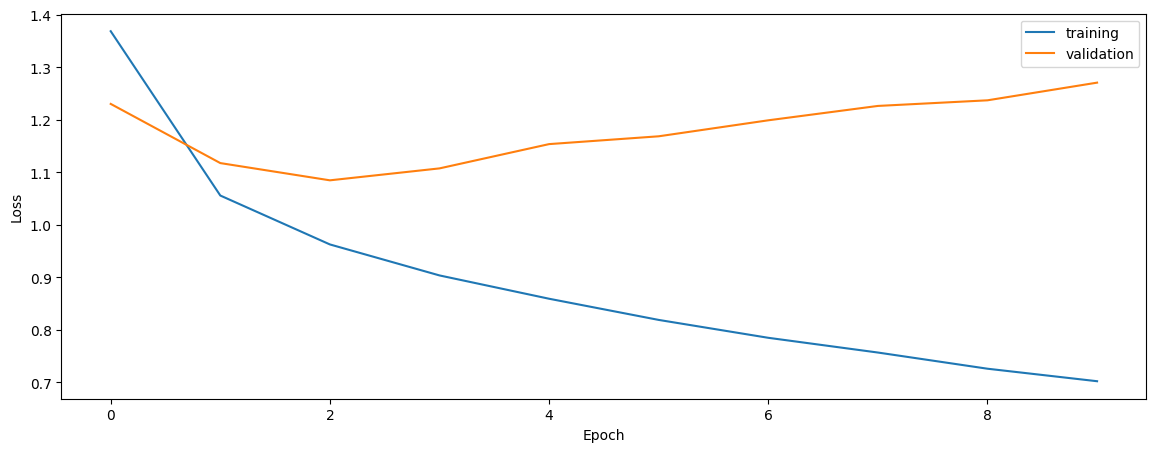

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.640440354433092
0.5628349134377576
0.5749459116920359


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.5796949280691034
0.5700853350189633
0.5133079847908745


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.5765047090952194
0.5747867298578199
0.5203104414158077


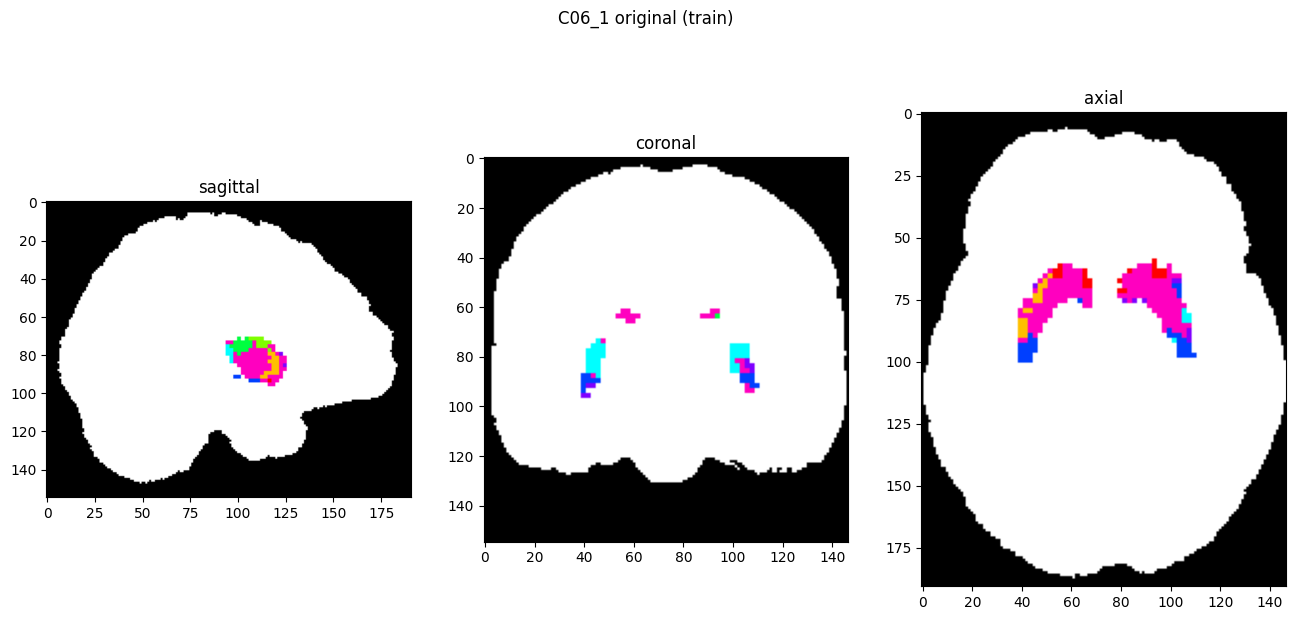

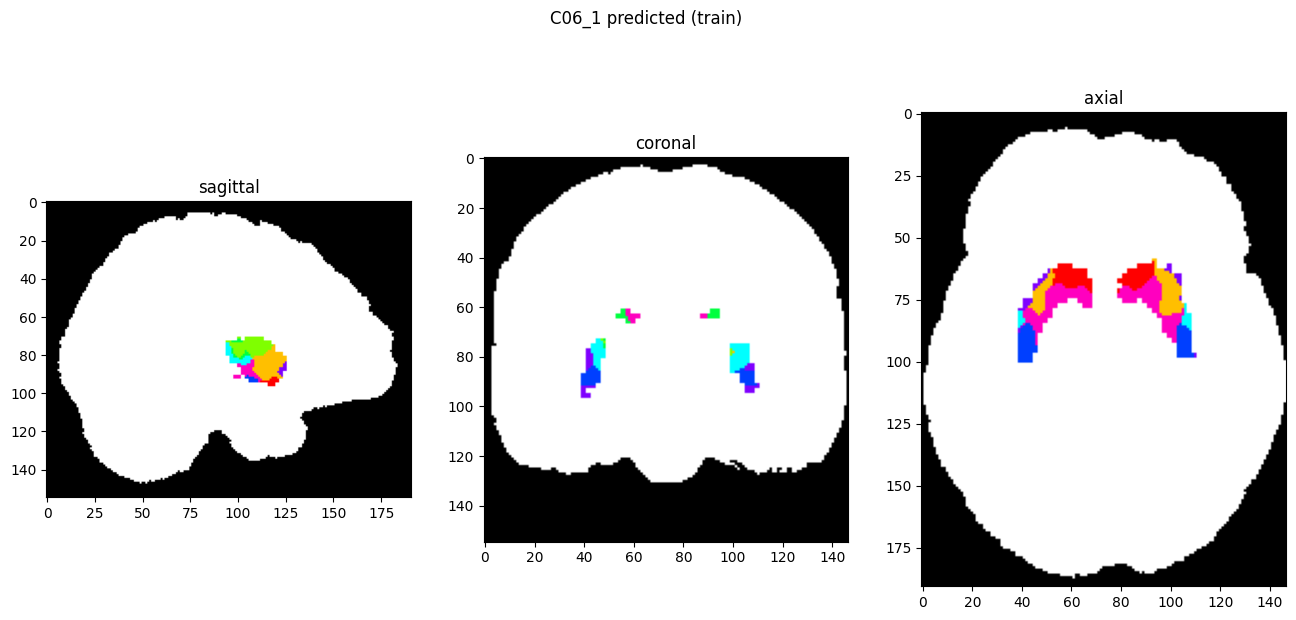

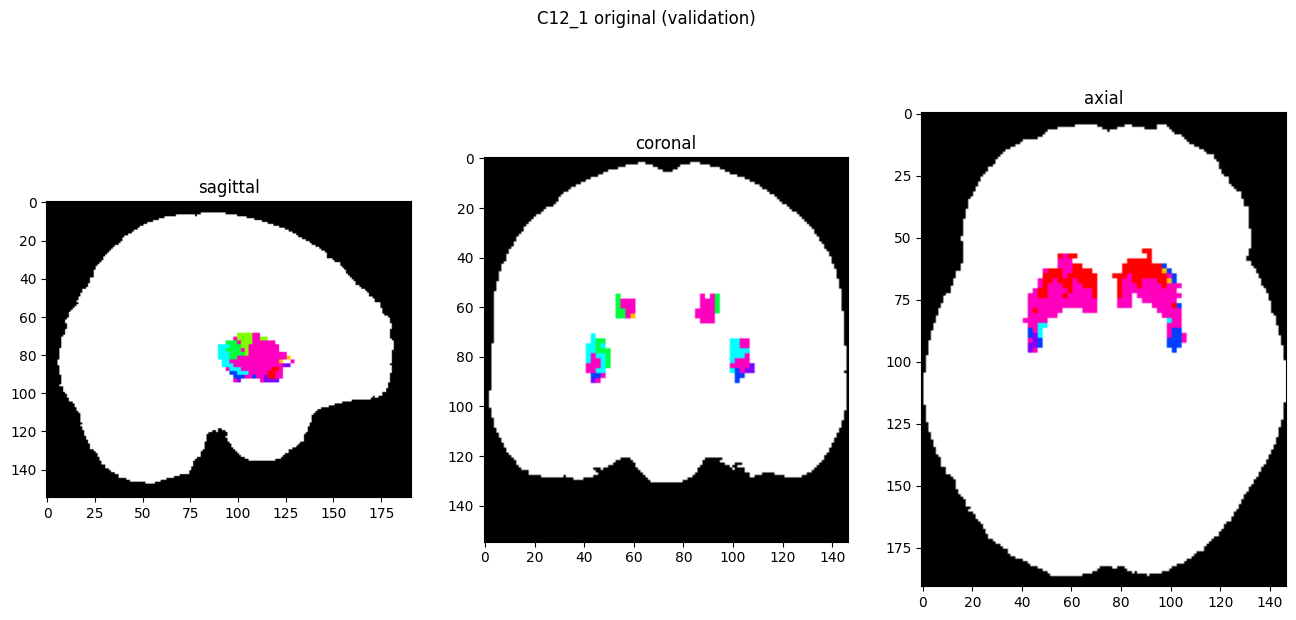

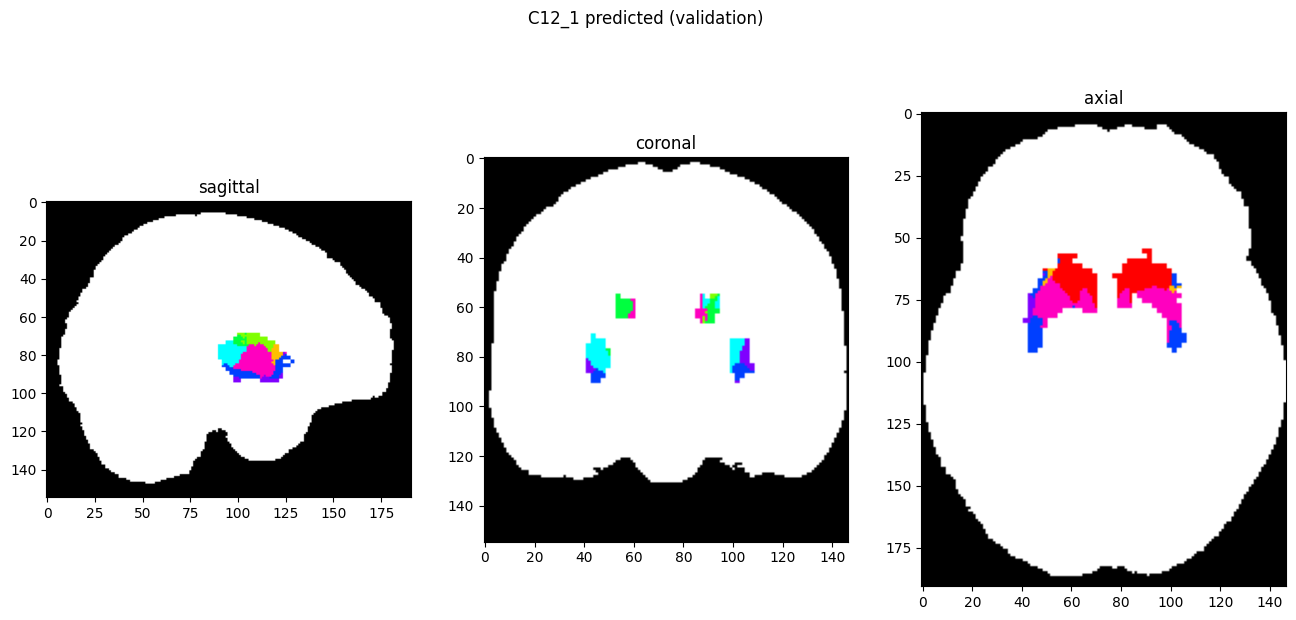

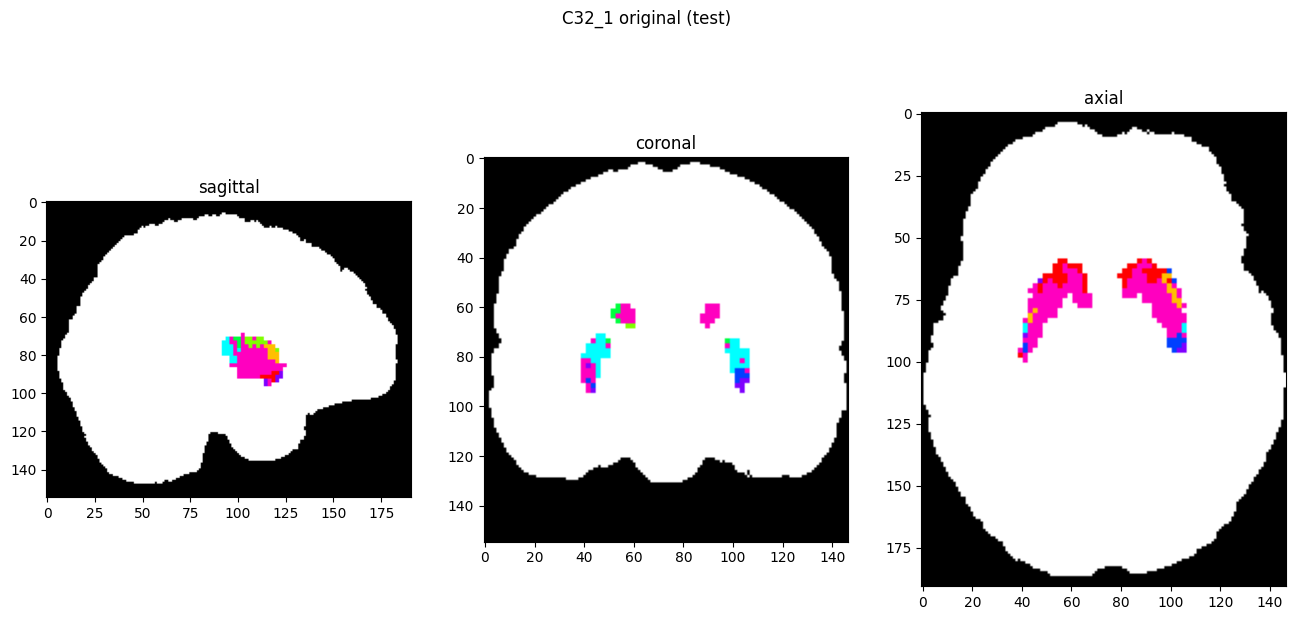

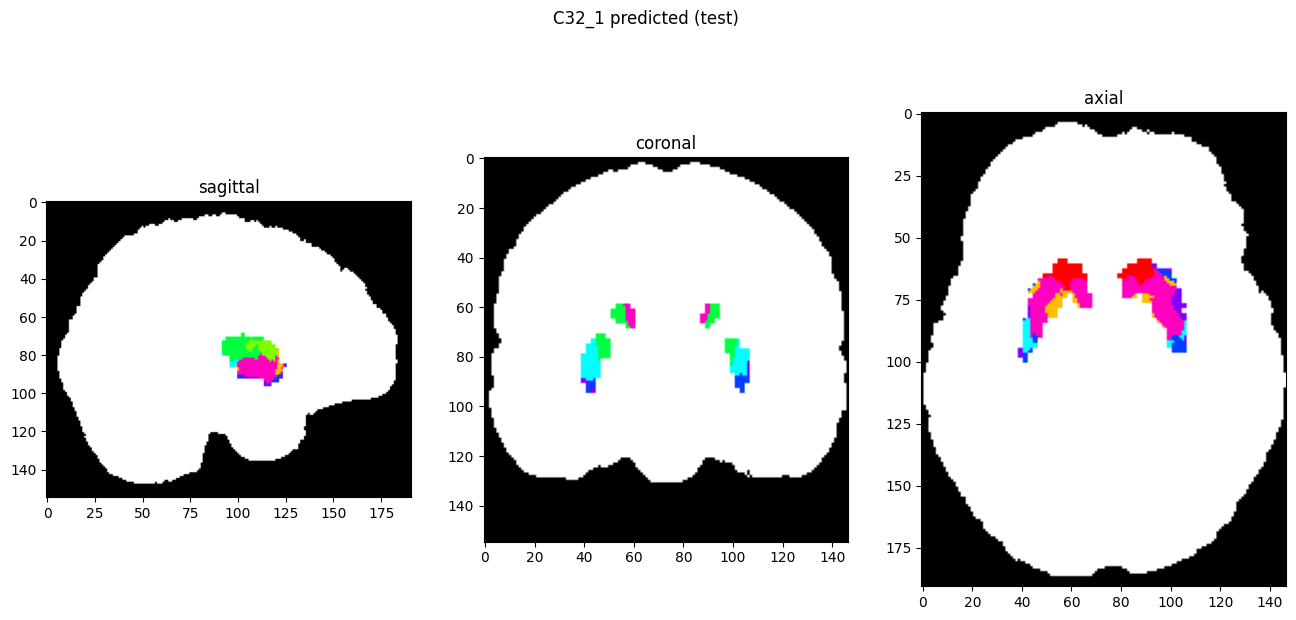

In [10]:
showResults(model, gen, threshold=0)